In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:48 - loss: 3.1970 - STD: 0.0958 - MAE: 0.2347

 4/66 [>.............................] - ETA: 1s - loss: 2.3375 - STD: 0.0681 - MAE: 0.2181  

 5/66 [=>............................] - ETA: 2s - loss: 2.1639 - STD: 0.0782 - MAE: 0.2095

 6/66 [=>............................] - ETA: 13s - loss: 2.0597 - STD: 0.0932 - MAE: 0.2002

 9/66 [===>..........................] - ETA: 8s - loss: 1.8243 - STD: 0.1377 - MAE: 0.1777 

11/66 [====>.........................] - ETA: 7s - loss: 1.7457 - STD: 0.1585 - MAE: 0.1677

12/66 [====>.........................] - ETA: 6s - loss: 1.7136 - STD: 0.1663 - MAE: 0.1639

13/66 [====>.........................] - ETA: 6s - loss: 1.6857 - STD: 0.1725 - MAE: 0.1607

14/66 [=====>........................] - ETA: 5s - loss: 1.6621 - STD: 0.1773 - MAE: 0.1583

15/66 [=====>........................] - ETA: 5s - loss: 1.6429 - STD: 0.1809 - MAE: 0.1565

16/66 [======>.......................] - ETA: 5s - loss: 1.6234 - STD: 0.1833 - MAE: 0.1551

17/66 [======>.......................] - ETA: 5s - loss: 1.6077 - STD: 0.1849 - MAE: 0.1541

18/66 [=======>......................] - ETA: 4s - loss: 1.5926 - STD: 0.1857 - MAE: 0.1535

19/66 [=======>......................] - ETA: 4s - loss: 1.5802 - STD: 0.1861 - MAE: 0.1531

20/66 [========>.....................] - ETA: 4s - loss: 1.5683 - STD: 0.1861 - MAE: 0.1528

21/66 [========>.....................] - ETA: 4s - loss: 1.5567 - STD: 0.1860 - MAE: 0.1526

22/66 [=========>....................] - ETA: 4s - loss: 1.5480 - STD: 0.1859 - MAE: 0.1524

23/66 [=========>....................] - ETA: 3s - loss: 1.5390 - STD: 0.1859 - MAE: 0.1523

24/66 [=========>....................] - ETA: 3s - loss: 1.5307 - STD: 0.1859 - MAE: 0.1521

25/66 [==========>...................] - ETA: 3s - loss: 1.5222 - STD: 0.1860 - MAE: 0.1519

26/66 [==========>...................] - ETA: 3s - loss: 1.5142 - STD: 0.1863 - MAE: 0.1516

27/66 [===========>..................] - ETA: 3s - loss: 1.5069 - STD: 0.1866 - MAE: 0.1513

28/66 [===========>..................] - ETA: 3s - loss: 1.4993 - STD: 0.1870 - MAE: 0.1510

29/66 [============>.................] - ETA: 3s - loss: 1.4931 - STD: 0.1875 - MAE: 0.1507

30/66 [============>.................] - ETA: 2s - loss: 1.4878 - STD: 0.1879 - MAE: 0.1504

31/66 [=============>................] - ETA: 2s - loss: 1.4826 - STD: 0.1884 - MAE: 0.1501

32/66 [=============>................] - ETA: 2s - loss: 1.4772 - STD: 0.1888 - MAE: 0.1499

33/66 [==============>...............] - ETA: 2s - loss: 1.4717 - STD: 0.1892 - MAE: 0.1496

34/66 [==============>...............] - ETA: 2s - loss: 1.4672 - STD: 0.1895 - MAE: 0.1494

35/66 [==============>...............] - ETA: 2s - loss: 1.4630 - STD: 0.1897 - MAE: 0.1492

36/66 [===============>..............] - ETA: 2s - loss: 1.4591 - STD: 0.1898 - MAE: 0.1491

37/66 [===============>..............] - ETA: 2s - loss: 1.4551 - STD: 0.1899 - MAE: 0.1490

38/66 [================>.............] - ETA: 2s - loss: 1.4513 - STD: 0.1900 - MAE: 0.1489

39/66 [================>.............] - ETA: 2s - loss: 1.4475 - STD: 0.1899 - MAE: 0.1488

40/66 [=================>............] - ETA: 1s - loss: 1.4439 - STD: 0.1898 - MAE: 0.1487

41/66 [=================>............] - ETA: 1s - loss: 1.4410 - STD: 0.1898 - MAE: 0.1487

42/66 [==================>...........] - ETA: 1s - loss: 1.4378 - STD: 0.1896 - MAE: 0.1487

43/66 [==================>...........] - ETA: 1s - loss: 1.4349 - STD: 0.1895 - MAE: 0.1487

44/66 [===================>..........] - ETA: 1s - loss: 1.4321 - STD: 0.1894 - MAE: 0.1486

45/66 [===================>..........] - ETA: 1s - loss: 1.4293 - STD: 0.1893 - MAE: 0.1486

46/66 [===================>..........] - ETA: 1s - loss: 1.4270 - STD: 0.1893 - MAE: 0.1486

47/66 [====================>.........] - ETA: 1s - loss: 1.4248 - STD: 0.1892 - MAE: 0.1486

48/66 [====================>.........] - ETA: 1s - loss: 1.4221 - STD: 0.1892 - MAE: 0.1485

49/66 [=====================>........] - ETA: 1s - loss: 1.4190 - STD: 0.1892 - MAE: 0.1484

50/66 [=====================>........] - ETA: 1s - loss: 1.4167 - STD: 0.1893 - MAE: 0.1484

51/66 [======================>.......] - ETA: 1s - loss: 1.4148 - STD: 0.1894 - MAE: 0.1483

52/66 [======================>.......] - ETA: 1s - loss: 1.4126 - STD: 0.1895 - MAE: 0.1482

53/66 [=======================>......] - ETA: 0s - loss: 1.4110 - STD: 0.1896 - MAE: 0.1481

54/66 [=======================>......] - ETA: 0s - loss: 1.4091 - STD: 0.1898 - MAE: 0.1480

55/66 [========================>.....] - ETA: 0s - loss: 1.4073 - STD: 0.1899 - MAE: 0.1479

56/66 [========================>.....] - ETA: 0s - loss: 1.4055 - STD: 0.1901 - MAE: 0.1478

57/66 [========================>.....] - ETA: 0s - loss: 1.4038 - STD: 0.1902 - MAE: 0.1477

58/66 [=========================>....] - ETA: 0s - loss: 1.4025 - STD: 0.1903 - MAE: 0.1477

59/66 [=========================>....] - ETA: 0s - loss: 1.4006 - STD: 0.1904 - MAE: 0.1476

60/66 [==========================>...] - ETA: 0s - loss: 1.3990 - STD: 0.1905 - MAE: 0.1475

61/66 [==========================>...] - ETA: 0s - loss: 1.3977 - STD: 0.1906 - MAE: 0.1475

62/66 [===========================>..] - ETA: 0s - loss: 1.3964 - STD: 0.1906 - MAE: 0.1474

63/66 [===========================>..] - ETA: 0s - loss: 1.3947 - STD: 0.1906 - MAE: 0.1474

64/66 [============================>.] - ETA: 0s - loss: 1.3934 - STD: 0.1906 - MAE: 0.1474

65/66 [============================>.] - ETA: 0s - loss: 1.3921 - STD: 0.1906 - MAE: 0.1473

66/66 [==============================] - ETA: 0s - loss: 1.3909 - STD: 0.1906 - MAE: 0.1473

66/66 [==============================] - 7s 81ms/step - loss: 1.3909 - STD: 0.1906 - MAE: 0.1473 - val_loss: 1.2452 - val_STD: 0.1905 - val_MAE: 0.1424


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2993 - STD: 0.1905 - MAE: 0.1453

 2/66 [..............................] - ETA: 4s - loss: 1.3103 - STD: 0.1905 - MAE: 0.1460

 3/66 [>.............................] - ETA: 3s - loss: 1.3058 - STD: 0.1904 - MAE: 0.1456

 4/66 [>.............................] - ETA: 3s - loss: 1.3079 - STD: 0.1904 - MAE: 0.1456

 5/66 [=>............................] - ETA: 3s - loss: 1.3079 - STD: 0.1904 - MAE: 0.1456

 6/66 [=>............................] - ETA: 3s - loss: 1.3087 - STD: 0.1905 - MAE: 0.1456

 7/66 [==>...........................] - ETA: 3s - loss: 1.3086 - STD: 0.1906 - MAE: 0.1456

 8/66 [==>...........................] - ETA: 3s - loss: 1.3090 - STD: 0.1907 - MAE: 0.1455

 9/66 [===>..........................] - ETA: 3s - loss: 1.3103 - STD: 0.1909 - MAE: 0.1455

10/66 [===>..........................] - ETA: 3s - loss: 1.3096 - STD: 0.1910 - MAE: 0.1455

11/66 [====>.........................] - ETA: 3s - loss: 1.3097 - STD: 0.1910 - MAE: 0.1455

12/66 [====>.........................] - ETA: 3s - loss: 1.3080 - STD: 0.1911 - MAE: 0.1454

13/66 [====>.........................] - ETA: 3s - loss: 1.3063 - STD: 0.1911 - MAE: 0.1452

14/66 [=====>........................] - ETA: 3s - loss: 1.3055 - STD: 0.1912 - MAE: 0.1452

15/66 [=====>........................] - ETA: 3s - loss: 1.3058 - STD: 0.1913 - MAE: 0.1451

16/66 [======>.......................] - ETA: 2s - loss: 1.3059 - STD: 0.1914 - MAE: 0.1451

17/66 [======>.......................] - ETA: 2s - loss: 1.3056 - STD: 0.1915 - MAE: 0.1451

18/66 [=======>......................] - ETA: 2s - loss: 1.3063 - STD: 0.1916 - MAE: 0.1451

19/66 [=======>......................] - ETA: 2s - loss: 1.3062 - STD: 0.1917 - MAE: 0.1450

20/66 [========>.....................] - ETA: 2s - loss: 1.3065 - STD: 0.1917 - MAE: 0.1450

21/66 [========>.....................] - ETA: 2s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1450

22/66 [=========>....................] - ETA: 2s - loss: 1.3073 - STD: 0.1918 - MAE: 0.1450

23/66 [=========>....................] - ETA: 2s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1450

24/66 [=========>....................] - ETA: 2s - loss: 1.3068 - STD: 0.1918 - MAE: 0.1450

25/66 [==========>...................] - ETA: 2s - loss: 1.3075 - STD: 0.1918 - MAE: 0.1450

26/66 [==========>...................] - ETA: 2s - loss: 1.3077 - STD: 0.1918 - MAE: 0.1450

27/66 [===========>..................] - ETA: 2s - loss: 1.3076 - STD: 0.1918 - MAE: 0.1450

28/66 [===========>..................] - ETA: 2s - loss: 1.3075 - STD: 0.1918 - MAE: 0.1450

29/66 [============>.................] - ETA: 2s - loss: 1.3076 - STD: 0.1919 - MAE: 0.1450

30/66 [============>.................] - ETA: 2s - loss: 1.3079 - STD: 0.1919 - MAE: 0.1450

31/66 [=============>................] - ETA: 2s - loss: 1.3080 - STD: 0.1919 - MAE: 0.1450

32/66 [=============>................] - ETA: 1s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

33/66 [==============>...............] - ETA: 1s - loss: 1.3085 - STD: 0.1920 - MAE: 0.1450

34/66 [==============>...............] - ETA: 1s - loss: 1.3084 - STD: 0.1919 - MAE: 0.1450

35/66 [==============>...............] - ETA: 1s - loss: 1.3087 - STD: 0.1919 - MAE: 0.1450

36/66 [===============>..............] - ETA: 1s - loss: 1.3084 - STD: 0.1919 - MAE: 0.1450

37/66 [===============>..............] - ETA: 1s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1451

38/66 [================>.............] - ETA: 1s - loss: 1.3088 - STD: 0.1918 - MAE: 0.1451

39/66 [================>.............] - ETA: 1s - loss: 1.3089 - STD: 0.1917 - MAE: 0.1451

40/66 [=================>............] - ETA: 1s - loss: 1.3094 - STD: 0.1917 - MAE: 0.1452

41/66 [=================>............] - ETA: 1s - loss: 1.3090 - STD: 0.1916 - MAE: 0.1452

42/66 [==================>...........] - ETA: 1s - loss: 1.3091 - STD: 0.1916 - MAE: 0.1452

43/66 [==================>...........] - ETA: 1s - loss: 1.3090 - STD: 0.1916 - MAE: 0.1452

44/66 [===================>..........] - ETA: 1s - loss: 1.3086 - STD: 0.1916 - MAE: 0.1452

45/66 [===================>..........] - ETA: 1s - loss: 1.3091 - STD: 0.1916 - MAE: 0.1452

46/66 [===================>..........] - ETA: 1s - loss: 1.3085 - STD: 0.1916 - MAE: 0.1452

47/66 [====================>.........] - ETA: 1s - loss: 1.3085 - STD: 0.1917 - MAE: 0.1452

48/66 [====================>.........] - ETA: 1s - loss: 1.3086 - STD: 0.1917 - MAE: 0.1451

49/66 [=====================>........] - ETA: 0s - loss: 1.3080 - STD: 0.1917 - MAE: 0.1451

50/66 [=====================>........] - ETA: 0s - loss: 1.3080 - STD: 0.1918 - MAE: 0.1451

51/66 [======================>.......] - ETA: 0s - loss: 1.3084 - STD: 0.1918 - MAE: 0.1451

52/66 [======================>.......] - ETA: 0s - loss: 1.3081 - STD: 0.1918 - MAE: 0.1451

53/66 [=======================>......] - ETA: 0s - loss: 1.3084 - STD: 0.1918 - MAE: 0.1451

54/66 [=======================>......] - ETA: 0s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1451

55/66 [========================>.....] - ETA: 0s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1451

56/66 [========================>.....] - ETA: 0s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

57/66 [========================>.....] - ETA: 0s - loss: 1.3089 - STD: 0.1918 - MAE: 0.1451

58/66 [=========================>....] - ETA: 0s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1451

59/66 [=========================>....] - ETA: 0s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

60/66 [==========================>...] - ETA: 0s - loss: 1.3080 - STD: 0.1918 - MAE: 0.1451

61/66 [==========================>...] - ETA: 0s - loss: 1.3079 - STD: 0.1918 - MAE: 0.1451

62/66 [===========================>..] - ETA: 0s - loss: 1.3076 - STD: 0.1918 - MAE: 0.1451

63/66 [===========================>..] - ETA: 0s - loss: 1.3078 - STD: 0.1918 - MAE: 0.1451

65/66 [============================>.] - ETA: 0s - loss: 1.3082 - STD: 0.1919 - MAE: 0.1451

66/66 [==============================] - ETA: 0s - loss: 1.3082 - STD: 0.1919 - MAE: 0.1451

66/66 [==============================] - 4s 61ms/step - loss: 1.3082 - STD: 0.1919 - MAE: 0.1451 - val_loss: 1.2443 - val_STD: 0.1929 - val_MAE: 0.1414


Epoch 3/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2873 - STD: 0.1929 - MAE: 0.1436

 2/66 [..............................] - ETA: 4s - loss: 1.2977 - STD: 0.1925 - MAE: 0.1443

 3/66 [>.............................] - ETA: 3s - loss: 1.3080 - STD: 0.1921 - MAE: 0.1450

 4/66 [>.............................] - ETA: 3s - loss: 1.3087 - STD: 0.1917 - MAE: 0.1453

 5/66 [=>............................] - ETA: 3s - loss: 1.3097 - STD: 0.1913 - MAE: 0.1455

 6/66 [=>............................] - ETA: 3s - loss: 1.3104 - STD: 0.1909 - MAE: 0.1456

 7/66 [==>...........................] - ETA: 3s - loss: 1.3094 - STD: 0.1906 - MAE: 0.1456

 8/66 [==>...........................] - ETA: 3s - loss: 1.3097 - STD: 0.1905 - MAE: 0.1457

 9/66 [===>..........................] - ETA: 3s - loss: 1.3102 - STD: 0.1905 - MAE: 0.1458

10/66 [===>..........................] - ETA: 3s - loss: 1.3095 - STD: 0.1905 - MAE: 0.1457

11/66 [====>.........................] - ETA: 3s - loss: 1.3089 - STD: 0.1907 - MAE: 0.1456

12/66 [====>.........................] - ETA: 3s - loss: 1.3106 - STD: 0.1908 - MAE: 0.1457

13/66 [====>.........................] - ETA: 3s - loss: 1.3112 - STD: 0.1910 - MAE: 0.1456

14/66 [=====>........................] - ETA: 3s - loss: 1.3111 - STD: 0.1912 - MAE: 0.1456

15/66 [=====>........................] - ETA: 3s - loss: 1.3104 - STD: 0.1913 - MAE: 0.1455

16/66 [======>.......................] - ETA: 2s - loss: 1.3094 - STD: 0.1914 - MAE: 0.1454

17/66 [======>.......................] - ETA: 2s - loss: 1.3085 - STD: 0.1914 - MAE: 0.1453

18/66 [=======>......................] - ETA: 2s - loss: 1.3074 - STD: 0.1915 - MAE: 0.1452

19/66 [=======>......................] - ETA: 2s - loss: 1.3075 - STD: 0.1916 - MAE: 0.1451

20/66 [========>.....................] - ETA: 2s - loss: 1.3074 - STD: 0.1917 - MAE: 0.1451

21/66 [========>.....................] - ETA: 2s - loss: 1.3076 - STD: 0.1918 - MAE: 0.1451

22/66 [=========>....................] - ETA: 2s - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451

23/66 [=========>....................] - ETA: 2s - loss: 1.3086 - STD: 0.1919 - MAE: 0.1451

24/66 [=========>....................] - ETA: 2s - loss: 1.3089 - STD: 0.1919 - MAE: 0.1451

25/66 [==========>...................] - ETA: 2s - loss: 1.3095 - STD: 0.1918 - MAE: 0.1452

26/66 [==========>...................] - ETA: 2s - loss: 1.3101 - STD: 0.1917 - MAE: 0.1452

27/66 [===========>..................] - ETA: 2s - loss: 1.3097 - STD: 0.1916 - MAE: 0.1452

28/66 [===========>..................] - ETA: 2s - loss: 1.3097 - STD: 0.1915 - MAE: 0.1453

29/66 [============>.................] - ETA: 2s - loss: 1.3095 - STD: 0.1915 - MAE: 0.1453

30/66 [============>.................] - ETA: 2s - loss: 1.3096 - STD: 0.1914 - MAE: 0.1453

32/66 [=============>................] - ETA: 1s - loss: 1.3083 - STD: 0.1914 - MAE: 0.1453

33/66 [==============>...............] - ETA: 1s - loss: 1.3083 - STD: 0.1915 - MAE: 0.1452

34/66 [==============>...............] - ETA: 1s - loss: 1.3084 - STD: 0.1915 - MAE: 0.1452

35/66 [==============>...............] - ETA: 1s - loss: 1.3078 - STD: 0.1916 - MAE: 0.1451

36/66 [===============>..............] - ETA: 1s - loss: 1.3078 - STD: 0.1917 - MAE: 0.1451

37/66 [===============>..............] - ETA: 1s - loss: 1.3073 - STD: 0.1918 - MAE: 0.1451

38/66 [================>.............] - ETA: 1s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1450

39/66 [================>.............] - ETA: 1s - loss: 1.3071 - STD: 0.1919 - MAE: 0.1450

40/66 [=================>............] - ETA: 1s - loss: 1.3071 - STD: 0.1919 - MAE: 0.1450

41/66 [=================>............] - ETA: 1s - loss: 1.3066 - STD: 0.1920 - MAE: 0.1450

42/66 [==================>...........] - ETA: 1s - loss: 1.3069 - STD: 0.1920 - MAE: 0.1450

43/66 [==================>...........] - ETA: 1s - loss: 1.3072 - STD: 0.1920 - MAE: 0.1450

44/66 [===================>..........] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

45/66 [===================>..........] - ETA: 1s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1450

46/66 [===================>..........] - ETA: 1s - loss: 1.3068 - STD: 0.1919 - MAE: 0.1450

47/66 [====================>.........] - ETA: 1s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1450

48/66 [====================>.........] - ETA: 1s - loss: 1.3069 - STD: 0.1919 - MAE: 0.1450

49/66 [=====================>........] - ETA: 0s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

50/66 [=====================>........] - ETA: 0s - loss: 1.3073 - STD: 0.1919 - MAE: 0.1450

51/66 [======================>.......] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

52/66 [======================>.......] - ETA: 0s - loss: 1.3074 - STD: 0.1919 - MAE: 0.1450

53/66 [=======================>......] - ETA: 0s - loss: 1.3075 - STD: 0.1919 - MAE: 0.1450

54/66 [=======================>......] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

55/66 [========================>.....] - ETA: 0s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1450

56/66 [========================>.....] - ETA: 0s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1450

57/66 [========================>.....] - ETA: 0s - loss: 1.3070 - STD: 0.1918 - MAE: 0.1450

58/66 [=========================>....] - ETA: 0s - loss: 1.3068 - STD: 0.1918 - MAE: 0.1450

59/66 [=========================>....] - ETA: 0s - loss: 1.3067 - STD: 0.1918 - MAE: 0.1450

60/66 [==========================>...] - ETA: 0s - loss: 1.3066 - STD: 0.1919 - MAE: 0.1450

61/66 [==========================>...] - ETA: 0s - loss: 1.3064 - STD: 0.1919 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3062 - STD: 0.1919 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3064 - STD: 0.1919 - MAE: 0.1449

64/66 [============================>.] - ETA: 0s - loss: 1.3066 - STD: 0.1920 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3069 - STD: 0.1920 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3066 - STD: 0.1919 - MAE: 0.1449

66/66 [==============================] - 4s 61ms/step - loss: 1.3066 - STD: 0.1919 - MAE: 0.1449 - val_loss: 1.2373 - val_STD: 0.1903 - val_MAE: 0.1420


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.3055 - STD: 0.1899 - MAE: 0.1455

 2/66 [..............................] - ETA: 4s - loss: 1.2973 - STD: 0.1899 - MAE: 0.1451

 3/66 [>.............................] - ETA: 3s - loss: 1.2979 - STD: 0.1899 - MAE: 0.1450

 4/66 [>.............................] - ETA: 3s - loss: 1.2998 - STD: 0.1901 - MAE: 0.1451

 5/66 [=>............................] - ETA: 3s - loss: 1.2996 - STD: 0.1904 - MAE: 0.1450

 6/66 [=>............................] - ETA: 3s - loss: 1.3016 - STD: 0.1906 - MAE: 0.1450

 7/66 [==>...........................] - ETA: 3s - loss: 1.2987 - STD: 0.1908 - MAE: 0.1447

 8/66 [==>...........................] - ETA: 3s - loss: 1.2991 - STD: 0.1910 - MAE: 0.1447

 9/66 [===>..........................] - ETA: 3s - loss: 1.3013 - STD: 0.1911 - MAE: 0.1448

10/66 [===>..........................] - ETA: 3s - loss: 1.3018 - STD: 0.1911 - MAE: 0.1448

11/66 [====>.........................] - ETA: 3s - loss: 1.3016 - STD: 0.1910 - MAE: 0.1448

12/66 [====>.........................] - ETA: 3s - loss: 1.3007 - STD: 0.1909 - MAE: 0.1448

13/66 [====>.........................] - ETA: 3s - loss: 1.3000 - STD: 0.1908 - MAE: 0.1448

14/66 [=====>........................] - ETA: 2s - loss: 1.2983 - STD: 0.1908 - MAE: 0.1447

15/66 [=====>........................] - ETA: 2s - loss: 1.2980 - STD: 0.1909 - MAE: 0.1447

16/66 [======>.......................] - ETA: 2s - loss: 1.2976 - STD: 0.1911 - MAE: 0.1446

17/66 [======>.......................] - ETA: 2s - loss: 1.2976 - STD: 0.1912 - MAE: 0.1445

18/66 [=======>......................] - ETA: 2s - loss: 1.2975 - STD: 0.1913 - MAE: 0.1445

19/66 [=======>......................] - ETA: 2s - loss: 1.2967 - STD: 0.1913 - MAE: 0.1444

20/66 [========>.....................] - ETA: 2s - loss: 1.2963 - STD: 0.1913 - MAE: 0.1444

21/66 [========>.....................] - ETA: 2s - loss: 1.2954 - STD: 0.1912 - MAE: 0.1444

22/66 [=========>....................] - ETA: 2s - loss: 1.2947 - STD: 0.1912 - MAE: 0.1443

23/66 [=========>....................] - ETA: 2s - loss: 1.2951 - STD: 0.1913 - MAE: 0.1443

24/66 [=========>....................] - ETA: 2s - loss: 1.2947 - STD: 0.1913 - MAE: 0.1443

26/66 [==========>...................] - ETA: 2s - loss: 1.2940 - STD: 0.1914 - MAE: 0.1442

27/66 [===========>..................] - ETA: 2s - loss: 1.2937 - STD: 0.1915 - MAE: 0.1442

28/66 [===========>..................] - ETA: 2s - loss: 1.2942 - STD: 0.1915 - MAE: 0.1442

29/66 [============>.................] - ETA: 2s - loss: 1.2939 - STD: 0.1915 - MAE: 0.1442

30/66 [============>.................] - ETA: 2s - loss: 1.2942 - STD: 0.1914 - MAE: 0.1442

31/66 [=============>................] - ETA: 1s - loss: 1.2931 - STD: 0.1914 - MAE: 0.1442

32/66 [=============>................] - ETA: 1s - loss: 1.2925 - STD: 0.1914 - MAE: 0.1441

33/66 [==============>...............] - ETA: 1s - loss: 1.2924 - STD: 0.1914 - MAE: 0.1441

34/66 [==============>...............] - ETA: 1s - loss: 1.2916 - STD: 0.1914 - MAE: 0.1441

35/66 [==============>...............] - ETA: 1s - loss: 1.2908 - STD: 0.1914 - MAE: 0.1440

36/66 [===============>..............] - ETA: 1s - loss: 1.2899 - STD: 0.1915 - MAE: 0.1439

37/66 [===============>..............] - ETA: 1s - loss: 1.2893 - STD: 0.1916 - MAE: 0.1439

38/66 [================>.............] - ETA: 1s - loss: 1.2892 - STD: 0.1917 - MAE: 0.1438

39/66 [================>.............] - ETA: 1s - loss: 1.2888 - STD: 0.1917 - MAE: 0.1438

40/66 [=================>............] - ETA: 1s - loss: 1.2882 - STD: 0.1917 - MAE: 0.1437

41/66 [=================>............] - ETA: 1s - loss: 1.2877 - STD: 0.1918 - MAE: 0.1437

42/66 [==================>...........] - ETA: 1s - loss: 1.2872 - STD: 0.1918 - MAE: 0.1437

43/66 [==================>...........] - ETA: 1s - loss: 1.2866 - STD: 0.1918 - MAE: 0.1436

44/66 [===================>..........] - ETA: 1s - loss: 1.2860 - STD: 0.1918 - MAE: 0.1436

45/66 [===================>..........] - ETA: 1s - loss: 1.2853 - STD: 0.1919 - MAE: 0.1435

46/66 [===================>..........] - ETA: 1s - loss: 1.2847 - STD: 0.1920 - MAE: 0.1434

47/66 [====================>.........] - ETA: 1s - loss: 1.2842 - STD: 0.1921 - MAE: 0.1434

48/66 [====================>.........] - ETA: 0s - loss: 1.2838 - STD: 0.1922 - MAE: 0.1433

49/66 [=====================>........] - ETA: 0s - loss: 1.2836 - STD: 0.1923 - MAE: 0.1432

50/66 [=====================>........] - ETA: 0s - loss: 1.2828 - STD: 0.1923 - MAE: 0.1432

51/66 [======================>.......] - ETA: 0s - loss: 1.2822 - STD: 0.1924 - MAE: 0.1431

52/66 [======================>.......] - ETA: 0s - loss: 1.2817 - STD: 0.1925 - MAE: 0.1431

53/66 [=======================>......] - ETA: 0s - loss: 1.2807 - STD: 0.1926 - MAE: 0.1430

54/66 [=======================>......] - ETA: 0s - loss: 1.2803 - STD: 0.1926 - MAE: 0.1429

55/66 [========================>.....] - ETA: 0s - loss: 1.2801 - STD: 0.1927 - MAE: 0.1429

56/66 [========================>.....] - ETA: 0s - loss: 1.2799 - STD: 0.1927 - MAE: 0.1429

57/66 [========================>.....] - ETA: 0s - loss: 1.2794 - STD: 0.1928 - MAE: 0.1428

58/66 [=========================>....] - ETA: 0s - loss: 1.2791 - STD: 0.1928 - MAE: 0.1428

59/66 [=========================>....] - ETA: 0s - loss: 1.2790 - STD: 0.1929 - MAE: 0.1427

60/66 [==========================>...] - ETA: 0s - loss: 1.2787 - STD: 0.1930 - MAE: 0.1427

61/66 [==========================>...] - ETA: 0s - loss: 1.2781 - STD: 0.1931 - MAE: 0.1426

62/66 [===========================>..] - ETA: 0s - loss: 1.2777 - STD: 0.1931 - MAE: 0.1426

63/66 [===========================>..] - ETA: 0s - loss: 1.2771 - STD: 0.1932 - MAE: 0.1425

64/66 [============================>.] - ETA: 0s - loss: 1.2764 - STD: 0.1932 - MAE: 0.1425

65/66 [============================>.] - ETA: 0s - loss: 1.2761 - STD: 0.1933 - MAE: 0.1424

66/66 [==============================] - ETA: 0s - loss: 1.2755 - STD: 0.1933 - MAE: 0.1424

66/66 [==============================] - 4s 59ms/step - loss: 1.2755 - STD: 0.1933 - MAE: 0.1424 - val_loss: 1.1752 - val_STD: 0.2027 - val_MAE: 0.1329


Epoch 5/10000


 1/66 [..............................] - ETA: 5s - loss: 1.2501 - STD: 0.1981 - MAE: 0.1389

 2/66 [..............................] - ETA: 3s - loss: 1.2462 - STD: 0.1984 - MAE: 0.1387

 3/66 [>.............................] - ETA: 3s - loss: 1.2522 - STD: 0.1995 - MAE: 0.1387

 4/66 [>.............................] - ETA: 3s - loss: 1.2505 - STD: 0.1990 - MAE: 0.1388

 5/66 [=>............................] - ETA: 3s - loss: 1.2499 - STD: 0.1984 - MAE: 0.1390

 6/66 [=>............................] - ETA: 3s - loss: 1.2501 - STD: 0.1981 - MAE: 0.1391

 7/66 [==>...........................] - ETA: 3s - loss: 1.2509 - STD: 0.1982 - MAE: 0.1392

 8/66 [==>...........................] - ETA: 3s - loss: 1.2495 - STD: 0.1982 - MAE: 0.1391

 9/66 [===>..........................] - ETA: 3s - loss: 1.2484 - STD: 0.1982 - MAE: 0.1390

10/66 [===>..........................] - ETA: 3s - loss: 1.2477 - STD: 0.1985 - MAE: 0.1389

11/66 [====>.........................] - ETA: 3s - loss: 1.2463 - STD: 0.1988 - MAE: 0.1387

12/66 [====>.........................] - ETA: 3s - loss: 1.2456 - STD: 0.1990 - MAE: 0.1386

13/66 [====>.........................] - ETA: 3s - loss: 1.2460 - STD: 0.1991 - MAE: 0.1386

14/66 [=====>........................] - ETA: 2s - loss: 1.2467 - STD: 0.1988 - MAE: 0.1387

15/66 [=====>........................] - ETA: 2s - loss: 1.2450 - STD: 0.1986 - MAE: 0.1387

16/66 [======>.......................] - ETA: 2s - loss: 1.2451 - STD: 0.1988 - MAE: 0.1387

17/66 [======>.......................] - ETA: 2s - loss: 1.2451 - STD: 0.1990 - MAE: 0.1386

18/66 [=======>......................] - ETA: 2s - loss: 1.2455 - STD: 0.1991 - MAE: 0.1386

19/66 [=======>......................] - ETA: 2s - loss: 1.2458 - STD: 0.1988 - MAE: 0.1387

20/66 [========>.....................] - ETA: 2s - loss: 1.2458 - STD: 0.1988 - MAE: 0.1387

21/66 [========>.....................] - ETA: 2s - loss: 1.2453 - STD: 0.1990 - MAE: 0.1386

22/66 [=========>....................] - ETA: 2s - loss: 1.2455 - STD: 0.1991 - MAE: 0.1386

23/66 [=========>....................] - ETA: 2s - loss: 1.2457 - STD: 0.1988 - MAE: 0.1387

24/66 [=========>....................] - ETA: 2s - loss: 1.2460 - STD: 0.1987 - MAE: 0.1387

25/66 [==========>...................] - ETA: 2s - loss: 1.2465 - STD: 0.1991 - MAE: 0.1386

26/66 [==========>...................] - ETA: 2s - loss: 1.2462 - STD: 0.1987 - MAE: 0.1387

27/66 [===========>..................] - ETA: 2s - loss: 1.2463 - STD: 0.1986 - MAE: 0.1388

28/66 [===========>..................] - ETA: 2s - loss: 1.2461 - STD: 0.1990 - MAE: 0.1386

29/66 [============>.................] - ETA: 2s - loss: 1.2456 - STD: 0.1988 - MAE: 0.1387

30/66 [============>.................] - ETA: 2s - loss: 1.2447 - STD: 0.1989 - MAE: 0.1386

31/66 [=============>................] - ETA: 2s - loss: 1.2441 - STD: 0.1993 - MAE: 0.1383

32/66 [=============>................] - ETA: 1s - loss: 1.2437 - STD: 0.1990 - MAE: 0.1384

33/66 [==============>...............] - ETA: 1s - loss: 1.2425 - STD: 0.1990 - MAE: 0.1384

34/66 [==============>...............] - ETA: 1s - loss: 1.2421 - STD: 0.1997 - MAE: 0.1380

35/66 [==============>...............] - ETA: 1s - loss: 1.2415 - STD: 0.1992 - MAE: 0.1382

36/66 [===============>..............] - ETA: 1s - loss: 1.2409 - STD: 0.1990 - MAE: 0.1382

37/66 [===============>..............] - ETA: 1s - loss: 1.2409 - STD: 0.1996 - MAE: 0.1380

38/66 [================>.............] - ETA: 1s - loss: 1.2401 - STD: 0.1997 - MAE: 0.1379

39/66 [================>.............] - ETA: 1s - loss: 1.2400 - STD: 0.1992 - MAE: 0.1381

40/66 [=================>............] - ETA: 1s - loss: 1.2393 - STD: 0.1992 - MAE: 0.1381

41/66 [=================>............] - ETA: 1s - loss: 1.2388 - STD: 0.1997 - MAE: 0.1378

42/66 [==================>...........] - ETA: 1s - loss: 1.2386 - STD: 0.1997 - MAE: 0.1378

43/66 [==================>...........] - ETA: 1s - loss: 1.2383 - STD: 0.1995 - MAE: 0.1379

44/66 [===================>..........] - ETA: 1s - loss: 1.2375 - STD: 0.1995 - MAE: 0.1378

45/66 [===================>..........] - ETA: 1s - loss: 1.2370 - STD: 0.1999 - MAE: 0.1376

46/66 [===================>..........] - ETA: 1s - loss: 1.2360 - STD: 0.2001 - MAE: 0.1375

48/66 [====================>.........] - ETA: 1s - loss: 1.2351 - STD: 0.1998 - MAE: 0.1376

49/66 [=====================>........] - ETA: 0s - loss: 1.2345 - STD: 0.2001 - MAE: 0.1374

50/66 [=====================>........] - ETA: 0s - loss: 1.2340 - STD: 0.2004 - MAE: 0.1373

51/66 [======================>.......] - ETA: 0s - loss: 1.2337 - STD: 0.2003 - MAE: 0.1373

52/66 [======================>.......] - ETA: 0s - loss: 1.2332 - STD: 0.2001 - MAE: 0.1374

53/66 [=======================>......] - ETA: 0s - loss: 1.2325 - STD: 0.2002 - MAE: 0.1373

54/66 [=======================>......] - ETA: 0s - loss: 1.2322 - STD: 0.2006 - MAE: 0.1371

55/66 [========================>.....] - ETA: 0s - loss: 1.2313 - STD: 0.2006 - MAE: 0.1371

56/66 [========================>.....] - ETA: 0s - loss: 1.2311 - STD: 0.2004 - MAE: 0.1371

57/66 [========================>.....] - ETA: 0s - loss: 1.2304 - STD: 0.2005 - MAE: 0.1370

58/66 [=========================>....] - ETA: 0s - loss: 1.2299 - STD: 0.2008 - MAE: 0.1369

59/66 [=========================>....] - ETA: 0s - loss: 1.2292 - STD: 0.2009 - MAE: 0.1368

60/66 [==========================>...] - ETA: 0s - loss: 1.2287 - STD: 0.2008 - MAE: 0.1368

61/66 [==========================>...] - ETA: 0s - loss: 1.2280 - STD: 0.2008 - MAE: 0.1368

62/66 [===========================>..] - ETA: 0s - loss: 1.2277 - STD: 0.2011 - MAE: 0.1367

63/66 [===========================>..] - ETA: 0s - loss: 1.2273 - STD: 0.2012 - MAE: 0.1366

64/66 [============================>.] - ETA: 0s - loss: 1.2271 - STD: 0.2010 - MAE: 0.1367

65/66 [============================>.] - ETA: 0s - loss: 1.2264 - STD: 0.2010 - MAE: 0.1366

66/66 [==============================] - ETA: 0s - loss: 1.2262 - STD: 0.2013 - MAE: 0.1365

66/66 [==============================] - 4s 59ms/step - loss: 1.2262 - STD: 0.2013 - MAE: 0.1365 - val_loss: 1.1204 - val_STD: 0.2085 - val_MAE: 0.1277


Epoch 6/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1810 - STD: 0.2051 - MAE: 0.1328

 2/66 [..............................] - ETA: 3s - loss: 1.1879 - STD: 0.2005 - MAE: 0.1349

 3/66 [>.............................] - ETA: 3s - loss: 1.1879 - STD: 0.2022 - MAE: 0.1343

 4/66 [>.............................] - ETA: 3s - loss: 1.1909 - STD: 0.2047 - MAE: 0.1335

 5/66 [=>............................] - ETA: 3s - loss: 1.1924 - STD: 0.2051 - MAE: 0.1335

 6/66 [=>............................] - ETA: 3s - loss: 1.1907 - STD: 0.2041 - MAE: 0.1338

 7/66 [==>...........................] - ETA: 3s - loss: 1.1883 - STD: 0.2044 - MAE: 0.1336

 8/66 [==>...........................] - ETA: 3s - loss: 1.1916 - STD: 0.2051 - MAE: 0.1335

 9/66 [===>..........................] - ETA: 3s - loss: 1.1910 - STD: 0.2045 - MAE: 0.1337

10/66 [===>..........................] - ETA: 3s - loss: 1.1894 - STD: 0.2042 - MAE: 0.1338

11/66 [====>.........................] - ETA: 3s - loss: 1.1885 - STD: 0.2049 - MAE: 0.1334

12/66 [====>.........................] - ETA: 3s - loss: 1.1890 - STD: 0.2053 - MAE: 0.1333

13/66 [====>.........................] - ETA: 3s - loss: 1.1895 - STD: 0.2048 - MAE: 0.1336

14/66 [=====>........................] - ETA: 3s - loss: 1.1888 - STD: 0.2045 - MAE: 0.1337

15/66 [=====>........................] - ETA: 2s - loss: 1.1877 - STD: 0.2053 - MAE: 0.1333

16/66 [======>.......................] - ETA: 2s - loss: 1.1876 - STD: 0.2055 - MAE: 0.1332

17/66 [======>.......................] - ETA: 2s - loss: 1.1860 - STD: 0.2050 - MAE: 0.1333

18/66 [=======>......................] - ETA: 2s - loss: 1.1860 - STD: 0.2050 - MAE: 0.1334

19/66 [=======>......................] - ETA: 2s - loss: 1.1863 - STD: 0.2054 - MAE: 0.1332

20/66 [========>.....................] - ETA: 2s - loss: 1.1855 - STD: 0.2053 - MAE: 0.1332

21/66 [========>.....................] - ETA: 2s - loss: 1.1851 - STD: 0.2050 - MAE: 0.1334

22/66 [=========>....................] - ETA: 2s - loss: 1.1840 - STD: 0.2053 - MAE: 0.1332

23/66 [=========>....................] - ETA: 2s - loss: 1.1836 - STD: 0.2056 - MAE: 0.1330

25/66 [==========>...................] - ETA: 2s - loss: 1.1829 - STD: 0.2052 - MAE: 0.1332

26/66 [==========>...................] - ETA: 2s - loss: 1.1822 - STD: 0.2056 - MAE: 0.1331

27/66 [===========>..................] - ETA: 2s - loss: 1.1815 - STD: 0.2057 - MAE: 0.1330

28/66 [===========>..................] - ETA: 2s - loss: 1.1813 - STD: 0.2054 - MAE: 0.1331

29/66 [============>.................] - ETA: 2s - loss: 1.1811 - STD: 0.2053 - MAE: 0.1332

30/66 [============>.................] - ETA: 2s - loss: 1.1805 - STD: 0.2054 - MAE: 0.1331

31/66 [=============>................] - ETA: 2s - loss: 1.1796 - STD: 0.2055 - MAE: 0.1331

32/66 [=============>................] - ETA: 1s - loss: 1.1793 - STD: 0.2054 - MAE: 0.1331

33/66 [==============>...............] - ETA: 1s - loss: 1.1784 - STD: 0.2054 - MAE: 0.1331

34/66 [==============>...............] - ETA: 1s - loss: 1.1773 - STD: 0.2056 - MAE: 0.1330

35/66 [==============>...............] - ETA: 1s - loss: 1.1757 - STD: 0.2057 - MAE: 0.1329

36/66 [===============>..............] - ETA: 1s - loss: 1.1747 - STD: 0.2056 - MAE: 0.1329

37/66 [===============>..............] - ETA: 1s - loss: 1.1742 - STD: 0.2056 - MAE: 0.1329

38/66 [================>.............] - ETA: 1s - loss: 1.1729 - STD: 0.2056 - MAE: 0.1328

39/66 [================>.............] - ETA: 1s - loss: 1.1722 - STD: 0.2057 - MAE: 0.1328

40/66 [=================>............] - ETA: 1s - loss: 1.1715 - STD: 0.2056 - MAE: 0.1328

41/66 [=================>............] - ETA: 1s - loss: 1.1708 - STD: 0.2056 - MAE: 0.1328

42/66 [==================>...........] - ETA: 1s - loss: 1.1702 - STD: 0.2058 - MAE: 0.1327

43/66 [==================>...........] - ETA: 1s - loss: 1.1694 - STD: 0.2057 - MAE: 0.1327

44/66 [===================>..........] - ETA: 1s - loss: 1.1687 - STD: 0.2056 - MAE: 0.1328

45/66 [===================>..........] - ETA: 1s - loss: 1.1678 - STD: 0.2056 - MAE: 0.1328

46/66 [===================>..........] - ETA: 1s - loss: 1.1669 - STD: 0.2056 - MAE: 0.1327

47/66 [====================>.........] - ETA: 1s - loss: 1.1659 - STD: 0.2056 - MAE: 0.1327

48/66 [====================>.........] - ETA: 1s - loss: 1.1653 - STD: 0.2058 - MAE: 0.1326

49/66 [=====================>........] - ETA: 0s - loss: 1.1642 - STD: 0.2057 - MAE: 0.1326

50/66 [=====================>........] - ETA: 0s - loss: 1.1633 - STD: 0.2057 - MAE: 0.1326

51/66 [======================>.......] - ETA: 0s - loss: 1.1628 - STD: 0.2058 - MAE: 0.1326

52/66 [======================>.......] - ETA: 0s - loss: 1.1620 - STD: 0.2057 - MAE: 0.1326

53/66 [=======================>......] - ETA: 0s - loss: 1.1611 - STD: 0.2057 - MAE: 0.1326

54/66 [=======================>......] - ETA: 0s - loss: 1.1605 - STD: 0.2058 - MAE: 0.1325

55/66 [========================>.....] - ETA: 0s - loss: 1.1598 - STD: 0.2058 - MAE: 0.1325

56/66 [========================>.....] - ETA: 0s - loss: 1.1587 - STD: 0.2058 - MAE: 0.1325

57/66 [========================>.....] - ETA: 0s - loss: 1.1576 - STD: 0.2059 - MAE: 0.1324

58/66 [=========================>....] - ETA: 0s - loss: 1.1566 - STD: 0.2058 - MAE: 0.1324

59/66 [=========================>....] - ETA: 0s - loss: 1.1558 - STD: 0.2058 - MAE: 0.1324

60/66 [==========================>...] - ETA: 0s - loss: 1.1549 - STD: 0.2060 - MAE: 0.1323

61/66 [==========================>...] - ETA: 0s - loss: 1.1540 - STD: 0.2060 - MAE: 0.1323

62/66 [===========================>..] - ETA: 0s - loss: 1.1535 - STD: 0.2059 - MAE: 0.1323

63/66 [===========================>..] - ETA: 0s - loss: 1.1524 - STD: 0.2059 - MAE: 0.1323

64/66 [============================>.] - ETA: 0s - loss: 1.1516 - STD: 0.2060 - MAE: 0.1322

65/66 [============================>.] - ETA: 0s - loss: 1.1506 - STD: 0.2060 - MAE: 0.1322

66/66 [==============================] - ETA: 0s - loss: 1.1497 - STD: 0.2061 - MAE: 0.1322

66/66 [==============================] - 4s 62ms/step - loss: 1.1497 - STD: 0.2061 - MAE: 0.1322 - val_loss: 1.0140 - val_STD: 0.2141 - val_MAE: 0.1223


Epoch 7/10000


 1/66 [..............................] - ETA: 5s - loss: 1.0805 - STD: 0.2109 - MAE: 0.1282

 2/66 [..............................] - ETA: 3s - loss: 1.0700 - STD: 0.2089 - MAE: 0.1285

 3/66 [>.............................] - ETA: 3s - loss: 1.0719 - STD: 0.2095 - MAE: 0.1284

 4/66 [>.............................] - ETA: 3s - loss: 1.0744 - STD: 0.2090 - MAE: 0.1288

 5/66 [=>............................] - ETA: 3s - loss: 1.0735 - STD: 0.2096 - MAE: 0.1285

 6/66 [=>............................] - ETA: 3s - loss: 1.0738 - STD: 0.2097 - MAE: 0.1285

 8/66 [==>...........................] - ETA: 3s - loss: 1.0710 - STD: 0.2103 - MAE: 0.1280

 9/66 [===>..........................] - ETA: 3s - loss: 1.0688 - STD: 0.2098 - MAE: 0.1282

10/66 [===>..........................] - ETA: 3s - loss: 1.0683 - STD: 0.2101 - MAE: 0.1281

11/66 [====>.........................] - ETA: 3s - loss: 1.0665 - STD: 0.2095 - MAE: 0.1283

12/66 [====>.........................] - ETA: 3s - loss: 1.0673 - STD: 0.2101 - MAE: 0.1281

13/66 [====>.........................] - ETA: 3s - loss: 1.0679 - STD: 0.2102 - MAE: 0.1281

14/66 [=====>........................] - ETA: 3s - loss: 1.0657 - STD: 0.2097 - MAE: 0.1282

15/66 [=====>........................] - ETA: 2s - loss: 1.0645 - STD: 0.2105 - MAE: 0.1279

16/66 [======>.......................] - ETA: 2s - loss: 1.0639 - STD: 0.2102 - MAE: 0.1280

17/66 [======>.......................] - ETA: 2s - loss: 1.0628 - STD: 0.2103 - MAE: 0.1279

18/66 [=======>......................] - ETA: 2s - loss: 1.0635 - STD: 0.2107 - MAE: 0.1278

19/66 [=======>......................] - ETA: 2s - loss: 1.0625 - STD: 0.2105 - MAE: 0.1278

20/66 [========>.....................] - ETA: 2s - loss: 1.0611 - STD: 0.2106 - MAE: 0.1277

21/66 [========>.....................] - ETA: 2s - loss: 1.0606 - STD: 0.2111 - MAE: 0.1275

22/66 [=========>....................] - ETA: 2s - loss: 1.0601 - STD: 0.2107 - MAE: 0.1277

23/66 [=========>....................] - ETA: 2s - loss: 1.0599 - STD: 0.2107 - MAE: 0.1277

24/66 [=========>....................] - ETA: 2s - loss: 1.0598 - STD: 0.2112 - MAE: 0.1275

25/66 [==========>...................] - ETA: 2s - loss: 1.0587 - STD: 0.2108 - MAE: 0.1276

26/66 [==========>...................] - ETA: 2s - loss: 1.0583 - STD: 0.2110 - MAE: 0.1275

27/66 [===========>..................] - ETA: 2s - loss: 1.0578 - STD: 0.2114 - MAE: 0.1273

28/66 [===========>..................] - ETA: 2s - loss: 1.0574 - STD: 0.2111 - MAE: 0.1274

29/66 [============>.................] - ETA: 2s - loss: 1.0568 - STD: 0.2112 - MAE: 0.1274

30/66 [============>.................] - ETA: 2s - loss: 1.0563 - STD: 0.2114 - MAE: 0.1273

31/66 [=============>................] - ETA: 2s - loss: 1.0554 - STD: 0.2114 - MAE: 0.1273

32/66 [=============>................] - ETA: 1s - loss: 1.0548 - STD: 0.2115 - MAE: 0.1272

33/66 [==============>...............] - ETA: 1s - loss: 1.0540 - STD: 0.2118 - MAE: 0.1270

34/66 [==============>...............] - ETA: 1s - loss: 1.0532 - STD: 0.2116 - MAE: 0.1271

35/66 [==============>...............] - ETA: 1s - loss: 1.0526 - STD: 0.2118 - MAE: 0.1270

36/66 [===============>..............] - ETA: 1s - loss: 1.0521 - STD: 0.2119 - MAE: 0.1269

37/66 [===============>..............] - ETA: 1s - loss: 1.0509 - STD: 0.2119 - MAE: 0.1269

38/66 [================>.............] - ETA: 1s - loss: 1.0504 - STD: 0.2122 - MAE: 0.1267

39/66 [================>.............] - ETA: 1s - loss: 1.0495 - STD: 0.2121 - MAE: 0.1267

40/66 [=================>............] - ETA: 1s - loss: 1.0485 - STD: 0.2122 - MAE: 0.1266

41/66 [=================>............] - ETA: 1s - loss: 1.0478 - STD: 0.2123 - MAE: 0.1266

42/66 [==================>...........] - ETA: 1s - loss: 1.0471 - STD: 0.2123 - MAE: 0.1265

43/66 [==================>...........] - ETA: 1s - loss: 1.0465 - STD: 0.2125 - MAE: 0.1264

44/66 [===================>..........] - ETA: 1s - loss: 1.0458 - STD: 0.2125 - MAE: 0.1264

45/66 [===================>..........] - ETA: 1s - loss: 1.0451 - STD: 0.2126 - MAE: 0.1263

46/66 [===================>..........] - ETA: 1s - loss: 1.0449 - STD: 0.2126 - MAE: 0.1263

47/66 [====================>.........] - ETA: 1s - loss: 1.0441 - STD: 0.2125 - MAE: 0.1263

48/66 [====================>.........] - ETA: 1s - loss: 1.0435 - STD: 0.2128 - MAE: 0.1262

49/66 [=====================>........] - ETA: 0s - loss: 1.0430 - STD: 0.2126 - MAE: 0.1263

50/66 [=====================>........] - ETA: 0s - loss: 1.0426 - STD: 0.2127 - MAE: 0.1262

51/66 [======================>.......] - ETA: 0s - loss: 1.0419 - STD: 0.2130 - MAE: 0.1260

52/66 [======================>.......] - ETA: 0s - loss: 1.0413 - STD: 0.2128 - MAE: 0.1261

53/66 [=======================>......] - ETA: 0s - loss: 1.0406 - STD: 0.2130 - MAE: 0.1260

54/66 [=======================>......] - ETA: 0s - loss: 1.0400 - STD: 0.2132 - MAE: 0.1259

55/66 [========================>.....] - ETA: 0s - loss: 1.0398 - STD: 0.2130 - MAE: 0.1260

56/66 [========================>.....] - ETA: 0s - loss: 1.0396 - STD: 0.2131 - MAE: 0.1259

57/66 [========================>.....] - ETA: 0s - loss: 1.0387 - STD: 0.2133 - MAE: 0.1258

58/66 [=========================>....] - ETA: 0s - loss: 1.0382 - STD: 0.2133 - MAE: 0.1258

59/66 [=========================>....] - ETA: 0s - loss: 1.0375 - STD: 0.2134 - MAE: 0.1257

60/66 [==========================>...] - ETA: 0s - loss: 1.0372 - STD: 0.2135 - MAE: 0.1257

61/66 [==========================>...] - ETA: 0s - loss: 1.0365 - STD: 0.2135 - MAE: 0.1257

62/66 [===========================>..] - ETA: 0s - loss: 1.0359 - STD: 0.2136 - MAE: 0.1256

63/66 [===========================>..] - ETA: 0s - loss: 1.0353 - STD: 0.2138 - MAE: 0.1255

64/66 [============================>.] - ETA: 0s - loss: 1.0347 - STD: 0.2137 - MAE: 0.1255

65/66 [============================>.] - ETA: 0s - loss: 1.0340 - STD: 0.2137 - MAE: 0.1255

66/66 [==============================] - ETA: 0s - loss: 1.0339 - STD: 0.2139 - MAE: 0.1254

66/66 [==============================] - 4s 62ms/step - loss: 1.0339 - STD: 0.2139 - MAE: 0.1254 - val_loss: 0.9385 - val_STD: 0.2127 - val_MAE: 0.1198


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9916 - STD: 0.2101 - MAE: 0.1251

 2/66 [..............................] - ETA: 3s - loss: 0.9944 - STD: 0.2143 - MAE: 0.1233

 3/66 [>.............................] - ETA: 3s - loss: 0.9905 - STD: 0.2168 - MAE: 0.1221

 4/66 [>.............................] - ETA: 3s - loss: 0.9869 - STD: 0.2168 - MAE: 0.1220

 5/66 [=>............................] - ETA: 3s - loss: 0.9863 - STD: 0.2186 - MAE: 0.1212

 6/66 [=>............................] - ETA: 3s - loss: 0.9905 - STD: 0.2175 - MAE: 0.1220

 7/66 [==>...........................] - ETA: 3s - loss: 0.9897 - STD: 0.2165 - MAE: 0.1224

 8/66 [==>...........................] - ETA: 3s - loss: 0.9906 - STD: 0.2189 - MAE: 0.1214

 9/66 [===>..........................] - ETA: 3s - loss: 0.9899 - STD: 0.2181 - MAE: 0.1217

10/66 [===>..........................] - ETA: 3s - loss: 0.9907 - STD: 0.2172 - MAE: 0.1222

11/66 [====>.........................] - ETA: 3s - loss: 0.9908 - STD: 0.2183 - MAE: 0.1217

12/66 [====>.........................] - ETA: 3s - loss: 0.9914 - STD: 0.2180 - MAE: 0.1219

13/66 [====>.........................] - ETA: 3s - loss: 0.9913 - STD: 0.2177 - MAE: 0.1220

14/66 [=====>........................] - ETA: 3s - loss: 0.9910 - STD: 0.2181 - MAE: 0.1218

15/66 [=====>........................] - ETA: 3s - loss: 0.9913 - STD: 0.2182 - MAE: 0.1218

16/66 [======>.......................] - ETA: 2s - loss: 0.9902 - STD: 0.2179 - MAE: 0.1218

17/66 [======>.......................] - ETA: 2s - loss: 0.9891 - STD: 0.2183 - MAE: 0.1216

18/66 [=======>......................] - ETA: 2s - loss: 0.9888 - STD: 0.2188 - MAE: 0.1214

19/66 [=======>......................] - ETA: 2s - loss: 0.9880 - STD: 0.2183 - MAE: 0.1216

20/66 [========>.....................] - ETA: 2s - loss: 0.9873 - STD: 0.2183 - MAE: 0.1216

21/66 [========>.....................] - ETA: 2s - loss: 0.9876 - STD: 0.2189 - MAE: 0.1214

22/66 [=========>....................] - ETA: 2s - loss: 0.9868 - STD: 0.2184 - MAE: 0.1215

23/66 [=========>....................] - ETA: 2s - loss: 0.9864 - STD: 0.2184 - MAE: 0.1215

24/66 [=========>....................] - ETA: 2s - loss: 0.9864 - STD: 0.2189 - MAE: 0.1213

25/66 [==========>...................] - ETA: 2s - loss: 0.9860 - STD: 0.2186 - MAE: 0.1214

26/66 [==========>...................] - ETA: 2s - loss: 0.9855 - STD: 0.2186 - MAE: 0.1214

27/66 [===========>..................] - ETA: 2s - loss: 0.9854 - STD: 0.2190 - MAE: 0.1212

28/66 [===========>..................] - ETA: 2s - loss: 0.9846 - STD: 0.2187 - MAE: 0.1213

29/66 [============>.................] - ETA: 2s - loss: 0.9840 - STD: 0.2187 - MAE: 0.1213

30/66 [============>.................] - ETA: 2s - loss: 0.9836 - STD: 0.2191 - MAE: 0.1211

31/66 [=============>................] - ETA: 2s - loss: 0.9829 - STD: 0.2189 - MAE: 0.1211

32/66 [=============>................] - ETA: 1s - loss: 0.9825 - STD: 0.2187 - MAE: 0.1212

33/66 [==============>...............] - ETA: 1s - loss: 0.9825 - STD: 0.2191 - MAE: 0.1211

34/66 [==============>...............] - ETA: 1s - loss: 0.9823 - STD: 0.2191 - MAE: 0.1210

35/66 [==============>...............] - ETA: 1s - loss: 0.9818 - STD: 0.2189 - MAE: 0.1211

36/66 [===============>..............] - ETA: 1s - loss: 0.9814 - STD: 0.2192 - MAE: 0.1210

37/66 [===============>..............] - ETA: 1s - loss: 0.9810 - STD: 0.2192 - MAE: 0.1209

38/66 [================>.............] - ETA: 1s - loss: 0.9805 - STD: 0.2191 - MAE: 0.1210

39/66 [================>.............] - ETA: 1s - loss: 0.9797 - STD: 0.2193 - MAE: 0.1208

40/66 [=================>............] - ETA: 1s - loss: 0.9790 - STD: 0.2196 - MAE: 0.1207

41/66 [=================>............] - ETA: 1s - loss: 0.9784 - STD: 0.2194 - MAE: 0.1207

42/66 [==================>...........] - ETA: 1s - loss: 0.9780 - STD: 0.2195 - MAE: 0.1207

43/66 [==================>...........] - ETA: 1s - loss: 0.9777 - STD: 0.2197 - MAE: 0.1206

44/66 [===================>..........] - ETA: 1s - loss: 0.9770 - STD: 0.2196 - MAE: 0.1205

45/66 [===================>..........] - ETA: 1s - loss: 0.9768 - STD: 0.2196 - MAE: 0.1206

46/66 [===================>..........] - ETA: 1s - loss: 0.9764 - STD: 0.2197 - MAE: 0.1205

47/66 [====================>.........] - ETA: 1s - loss: 0.9766 - STD: 0.2197 - MAE: 0.1205

48/66 [====================>.........] - ETA: 1s - loss: 0.9762 - STD: 0.2197 - MAE: 0.1205

50/66 [=====================>........] - ETA: 0s - loss: 0.9759 - STD: 0.2198 - MAE: 0.1204

51/66 [======================>.......] - ETA: 0s - loss: 0.9757 - STD: 0.2197 - MAE: 0.1204

52/66 [======================>.......] - ETA: 0s - loss: 0.9754 - STD: 0.2198 - MAE: 0.1204

53/66 [=======================>......] - ETA: 0s - loss: 0.9750 - STD: 0.2199 - MAE: 0.1203

54/66 [=======================>......] - ETA: 0s - loss: 0.9745 - STD: 0.2199 - MAE: 0.1203

55/66 [========================>.....] - ETA: 0s - loss: 0.9742 - STD: 0.2200 - MAE: 0.1202

56/66 [========================>.....] - ETA: 0s - loss: 0.9741 - STD: 0.2200 - MAE: 0.1203

57/66 [========================>.....] - ETA: 0s - loss: 0.9738 - STD: 0.2200 - MAE: 0.1202

58/66 [=========================>....] - ETA: 0s - loss: 0.9735 - STD: 0.2200 - MAE: 0.1202

59/66 [=========================>....] - ETA: 0s - loss: 0.9730 - STD: 0.2201 - MAE: 0.1201

60/66 [==========================>...] - ETA: 0s - loss: 0.9725 - STD: 0.2202 - MAE: 0.1201

61/66 [==========================>...] - ETA: 0s - loss: 0.9721 - STD: 0.2201 - MAE: 0.1201

62/66 [===========================>..] - ETA: 0s - loss: 0.9718 - STD: 0.2202 - MAE: 0.1200

63/66 [===========================>..] - ETA: 0s - loss: 0.9715 - STD: 0.2203 - MAE: 0.1200

64/66 [============================>.] - ETA: 0s - loss: 0.9711 - STD: 0.2202 - MAE: 0.1200

65/66 [============================>.] - ETA: 0s - loss: 0.9705 - STD: 0.2203 - MAE: 0.1199

66/66 [==============================] - ETA: 0s - loss: 0.9703 - STD: 0.2204 - MAE: 0.1199

66/66 [==============================] - 4s 60ms/step - loss: 0.9703 - STD: 0.2204 - MAE: 0.1199 - val_loss: 0.8965 - val_STD: 0.2171 - val_MAE: 0.1157


Epoch 9/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9193 - STD: 0.2168 - MAE: 0.1187

 3/66 [>.............................] - ETA: 3s - loss: 0.9404 - STD: 0.2235 - MAE: 0.1170

 4/66 [>.............................] - ETA: 3s - loss: 0.9390 - STD: 0.2216 - MAE: 0.1177

 5/66 [=>............................] - ETA: 3s - loss: 0.9473 - STD: 0.2250 - MAE: 0.1166

 6/66 [=>............................] - ETA: 3s - loss: 0.9510 - STD: 0.2219 - MAE: 0.1180

 7/66 [==>...........................] - ETA: 3s - loss: 0.9487 - STD: 0.2223 - MAE: 0.1178

 8/66 [==>...........................] - ETA: 3s - loss: 0.9477 - STD: 0.2242 - MAE: 0.1170

 9/66 [===>..........................] - ETA: 3s - loss: 0.9480 - STD: 0.2226 - MAE: 0.1177

10/66 [===>..........................] - ETA: 3s - loss: 0.9468 - STD: 0.2225 - MAE: 0.1176

11/66 [====>.........................] - ETA: 3s - loss: 0.9468 - STD: 0.2238 - MAE: 0.1171

12/66 [====>.........................] - ETA: 3s - loss: 0.9463 - STD: 0.2232 - MAE: 0.1173

13/66 [====>.........................] - ETA: 2s - loss: 0.9453 - STD: 0.2226 - MAE: 0.1175

14/66 [=====>........................] - ETA: 2s - loss: 0.9469 - STD: 0.2236 - MAE: 0.1172

15/66 [=====>........................] - ETA: 2s - loss: 0.9453 - STD: 0.2234 - MAE: 0.1172

16/66 [======>.......................] - ETA: 2s - loss: 0.9450 - STD: 0.2230 - MAE: 0.1174

17/66 [======>.......................] - ETA: 2s - loss: 0.9455 - STD: 0.2236 - MAE: 0.1171

18/66 [=======>......................] - ETA: 2s - loss: 0.9439 - STD: 0.2236 - MAE: 0.1170

19/66 [=======>......................] - ETA: 2s - loss: 0.9426 - STD: 0.2232 - MAE: 0.1172

20/66 [========>.....................] - ETA: 2s - loss: 0.9417 - STD: 0.2237 - MAE: 0.1169

21/66 [========>.....................] - ETA: 2s - loss: 0.9401 - STD: 0.2239 - MAE: 0.1168

22/66 [=========>....................] - ETA: 2s - loss: 0.9393 - STD: 0.2236 - MAE: 0.1168

23/66 [=========>....................] - ETA: 2s - loss: 0.9378 - STD: 0.2240 - MAE: 0.1166

24/66 [=========>....................] - ETA: 2s - loss: 0.9373 - STD: 0.2242 - MAE: 0.1165

25/66 [==========>...................] - ETA: 2s - loss: 0.9363 - STD: 0.2238 - MAE: 0.1167

26/66 [==========>...................] - ETA: 2s - loss: 0.9360 - STD: 0.2242 - MAE: 0.1165

27/66 [===========>..................] - ETA: 2s - loss: 0.9349 - STD: 0.2243 - MAE: 0.1163

28/66 [===========>..................] - ETA: 2s - loss: 0.9342 - STD: 0.2242 - MAE: 0.1164

29/66 [============>.................] - ETA: 2s - loss: 0.9335 - STD: 0.2243 - MAE: 0.1163

30/66 [============>.................] - ETA: 2s - loss: 0.9328 - STD: 0.2245 - MAE: 0.1162

31/66 [=============>................] - ETA: 1s - loss: 0.9327 - STD: 0.2244 - MAE: 0.1162

32/66 [=============>................] - ETA: 1s - loss: 0.9317 - STD: 0.2243 - MAE: 0.1162

33/66 [==============>...............] - ETA: 1s - loss: 0.9307 - STD: 0.2246 - MAE: 0.1160

34/66 [==============>...............] - ETA: 1s - loss: 0.9300 - STD: 0.2247 - MAE: 0.1160

35/66 [==============>...............] - ETA: 1s - loss: 0.9295 - STD: 0.2245 - MAE: 0.1160

36/66 [===============>..............] - ETA: 1s - loss: 0.9288 - STD: 0.2247 - MAE: 0.1159

37/66 [===============>..............] - ETA: 1s - loss: 0.9282 - STD: 0.2249 - MAE: 0.1158

38/66 [================>.............] - ETA: 1s - loss: 0.9276 - STD: 0.2248 - MAE: 0.1158

39/66 [================>.............] - ETA: 1s - loss: 0.9273 - STD: 0.2249 - MAE: 0.1158

40/66 [=================>............] - ETA: 1s - loss: 0.9267 - STD: 0.2250 - MAE: 0.1157

41/66 [=================>............] - ETA: 1s - loss: 0.9262 - STD: 0.2250 - MAE: 0.1157

42/66 [==================>...........] - ETA: 1s - loss: 0.9254 - STD: 0.2251 - MAE: 0.1156

43/66 [==================>...........] - ETA: 1s - loss: 0.9251 - STD: 0.2251 - MAE: 0.1156

44/66 [===================>..........] - ETA: 1s - loss: 0.9245 - STD: 0.2251 - MAE: 0.1156

45/66 [===================>..........] - ETA: 1s - loss: 0.9239 - STD: 0.2252 - MAE: 0.1155

46/66 [===================>..........] - ETA: 1s - loss: 0.9234 - STD: 0.2253 - MAE: 0.1154

47/66 [====================>.........] - ETA: 1s - loss: 0.9227 - STD: 0.2253 - MAE: 0.1154

48/66 [====================>.........] - ETA: 1s - loss: 0.9222 - STD: 0.2253 - MAE: 0.1154

49/66 [=====================>........] - ETA: 0s - loss: 0.9214 - STD: 0.2254 - MAE: 0.1153

50/66 [=====================>........] - ETA: 0s - loss: 0.9210 - STD: 0.2254 - MAE: 0.1153

51/66 [======================>.......] - ETA: 0s - loss: 0.9207 - STD: 0.2255 - MAE: 0.1152

52/66 [======================>.......] - ETA: 0s - loss: 0.9203 - STD: 0.2256 - MAE: 0.1152

53/66 [=======================>......] - ETA: 0s - loss: 0.9198 - STD: 0.2255 - MAE: 0.1152

54/66 [=======================>......] - ETA: 0s - loss: 0.9191 - STD: 0.2257 - MAE: 0.1151

55/66 [========================>.....] - ETA: 0s - loss: 0.9185 - STD: 0.2258 - MAE: 0.1150

56/66 [========================>.....] - ETA: 0s - loss: 0.9180 - STD: 0.2257 - MAE: 0.1150

57/66 [========================>.....] - ETA: 0s - loss: 0.9177 - STD: 0.2258 - MAE: 0.1150

58/66 [=========================>....] - ETA: 0s - loss: 0.9173 - STD: 0.2259 - MAE: 0.1149

59/66 [=========================>....] - ETA: 0s - loss: 0.9173 - STD: 0.2259 - MAE: 0.1149

60/66 [==========================>...] - ETA: 0s - loss: 0.9168 - STD: 0.2258 - MAE: 0.1149

61/66 [==========================>...] - ETA: 0s - loss: 0.9165 - STD: 0.2260 - MAE: 0.1148

62/66 [===========================>..] - ETA: 0s - loss: 0.9163 - STD: 0.2260 - MAE: 0.1148

63/66 [===========================>..] - ETA: 0s - loss: 0.9161 - STD: 0.2260 - MAE: 0.1149

64/66 [============================>.] - ETA: 0s - loss: 0.9156 - STD: 0.2261 - MAE: 0.1148

65/66 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2261 - MAE: 0.1147

66/66 [==============================] - ETA: 0s - loss: 0.9145 - STD: 0.2262 - MAE: 0.1147

66/66 [==============================] - 4s 61ms/step - loss: 0.9145 - STD: 0.2262 - MAE: 0.1147 - val_loss: 0.8498 - val_STD: 0.2296 - val_MAE: 0.1085


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8815 - STD: 0.2278 - MAE: 0.1128

 2/66 [..............................] - ETA: 3s - loss: 0.8808 - STD: 0.2271 - MAE: 0.1131

 3/66 [>.............................] - ETA: 3s - loss: 0.8833 - STD: 0.2301 - MAE: 0.1119

 4/66 [>.............................] - ETA: 3s - loss: 0.8873 - STD: 0.2280 - MAE: 0.1131

 5/66 [=>............................] - ETA: 3s - loss: 0.8887 - STD: 0.2275 - MAE: 0.1134

 6/66 [=>............................] - ETA: 3s - loss: 0.8893 - STD: 0.2290 - MAE: 0.1128

 7/66 [==>...........................] - ETA: 3s - loss: 0.8890 - STD: 0.2275 - MAE: 0.1134

 8/66 [==>...........................] - ETA: 3s - loss: 0.8880 - STD: 0.2276 - MAE: 0.1133

 9/66 [===>..........................] - ETA: 3s - loss: 0.8889 - STD: 0.2292 - MAE: 0.1126

10/66 [===>..........................] - ETA: 3s - loss: 0.8894 - STD: 0.2278 - MAE: 0.1133

11/66 [====>.........................] - ETA: 3s - loss: 0.8884 - STD: 0.2273 - MAE: 0.1135

12/66 [====>.........................] - ETA: 3s - loss: 0.8908 - STD: 0.2287 - MAE: 0.1130

13/66 [====>.........................] - ETA: 3s - loss: 0.8912 - STD: 0.2279 - MAE: 0.1134

14/66 [=====>........................] - ETA: 3s - loss: 0.8894 - STD: 0.2278 - MAE: 0.1133

15/66 [=====>........................] - ETA: 3s - loss: 0.8910 - STD: 0.2290 - MAE: 0.1128

16/66 [======>.......................] - ETA: 2s - loss: 0.8915 - STD: 0.2283 - MAE: 0.1132

17/66 [======>.......................] - ETA: 2s - loss: 0.8901 - STD: 0.2280 - MAE: 0.1133

18/66 [=======>......................] - ETA: 2s - loss: 0.8897 - STD: 0.2288 - MAE: 0.1129

19/66 [=======>......................] - ETA: 2s - loss: 0.8896 - STD: 0.2288 - MAE: 0.1128

20/66 [========>.....................] - ETA: 2s - loss: 0.8890 - STD: 0.2286 - MAE: 0.1129

21/66 [========>.....................] - ETA: 2s - loss: 0.8899 - STD: 0.2286 - MAE: 0.1130

22/66 [=========>....................] - ETA: 2s - loss: 0.8890 - STD: 0.2287 - MAE: 0.1129

23/66 [=========>....................] - ETA: 2s - loss: 0.8881 - STD: 0.2288 - MAE: 0.1127

24/66 [=========>....................] - ETA: 2s - loss: 0.8877 - STD: 0.2289 - MAE: 0.1127

25/66 [==========>...................] - ETA: 2s - loss: 0.8871 - STD: 0.2287 - MAE: 0.1128

26/66 [==========>...................] - ETA: 2s - loss: 0.8869 - STD: 0.2287 - MAE: 0.1128

27/66 [===========>..................] - ETA: 2s - loss: 0.8864 - STD: 0.2290 - MAE: 0.1126

28/66 [===========>..................] - ETA: 2s - loss: 0.8858 - STD: 0.2289 - MAE: 0.1126

29/66 [============>.................] - ETA: 2s - loss: 0.8854 - STD: 0.2288 - MAE: 0.1127

30/66 [============>.................] - ETA: 2s - loss: 0.8852 - STD: 0.2289 - MAE: 0.1126

31/66 [=============>................] - ETA: 2s - loss: 0.8851 - STD: 0.2290 - MAE: 0.1126

32/66 [=============>................] - ETA: 2s - loss: 0.8845 - STD: 0.2288 - MAE: 0.1126

33/66 [==============>...............] - ETA: 1s - loss: 0.8840 - STD: 0.2288 - MAE: 0.1126

34/66 [==============>...............] - ETA: 1s - loss: 0.8835 - STD: 0.2290 - MAE: 0.1125

35/66 [==============>...............] - ETA: 1s - loss: 0.8830 - STD: 0.2290 - MAE: 0.1125

37/66 [===============>..............] - ETA: 1s - loss: 0.8826 - STD: 0.2289 - MAE: 0.1125

38/66 [================>.............] - ETA: 1s - loss: 0.8823 - STD: 0.2290 - MAE: 0.1125

39/66 [================>.............] - ETA: 1s - loss: 0.8814 - STD: 0.2291 - MAE: 0.1124

40/66 [=================>............] - ETA: 1s - loss: 0.8811 - STD: 0.2290 - MAE: 0.1124

41/66 [=================>............] - ETA: 1s - loss: 0.8804 - STD: 0.2290 - MAE: 0.1124

42/66 [==================>...........] - ETA: 1s - loss: 0.8801 - STD: 0.2292 - MAE: 0.1122

43/66 [==================>...........] - ETA: 1s - loss: 0.8798 - STD: 0.2293 - MAE: 0.1122

44/66 [===================>..........] - ETA: 1s - loss: 0.8791 - STD: 0.2292 - MAE: 0.1122

45/66 [===================>..........] - ETA: 1s - loss: 0.8788 - STD: 0.2293 - MAE: 0.1122

46/66 [===================>..........] - ETA: 1s - loss: 0.8786 - STD: 0.2295 - MAE: 0.1121

47/66 [====================>.........] - ETA: 1s - loss: 0.8781 - STD: 0.2294 - MAE: 0.1121

48/66 [====================>.........] - ETA: 1s - loss: 0.8776 - STD: 0.2294 - MAE: 0.1121

49/66 [=====================>........] - ETA: 1s - loss: 0.8771 - STD: 0.2296 - MAE: 0.1120

50/66 [=====================>........] - ETA: 0s - loss: 0.8768 - STD: 0.2296 - MAE: 0.1119

51/66 [======================>.......] - ETA: 0s - loss: 0.8763 - STD: 0.2295 - MAE: 0.1119

52/66 [======================>.......] - ETA: 0s - loss: 0.8759 - STD: 0.2296 - MAE: 0.1119

53/66 [=======================>......] - ETA: 0s - loss: 0.8756 - STD: 0.2296 - MAE: 0.1119

54/66 [=======================>......] - ETA: 0s - loss: 0.8753 - STD: 0.2297 - MAE: 0.1118

55/66 [========================>.....] - ETA: 0s - loss: 0.8746 - STD: 0.2297 - MAE: 0.1118

56/66 [========================>.....] - ETA: 0s - loss: 0.8746 - STD: 0.2297 - MAE: 0.1118

57/66 [========================>.....] - ETA: 0s - loss: 0.8739 - STD: 0.2298 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8735 - STD: 0.2298 - MAE: 0.1117

59/66 [=========================>....] - ETA: 0s - loss: 0.8732 - STD: 0.2298 - MAE: 0.1117

60/66 [==========================>...] - ETA: 0s - loss: 0.8727 - STD: 0.2299 - MAE: 0.1116

61/66 [==========================>...] - ETA: 0s - loss: 0.8724 - STD: 0.2300 - MAE: 0.1116

62/66 [===========================>..] - ETA: 0s - loss: 0.8719 - STD: 0.2300 - MAE: 0.1115

63/66 [===========================>..] - ETA: 0s - loss: 0.8717 - STD: 0.2299 - MAE: 0.1115

64/66 [============================>.] - ETA: 0s - loss: 0.8715 - STD: 0.2301 - MAE: 0.1115

65/66 [============================>.] - ETA: 0s - loss: 0.8711 - STD: 0.2300 - MAE: 0.1115

66/66 [==============================] - ETA: 0s - loss: 0.8707 - STD: 0.2301 - MAE: 0.1114

66/66 [==============================] - 4s 62ms/step - loss: 0.8707 - STD: 0.2301 - MAE: 0.1114 - val_loss: 0.8279 - val_STD: 0.2391 - val_MAE: 0.1035


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8553 - STD: 0.2368 - MAE: 0.1079

 2/66 [..............................] - ETA: 4s - loss: 0.8587 - STD: 0.2329 - MAE: 0.1098

 3/66 [>.............................] - ETA: 3s - loss: 0.8564 - STD: 0.2315 - MAE: 0.1103

 4/66 [>.............................] - ETA: 3s - loss: 0.8548 - STD: 0.2328 - MAE: 0.1096

 5/66 [=>............................] - ETA: 3s - loss: 0.8537 - STD: 0.2327 - MAE: 0.1096

 6/66 [=>............................] - ETA: 3s - loss: 0.8517 - STD: 0.2321 - MAE: 0.1097

 7/66 [==>...........................] - ETA: 3s - loss: 0.8503 - STD: 0.2329 - MAE: 0.1093

 8/66 [==>...........................] - ETA: 3s - loss: 0.8481 - STD: 0.2328 - MAE: 0.1092

 9/66 [===>..........................] - ETA: 3s - loss: 0.8500 - STD: 0.2330 - MAE: 0.1092

10/66 [===>..........................] - ETA: 3s - loss: 0.8497 - STD: 0.2329 - MAE: 0.1092

11/66 [====>.........................] - ETA: 3s - loss: 0.8492 - STD: 0.2323 - MAE: 0.1094

12/66 [====>.........................] - ETA: 3s - loss: 0.8492 - STD: 0.2333 - MAE: 0.1090

13/66 [====>.........................] - ETA: 3s - loss: 0.8492 - STD: 0.2328 - MAE: 0.1092

14/66 [=====>........................] - ETA: 3s - loss: 0.8491 - STD: 0.2323 - MAE: 0.1095

15/66 [=====>........................] - ETA: 2s - loss: 0.8499 - STD: 0.2330 - MAE: 0.1092

16/66 [======>.......................] - ETA: 2s - loss: 0.8504 - STD: 0.2324 - MAE: 0.1095

17/66 [======>.......................] - ETA: 2s - loss: 0.8504 - STD: 0.2323 - MAE: 0.1096

18/66 [=======>......................] - ETA: 2s - loss: 0.8509 - STD: 0.2327 - MAE: 0.1094

19/66 [=======>......................] - ETA: 2s - loss: 0.8505 - STD: 0.2324 - MAE: 0.1096

20/66 [========>.....................] - ETA: 2s - loss: 0.8500 - STD: 0.2323 - MAE: 0.1096

21/66 [========>.....................] - ETA: 2s - loss: 0.8498 - STD: 0.2325 - MAE: 0.1095

22/66 [=========>....................] - ETA: 2s - loss: 0.8500 - STD: 0.2325 - MAE: 0.1095

24/66 [=========>....................] - ETA: 2s - loss: 0.8503 - STD: 0.2324 - MAE: 0.1096

25/66 [==========>...................] - ETA: 2s - loss: 0.8503 - STD: 0.2324 - MAE: 0.1096

26/66 [==========>...................] - ETA: 2s - loss: 0.8506 - STD: 0.2325 - MAE: 0.1095

27/66 [===========>..................] - ETA: 2s - loss: 0.8502 - STD: 0.2324 - MAE: 0.1096

28/66 [===========>..................] - ETA: 2s - loss: 0.8492 - STD: 0.2323 - MAE: 0.1095

29/66 [============>.................] - ETA: 2s - loss: 0.8492 - STD: 0.2326 - MAE: 0.1094

30/66 [============>.................] - ETA: 2s - loss: 0.8496 - STD: 0.2323 - MAE: 0.1096

31/66 [=============>................] - ETA: 2s - loss: 0.8490 - STD: 0.2324 - MAE: 0.1095

32/66 [=============>................] - ETA: 1s - loss: 0.8482 - STD: 0.2327 - MAE: 0.1093

33/66 [==============>...............] - ETA: 1s - loss: 0.8482 - STD: 0.2325 - MAE: 0.1094

34/66 [==============>...............] - ETA: 1s - loss: 0.8479 - STD: 0.2325 - MAE: 0.1094

35/66 [==============>...............] - ETA: 1s - loss: 0.8476 - STD: 0.2327 - MAE: 0.1093

36/66 [===============>..............] - ETA: 1s - loss: 0.8475 - STD: 0.2325 - MAE: 0.1094

37/66 [===============>..............] - ETA: 1s - loss: 0.8478 - STD: 0.2326 - MAE: 0.1094

38/66 [================>.............] - ETA: 1s - loss: 0.8472 - STD: 0.2326 - MAE: 0.1093

39/66 [================>.............] - ETA: 1s - loss: 0.8472 - STD: 0.2327 - MAE: 0.1093

40/66 [=================>............] - ETA: 1s - loss: 0.8476 - STD: 0.2329 - MAE: 0.1092

41/66 [=================>............] - ETA: 1s - loss: 0.8474 - STD: 0.2326 - MAE: 0.1093

42/66 [==================>...........] - ETA: 1s - loss: 0.8476 - STD: 0.2327 - MAE: 0.1093

43/66 [==================>...........] - ETA: 1s - loss: 0.8476 - STD: 0.2330 - MAE: 0.1092

44/66 [===================>..........] - ETA: 1s - loss: 0.8474 - STD: 0.2328 - MAE: 0.1093

45/66 [===================>..........] - ETA: 1s - loss: 0.8470 - STD: 0.2327 - MAE: 0.1093

46/66 [===================>..........] - ETA: 1s - loss: 0.8472 - STD: 0.2330 - MAE: 0.1091

47/66 [====================>.........] - ETA: 1s - loss: 0.8472 - STD: 0.2329 - MAE: 0.1092

48/66 [====================>.........] - ETA: 1s - loss: 0.8471 - STD: 0.2328 - MAE: 0.1093

49/66 [=====================>........] - ETA: 0s - loss: 0.8468 - STD: 0.2330 - MAE: 0.1092

50/66 [=====================>........] - ETA: 0s - loss: 0.8465 - STD: 0.2330 - MAE: 0.1091

51/66 [======================>.......] - ETA: 0s - loss: 0.8465 - STD: 0.2328 - MAE: 0.1092

52/66 [======================>.......] - ETA: 0s - loss: 0.8464 - STD: 0.2329 - MAE: 0.1092

53/66 [=======================>......] - ETA: 0s - loss: 0.8461 - STD: 0.2330 - MAE: 0.1091

54/66 [=======================>......] - ETA: 0s - loss: 0.8462 - STD: 0.2328 - MAE: 0.1092

55/66 [========================>.....] - ETA: 0s - loss: 0.8462 - STD: 0.2329 - MAE: 0.1092

56/66 [========================>.....] - ETA: 0s - loss: 0.8460 - STD: 0.2329 - MAE: 0.1092

57/66 [========================>.....] - ETA: 0s - loss: 0.8459 - STD: 0.2329 - MAE: 0.1092

58/66 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1092

59/66 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1092

60/66 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1092

61/66 [==========================>...] - ETA: 0s - loss: 0.8459 - STD: 0.2328 - MAE: 0.1092

62/66 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2328 - MAE: 0.1092

63/66 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2329 - MAE: 0.1091

64/66 [============================>.] - ETA: 0s - loss: 0.8447 - STD: 0.2329 - MAE: 0.1091

65/66 [============================>.] - ETA: 0s - loss: 0.8444 - STD: 0.2329 - MAE: 0.1091

66/66 [==============================] - ETA: 0s - loss: 0.8439 - STD: 0.2330 - MAE: 0.1090

66/66 [==============================] - 4s 61ms/step - loss: 0.8439 - STD: 0.2330 - MAE: 0.1090 - val_loss: 0.8089 - val_STD: 0.2349 - val_MAE: 0.1048


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8279 - STD: 0.2335 - MAE: 0.1081

 2/66 [..............................] - ETA: 3s - loss: 0.8350 - STD: 0.2329 - MAE: 0.1089

 3/66 [>.............................] - ETA: 3s - loss: 0.8336 - STD: 0.2339 - MAE: 0.1083

 4/66 [>.............................] - ETA: 3s - loss: 0.8294 - STD: 0.2335 - MAE: 0.1082

 5/66 [=>............................] - ETA: 3s - loss: 0.8296 - STD: 0.2357 - MAE: 0.1072

 6/66 [=>............................] - ETA: 3s - loss: 0.8316 - STD: 0.2342 - MAE: 0.1079

 7/66 [==>...........................] - ETA: 3s - loss: 0.8318 - STD: 0.2342 - MAE: 0.1080

 8/66 [==>...........................] - ETA: 3s - loss: 0.8311 - STD: 0.2349 - MAE: 0.1076

 9/66 [===>..........................] - ETA: 3s - loss: 0.8296 - STD: 0.2345 - MAE: 0.1077

10/66 [===>..........................] - ETA: 3s - loss: 0.8305 - STD: 0.2345 - MAE: 0.1077

11/66 [====>.........................] - ETA: 3s - loss: 0.8298 - STD: 0.2349 - MAE: 0.1075

12/66 [====>.........................] - ETA: 3s - loss: 0.8298 - STD: 0.2348 - MAE: 0.1076

13/66 [====>.........................] - ETA: 3s - loss: 0.8296 - STD: 0.2344 - MAE: 0.1078

14/66 [=====>........................] - ETA: 3s - loss: 0.8296 - STD: 0.2348 - MAE: 0.1076

15/66 [=====>........................] - ETA: 2s - loss: 0.8289 - STD: 0.2348 - MAE: 0.1075

16/66 [======>.......................] - ETA: 2s - loss: 0.8286 - STD: 0.2349 - MAE: 0.1075

17/66 [======>.......................] - ETA: 2s - loss: 0.8287 - STD: 0.2348 - MAE: 0.1075

18/66 [=======>......................] - ETA: 2s - loss: 0.8282 - STD: 0.2349 - MAE: 0.1075

19/66 [=======>......................] - ETA: 2s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1075

20/66 [========>.....................] - ETA: 2s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1074

21/66 [========>.....................] - ETA: 2s - loss: 0.8273 - STD: 0.2350 - MAE: 0.1074

22/66 [=========>....................] - ETA: 2s - loss: 0.8276 - STD: 0.2348 - MAE: 0.1075

23/66 [=========>....................] - ETA: 2s - loss: 0.8277 - STD: 0.2347 - MAE: 0.1075

24/66 [=========>....................] - ETA: 2s - loss: 0.8277 - STD: 0.2350 - MAE: 0.1074

25/66 [==========>...................] - ETA: 2s - loss: 0.8278 - STD: 0.2347 - MAE: 0.1075

26/66 [==========>...................] - ETA: 2s - loss: 0.8283 - STD: 0.2346 - MAE: 0.1076

27/66 [===========>..................] - ETA: 2s - loss: 0.8282 - STD: 0.2348 - MAE: 0.1075

28/66 [===========>..................] - ETA: 2s - loss: 0.8280 - STD: 0.2345 - MAE: 0.1076

29/66 [============>.................] - ETA: 2s - loss: 0.8277 - STD: 0.2347 - MAE: 0.1075

30/66 [============>.................] - ETA: 2s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1075

31/66 [=============>................] - ETA: 2s - loss: 0.8276 - STD: 0.2345 - MAE: 0.1076

32/66 [=============>................] - ETA: 2s - loss: 0.8274 - STD: 0.2347 - MAE: 0.1075

33/66 [==============>...............] - ETA: 1s - loss: 0.8278 - STD: 0.2348 - MAE: 0.1075

34/66 [==============>...............] - ETA: 1s - loss: 0.8279 - STD: 0.2346 - MAE: 0.1076

35/66 [==============>...............] - ETA: 1s - loss: 0.8280 - STD: 0.2348 - MAE: 0.1075

36/66 [===============>..............] - ETA: 1s - loss: 0.8283 - STD: 0.2348 - MAE: 0.1076

37/66 [===============>..............] - ETA: 1s - loss: 0.8282 - STD: 0.2345 - MAE: 0.1077

38/66 [================>.............] - ETA: 1s - loss: 0.8287 - STD: 0.2349 - MAE: 0.1075

39/66 [================>.............] - ETA: 1s - loss: 0.8289 - STD: 0.2346 - MAE: 0.1077

40/66 [=================>............] - ETA: 1s - loss: 0.8288 - STD: 0.2346 - MAE: 0.1077

41/66 [=================>............] - ETA: 1s - loss: 0.8287 - STD: 0.2348 - MAE: 0.1076

42/66 [==================>...........] - ETA: 1s - loss: 0.8286 - STD: 0.2346 - MAE: 0.1077

43/66 [==================>...........] - ETA: 1s - loss: 0.8288 - STD: 0.2348 - MAE: 0.1076

44/66 [===================>..........] - ETA: 1s - loss: 0.8285 - STD: 0.2348 - MAE: 0.1075

45/66 [===================>..........] - ETA: 1s - loss: 0.8284 - STD: 0.2346 - MAE: 0.1076

46/66 [===================>..........] - ETA: 1s - loss: 0.8282 - STD: 0.2347 - MAE: 0.1076

47/66 [====================>.........] - ETA: 1s - loss: 0.8279 - STD: 0.2349 - MAE: 0.1075

48/66 [====================>.........] - ETA: 1s - loss: 0.8280 - STD: 0.2347 - MAE: 0.1076

49/66 [=====================>........] - ETA: 1s - loss: 0.8280 - STD: 0.2348 - MAE: 0.1075

50/66 [=====================>........] - ETA: 0s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1075

51/66 [======================>.......] - ETA: 0s - loss: 0.8281 - STD: 0.2347 - MAE: 0.1076

52/66 [======================>.......] - ETA: 0s - loss: 0.8278 - STD: 0.2348 - MAE: 0.1075

53/66 [=======================>......] - ETA: 0s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1074

55/66 [========================>.....] - ETA: 0s - loss: 0.8271 - STD: 0.2347 - MAE: 0.1075

56/66 [========================>.....] - ETA: 0s - loss: 0.8275 - STD: 0.2349 - MAE: 0.1075

57/66 [========================>.....] - ETA: 0s - loss: 0.8271 - STD: 0.2348 - MAE: 0.1075

58/66 [=========================>....] - ETA: 0s - loss: 0.8271 - STD: 0.2347 - MAE: 0.1075

59/66 [=========================>....] - ETA: 0s - loss: 0.8268 - STD: 0.2349 - MAE: 0.1074

60/66 [==========================>...] - ETA: 0s - loss: 0.8266 - STD: 0.2348 - MAE: 0.1075

61/66 [==========================>...] - ETA: 0s - loss: 0.8260 - STD: 0.2349 - MAE: 0.1074

62/66 [===========================>..] - ETA: 0s - loss: 0.8260 - STD: 0.2350 - MAE: 0.1074

63/66 [===========================>..] - ETA: 0s - loss: 0.8261 - STD: 0.2348 - MAE: 0.1074

64/66 [============================>.] - ETA: 0s - loss: 0.8261 - STD: 0.2349 - MAE: 0.1074

65/66 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2349 - MAE: 0.1074

66/66 [==============================] - ETA: 0s - loss: 0.8261 - STD: 0.2349 - MAE: 0.1074

66/66 [==============================] - 4s 62ms/step - loss: 0.8261 - STD: 0.2349 - MAE: 0.1074 - val_loss: 0.7989 - val_STD: 0.2384 - val_MAE: 0.1030


Epoch 13/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8113 - STD: 0.2353 - MAE: 0.1068

 2/66 [..............................] - ETA: 3s - loss: 0.8159 - STD: 0.2363 - MAE: 0.1064

 3/66 [>.............................] - ETA: 3s - loss: 0.8188 - STD: 0.2356 - MAE: 0.1069

 4/66 [>.............................] - ETA: 3s - loss: 0.8176 - STD: 0.2358 - MAE: 0.1067

 5/66 [=>............................] - ETA: 3s - loss: 0.8231 - STD: 0.2362 - MAE: 0.1068

 6/66 [=>............................] - ETA: 3s - loss: 0.8230 - STD: 0.2353 - MAE: 0.1072

 7/66 [==>...........................] - ETA: 3s - loss: 0.8194 - STD: 0.2351 - MAE: 0.1070

 8/66 [==>...........................] - ETA: 3s - loss: 0.8191 - STD: 0.2360 - MAE: 0.1066

 9/66 [===>..........................] - ETA: 3s - loss: 0.8204 - STD: 0.2358 - MAE: 0.1068

10/66 [===>..........................] - ETA: 3s - loss: 0.8196 - STD: 0.2351 - MAE: 0.1070

11/66 [====>.........................] - ETA: 3s - loss: 0.8196 - STD: 0.2355 - MAE: 0.1068

12/66 [====>.........................] - ETA: 3s - loss: 0.8202 - STD: 0.2356 - MAE: 0.1068

13/66 [====>.........................] - ETA: 3s - loss: 0.8194 - STD: 0.2354 - MAE: 0.1068

14/66 [=====>........................] - ETA: 3s - loss: 0.8191 - STD: 0.2358 - MAE: 0.1066

15/66 [=====>........................] - ETA: 2s - loss: 0.8189 - STD: 0.2357 - MAE: 0.1067

16/66 [======>.......................] - ETA: 2s - loss: 0.8183 - STD: 0.2356 - MAE: 0.1067

17/66 [======>.......................] - ETA: 2s - loss: 0.8175 - STD: 0.2360 - MAE: 0.1065

18/66 [=======>......................] - ETA: 2s - loss: 0.8176 - STD: 0.2359 - MAE: 0.1065

19/66 [=======>......................] - ETA: 2s - loss: 0.8166 - STD: 0.2356 - MAE: 0.1066

20/66 [========>.....................] - ETA: 2s - loss: 0.8164 - STD: 0.2361 - MAE: 0.1064

21/66 [========>.....................] - ETA: 2s - loss: 0.8159 - STD: 0.2359 - MAE: 0.1064

22/66 [=========>....................] - ETA: 2s - loss: 0.8157 - STD: 0.2358 - MAE: 0.1065

23/66 [=========>....................] - ETA: 2s - loss: 0.8154 - STD: 0.2361 - MAE: 0.1063

24/66 [=========>....................] - ETA: 2s - loss: 0.8148 - STD: 0.2361 - MAE: 0.1063

25/66 [==========>...................] - ETA: 2s - loss: 0.8139 - STD: 0.2359 - MAE: 0.1063

26/66 [==========>...................] - ETA: 2s - loss: 0.8141 - STD: 0.2363 - MAE: 0.1062

27/66 [===========>..................] - ETA: 2s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1063

28/66 [===========>..................] - ETA: 2s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1064

29/66 [============>.................] - ETA: 2s - loss: 0.8142 - STD: 0.2363 - MAE: 0.1062

30/66 [============>.................] - ETA: 2s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1063

31/66 [=============>................] - ETA: 2s - loss: 0.8138 - STD: 0.2361 - MAE: 0.1063

32/66 [=============>................] - ETA: 1s - loss: 0.8138 - STD: 0.2363 - MAE: 0.1062

33/66 [==============>...............] - ETA: 1s - loss: 0.8131 - STD: 0.2362 - MAE: 0.1062

34/66 [==============>...............] - ETA: 1s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1062

35/66 [==============>...............] - ETA: 1s - loss: 0.8132 - STD: 0.2363 - MAE: 0.1062

36/66 [===============>..............] - ETA: 1s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1062

37/66 [===============>..............] - ETA: 1s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1062

38/66 [================>.............] - ETA: 1s - loss: 0.8136 - STD: 0.2362 - MAE: 0.1062

39/66 [================>.............] - ETA: 1s - loss: 0.8132 - STD: 0.2362 - MAE: 0.1062

40/66 [=================>............] - ETA: 1s - loss: 0.8129 - STD: 0.2362 - MAE: 0.1062

41/66 [=================>............] - ETA: 1s - loss: 0.8134 - STD: 0.2363 - MAE: 0.1062

42/66 [==================>...........] - ETA: 1s - loss: 0.8134 - STD: 0.2363 - MAE: 0.1061

43/66 [==================>...........] - ETA: 1s - loss: 0.8128 - STD: 0.2363 - MAE: 0.1061

44/66 [===================>..........] - ETA: 1s - loss: 0.8127 - STD: 0.2364 - MAE: 0.1061

45/66 [===================>..........] - ETA: 1s - loss: 0.8129 - STD: 0.2363 - MAE: 0.1061

46/66 [===================>..........] - ETA: 1s - loss: 0.8124 - STD: 0.2363 - MAE: 0.1061

47/66 [====================>.........] - ETA: 1s - loss: 0.8122 - STD: 0.2364 - MAE: 0.1060

48/66 [====================>.........] - ETA: 1s - loss: 0.8125 - STD: 0.2364 - MAE: 0.1061

49/66 [=====================>........] - ETA: 0s - loss: 0.8125 - STD: 0.2362 - MAE: 0.1062

50/66 [=====================>........] - ETA: 0s - loss: 0.8126 - STD: 0.2365 - MAE: 0.1061

51/66 [======================>.......] - ETA: 0s - loss: 0.8124 - STD: 0.2364 - MAE: 0.1061

52/66 [======================>.......] - ETA: 0s - loss: 0.8127 - STD: 0.2363 - MAE: 0.1062

53/66 [=======================>......] - ETA: 0s - loss: 0.8123 - STD: 0.2364 - MAE: 0.1061

54/66 [=======================>......] - ETA: 0s - loss: 0.8126 - STD: 0.2365 - MAE: 0.1061

55/66 [========================>.....] - ETA: 0s - loss: 0.8129 - STD: 0.2364 - MAE: 0.1061

56/66 [========================>.....] - ETA: 0s - loss: 0.8127 - STD: 0.2364 - MAE: 0.1061

58/66 [=========================>....] - ETA: 0s - loss: 0.8124 - STD: 0.2365 - MAE: 0.1060

59/66 [=========================>....] - ETA: 0s - loss: 0.8126 - STD: 0.2364 - MAE: 0.1061

60/66 [==========================>...] - ETA: 0s - loss: 0.8129 - STD: 0.2364 - MAE: 0.1061

61/66 [==========================>...] - ETA: 0s - loss: 0.8126 - STD: 0.2365 - MAE: 0.1060

62/66 [===========================>..] - ETA: 0s - loss: 0.8128 - STD: 0.2364 - MAE: 0.1061

63/66 [===========================>..] - ETA: 0s - loss: 0.8127 - STD: 0.2364 - MAE: 0.1061

64/66 [============================>.] - ETA: 0s - loss: 0.8129 - STD: 0.2366 - MAE: 0.1061

65/66 [============================>.] - ETA: 0s - loss: 0.8129 - STD: 0.2364 - MAE: 0.1061

66/66 [==============================] - ETA: 0s - loss: 0.8128 - STD: 0.2364 - MAE: 0.1061

66/66 [==============================] - 4s 61ms/step - loss: 0.8128 - STD: 0.2364 - MAE: 0.1061 - val_loss: 0.8112 - val_STD: 0.2524 - val_MAE: 0.0968


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8141 - STD: 0.2500 - MAE: 0.1000

 2/66 [..............................] - ETA: 3s - loss: 0.8066 - STD: 0.2405 - MAE: 0.1040

 3/66 [>.............................] - ETA: 3s - loss: 0.8070 - STD: 0.2374 - MAE: 0.1055

 4/66 [>.............................] - ETA: 3s - loss: 0.8069 - STD: 0.2400 - MAE: 0.1043

 5/66 [=>............................] - ETA: 3s - loss: 0.8054 - STD: 0.2382 - MAE: 0.1050

 6/66 [=>............................] - ETA: 3s - loss: 0.8033 - STD: 0.2377 - MAE: 0.1052

 7/66 [==>...........................] - ETA: 3s - loss: 0.8036 - STD: 0.2385 - MAE: 0.1049

 8/66 [==>...........................] - ETA: 3s - loss: 0.8019 - STD: 0.2377 - MAE: 0.1051

 9/66 [===>..........................] - ETA: 3s - loss: 0.8000 - STD: 0.2376 - MAE: 0.1051

10/66 [===>..........................] - ETA: 3s - loss: 0.7991 - STD: 0.2379 - MAE: 0.1048

11/66 [====>.........................] - ETA: 3s - loss: 0.7983 - STD: 0.2377 - MAE: 0.1049

12/66 [====>.........................] - ETA: 3s - loss: 0.7985 - STD: 0.2379 - MAE: 0.1048

13/66 [====>.........................] - ETA: 3s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1052

14/66 [=====>........................] - ETA: 3s - loss: 0.8000 - STD: 0.2376 - MAE: 0.1050

15/66 [=====>........................] - ETA: 3s - loss: 0.7989 - STD: 0.2375 - MAE: 0.1050

16/66 [======>.......................] - ETA: 2s - loss: 0.7983 - STD: 0.2375 - MAE: 0.1050

17/66 [======>.......................] - ETA: 2s - loss: 0.7985 - STD: 0.2377 - MAE: 0.1049

18/66 [=======>......................] - ETA: 2s - loss: 0.7982 - STD: 0.2373 - MAE: 0.1051

19/66 [=======>......................] - ETA: 2s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1050

20/66 [========>.....................] - ETA: 2s - loss: 0.7983 - STD: 0.2375 - MAE: 0.1050

21/66 [========>.....................] - ETA: 2s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1050

22/66 [=========>....................] - ETA: 2s - loss: 0.7989 - STD: 0.2374 - MAE: 0.1051

23/66 [=========>....................] - ETA: 2s - loss: 0.7982 - STD: 0.2374 - MAE: 0.1050

24/66 [=========>....................] - ETA: 2s - loss: 0.7980 - STD: 0.2376 - MAE: 0.1049

25/66 [==========>...................] - ETA: 2s - loss: 0.7979 - STD: 0.2375 - MAE: 0.1050

26/66 [==========>...................] - ETA: 2s - loss: 0.7980 - STD: 0.2374 - MAE: 0.1050

27/66 [===========>..................] - ETA: 2s - loss: 0.7985 - STD: 0.2377 - MAE: 0.1049

28/66 [===========>..................] - ETA: 2s - loss: 0.7990 - STD: 0.2374 - MAE: 0.1051

29/66 [============>.................] - ETA: 2s - loss: 0.7996 - STD: 0.2376 - MAE: 0.1050

30/66 [============>.................] - ETA: 2s - loss: 0.7991 - STD: 0.2376 - MAE: 0.1050

31/66 [=============>................] - ETA: 2s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1050

32/66 [=============>................] - ETA: 2s - loss: 0.7987 - STD: 0.2377 - MAE: 0.1049

33/66 [==============>...............] - ETA: 1s - loss: 0.7982 - STD: 0.2376 - MAE: 0.1049

34/66 [==============>...............] - ETA: 1s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1048

35/66 [==============>...............] - ETA: 1s - loss: 0.7978 - STD: 0.2379 - MAE: 0.1048

36/66 [===============>..............] - ETA: 1s - loss: 0.7979 - STD: 0.2376 - MAE: 0.1049

37/66 [===============>..............] - ETA: 1s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1049

38/66 [================>.............] - ETA: 1s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1048

39/66 [================>.............] - ETA: 1s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1049

40/66 [=================>............] - ETA: 1s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1049

41/66 [=================>............] - ETA: 1s - loss: 0.7976 - STD: 0.2377 - MAE: 0.1048

43/66 [==================>...........] - ETA: 1s - loss: 0.7981 - STD: 0.2377 - MAE: 0.1049

44/66 [===================>..........] - ETA: 1s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1049

45/66 [===================>..........] - ETA: 1s - loss: 0.7976 - STD: 0.2377 - MAE: 0.1048

46/66 [===================>..........] - ETA: 1s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1049

47/66 [====================>.........] - ETA: 1s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1049

48/66 [====================>.........] - ETA: 1s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1048

49/66 [=====================>........] - ETA: 0s - loss: 0.7982 - STD: 0.2376 - MAE: 0.1049

50/66 [=====================>........] - ETA: 0s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1049

51/66 [======================>.......] - ETA: 0s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1048

52/66 [======================>.......] - ETA: 0s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1049

53/66 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1049

54/66 [=======================>......] - ETA: 0s - loss: 0.7974 - STD: 0.2378 - MAE: 0.1048

55/66 [========================>.....] - ETA: 0s - loss: 0.7972 - STD: 0.2377 - MAE: 0.1048

56/66 [========================>.....] - ETA: 0s - loss: 0.7971 - STD: 0.2377 - MAE: 0.1048

57/66 [========================>.....] - ETA: 0s - loss: 0.7972 - STD: 0.2379 - MAE: 0.1048

58/66 [=========================>....] - ETA: 0s - loss: 0.7971 - STD: 0.2377 - MAE: 0.1048

59/66 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2378 - MAE: 0.1048

60/66 [==========================>...] - ETA: 0s - loss: 0.7965 - STD: 0.2379 - MAE: 0.1047

61/66 [==========================>...] - ETA: 0s - loss: 0.7964 - STD: 0.2378 - MAE: 0.1048

62/66 [===========================>..] - ETA: 0s - loss: 0.7966 - STD: 0.2378 - MAE: 0.1048

63/66 [===========================>..] - ETA: 0s - loss: 0.7966 - STD: 0.2378 - MAE: 0.1048

64/66 [============================>.] - ETA: 0s - loss: 0.7964 - STD: 0.2378 - MAE: 0.1048

65/66 [============================>.] - ETA: 0s - loss: 0.7964 - STD: 0.2379 - MAE: 0.1047

66/66 [==============================] - ETA: 0s - loss: 0.7965 - STD: 0.2379 - MAE: 0.1048

66/66 [==============================] - 4s 62ms/step - loss: 0.7965 - STD: 0.2379 - MAE: 0.1048 - val_loss: 0.7781 - val_STD: 0.2376 - val_MAE: 0.1027


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7997 - STD: 0.2348 - MAE: 0.1062

 2/66 [..............................] - ETA: 3s - loss: 0.7899 - STD: 0.2391 - MAE: 0.1038

 3/66 [>.............................] - ETA: 3s - loss: 0.7899 - STD: 0.2389 - MAE: 0.1039

 4/66 [>.............................] - ETA: 3s - loss: 0.7905 - STD: 0.2394 - MAE: 0.1036

 5/66 [=>............................] - ETA: 3s - loss: 0.7904 - STD: 0.2391 - MAE: 0.1038

 6/66 [=>............................] - ETA: 3s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1040

 7/66 [==>...........................] - ETA: 3s - loss: 0.7906 - STD: 0.2396 - MAE: 0.1036

 8/66 [==>...........................] - ETA: 3s - loss: 0.7923 - STD: 0.2387 - MAE: 0.1041

 9/66 [===>..........................] - ETA: 3s - loss: 0.7926 - STD: 0.2392 - MAE: 0.1039

10/66 [===>..........................] - ETA: 3s - loss: 0.7930 - STD: 0.2392 - MAE: 0.1039

11/66 [====>.........................] - ETA: 3s - loss: 0.7947 - STD: 0.2383 - MAE: 0.1045

12/66 [====>.........................] - ETA: 3s - loss: 0.7948 - STD: 0.2393 - MAE: 0.1041

13/66 [====>.........................] - ETA: 3s - loss: 0.7939 - STD: 0.2389 - MAE: 0.1042

14/66 [=====>........................] - ETA: 3s - loss: 0.7932 - STD: 0.2386 - MAE: 0.1043

15/66 [=====>........................] - ETA: 3s - loss: 0.7929 - STD: 0.2391 - MAE: 0.1041

16/66 [======>.......................] - ETA: 2s - loss: 0.7919 - STD: 0.2389 - MAE: 0.1041

17/66 [======>.......................] - ETA: 2s - loss: 0.7916 - STD: 0.2388 - MAE: 0.1041

18/66 [=======>......................] - ETA: 2s - loss: 0.7923 - STD: 0.2391 - MAE: 0.1040

19/66 [=======>......................] - ETA: 2s - loss: 0.7917 - STD: 0.2387 - MAE: 0.1042

20/66 [========>.....................] - ETA: 2s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1041

21/66 [========>.....................] - ETA: 2s - loss: 0.7916 - STD: 0.2391 - MAE: 0.1040

22/66 [=========>....................] - ETA: 2s - loss: 0.7916 - STD: 0.2387 - MAE: 0.1042

23/66 [=========>....................] - ETA: 2s - loss: 0.7914 - STD: 0.2387 - MAE: 0.1042

24/66 [=========>....................] - ETA: 2s - loss: 0.7912 - STD: 0.2389 - MAE: 0.1041

25/66 [==========>...................] - ETA: 2s - loss: 0.7916 - STD: 0.2387 - MAE: 0.1042

26/66 [==========>...................] - ETA: 2s - loss: 0.7915 - STD: 0.2387 - MAE: 0.1042

27/66 [===========>..................] - ETA: 2s - loss: 0.7918 - STD: 0.2390 - MAE: 0.1040

28/66 [===========>..................] - ETA: 2s - loss: 0.7924 - STD: 0.2386 - MAE: 0.1043

29/66 [============>.................] - ETA: 2s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1043

31/66 [=============>................] - ETA: 2s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1043

32/66 [=============>................] - ETA: 2s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1043

33/66 [==============>...............] - ETA: 1s - loss: 0.7921 - STD: 0.2388 - MAE: 0.1043

34/66 [==============>...............] - ETA: 1s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1043

35/66 [==============>...............] - ETA: 1s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1043

36/66 [===============>..............] - ETA: 1s - loss: 0.7913 - STD: 0.2387 - MAE: 0.1042

37/66 [===============>..............] - ETA: 1s - loss: 0.7909 - STD: 0.2386 - MAE: 0.1043

38/66 [================>.............] - ETA: 1s - loss: 0.7904 - STD: 0.2386 - MAE: 0.1043

39/66 [================>.............] - ETA: 1s - loss: 0.7903 - STD: 0.2387 - MAE: 0.1042

40/66 [=================>............] - ETA: 1s - loss: 0.7898 - STD: 0.2387 - MAE: 0.1042

41/66 [=================>............] - ETA: 1s - loss: 0.7894 - STD: 0.2387 - MAE: 0.1041

42/66 [==================>...........] - ETA: 1s - loss: 0.7889 - STD: 0.2388 - MAE: 0.1041

43/66 [==================>...........] - ETA: 1s - loss: 0.7886 - STD: 0.2388 - MAE: 0.1040

44/66 [===================>..........] - ETA: 1s - loss: 0.7884 - STD: 0.2388 - MAE: 0.1040

45/66 [===================>..........] - ETA: 1s - loss: 0.7886 - STD: 0.2388 - MAE: 0.1040

46/66 [===================>..........] - ETA: 1s - loss: 0.7885 - STD: 0.2387 - MAE: 0.1041

47/66 [====================>.........] - ETA: 1s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1041

48/66 [====================>.........] - ETA: 1s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1040

49/66 [=====================>........] - ETA: 1s - loss: 0.7881 - STD: 0.2387 - MAE: 0.1041

50/66 [=====================>........] - ETA: 0s - loss: 0.7879 - STD: 0.2387 - MAE: 0.1040

51/66 [======================>.......] - ETA: 0s - loss: 0.7875 - STD: 0.2387 - MAE: 0.1040

52/66 [======================>.......] - ETA: 0s - loss: 0.7874 - STD: 0.2388 - MAE: 0.1040

53/66 [=======================>......] - ETA: 0s - loss: 0.7872 - STD: 0.2387 - MAE: 0.1040

54/66 [=======================>......] - ETA: 0s - loss: 0.7869 - STD: 0.2387 - MAE: 0.1040

55/66 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2388 - MAE: 0.1039

56/66 [========================>.....] - ETA: 0s - loss: 0.7866 - STD: 0.2388 - MAE: 0.1039

57/66 [========================>.....] - ETA: 0s - loss: 0.7865 - STD: 0.2388 - MAE: 0.1039

58/66 [=========================>....] - ETA: 0s - loss: 0.7864 - STD: 0.2388 - MAE: 0.1039

59/66 [=========================>....] - ETA: 0s - loss: 0.7865 - STD: 0.2388 - MAE: 0.1039

60/66 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2390 - MAE: 0.1038

61/66 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2389 - MAE: 0.1039

62/66 [===========================>..] - ETA: 0s - loss: 0.7866 - STD: 0.2389 - MAE: 0.1039

63/66 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2390 - MAE: 0.1039

64/66 [============================>.] - ETA: 0s - loss: 0.7866 - STD: 0.2389 - MAE: 0.1039

65/66 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2390 - MAE: 0.1039

66/66 [==============================] - ETA: 0s - loss: 0.7870 - STD: 0.2390 - MAE: 0.1039

66/66 [==============================] - 4s 62ms/step - loss: 0.7870 - STD: 0.2390 - MAE: 0.1039 - val_loss: 0.7665 - val_STD: 0.2426 - val_MAE: 0.0996


Epoch 16/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7642 - STD: 0.2401 - MAE: 0.1017

 2/66 [..............................] - ETA: 3s - loss: 0.7749 - STD: 0.2415 - MAE: 0.1018

 3/66 [>.............................] - ETA: 3s - loss: 0.7754 - STD: 0.2401 - MAE: 0.1026

 4/66 [>.............................] - ETA: 3s - loss: 0.7764 - STD: 0.2411 - MAE: 0.1021

 5/66 [=>............................] - ETA: 3s - loss: 0.7758 - STD: 0.2412 - MAE: 0.1021

 6/66 [=>............................] - ETA: 3s - loss: 0.7749 - STD: 0.2403 - MAE: 0.1024

 7/66 [==>...........................] - ETA: 3s - loss: 0.7765 - STD: 0.2412 - MAE: 0.1022

 8/66 [==>...........................] - ETA: 3s - loss: 0.7800 - STD: 0.2400 - MAE: 0.1029

 9/66 [===>..........................] - ETA: 3s - loss: 0.7805 - STD: 0.2400 - MAE: 0.1030

10/66 [===>..........................] - ETA: 3s - loss: 0.7813 - STD: 0.2405 - MAE: 0.1029

11/66 [====>.........................] - ETA: 3s - loss: 0.7823 - STD: 0.2395 - MAE: 0.1034

12/66 [====>.........................] - ETA: 3s - loss: 0.7828 - STD: 0.2399 - MAE: 0.1033

13/66 [====>.........................] - ETA: 3s - loss: 0.7823 - STD: 0.2402 - MAE: 0.1031

14/66 [=====>........................] - ETA: 2s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1035

15/66 [=====>........................] - ETA: 2s - loss: 0.7813 - STD: 0.2395 - MAE: 0.1034

16/66 [======>.......................] - ETA: 2s - loss: 0.7820 - STD: 0.2402 - MAE: 0.1031

17/66 [======>.......................] - ETA: 2s - loss: 0.7823 - STD: 0.2396 - MAE: 0.1034

18/66 [=======>......................] - ETA: 2s - loss: 0.7818 - STD: 0.2394 - MAE: 0.1035

19/66 [=======>......................] - ETA: 2s - loss: 0.7819 - STD: 0.2401 - MAE: 0.1031

20/66 [========>.....................] - ETA: 2s - loss: 0.7815 - STD: 0.2398 - MAE: 0.1033

21/66 [========>.....................] - ETA: 2s - loss: 0.7822 - STD: 0.2393 - MAE: 0.1036

22/66 [=========>....................] - ETA: 2s - loss: 0.7829 - STD: 0.2399 - MAE: 0.1033

23/66 [=========>....................] - ETA: 2s - loss: 0.7827 - STD: 0.2398 - MAE: 0.1034

24/66 [=========>....................] - ETA: 2s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1036

25/66 [==========>...................] - ETA: 2s - loss: 0.7821 - STD: 0.2396 - MAE: 0.1034

26/66 [==========>...................] - ETA: 2s - loss: 0.7832 - STD: 0.2397 - MAE: 0.1034

27/66 [===========>..................] - ETA: 2s - loss: 0.7832 - STD: 0.2395 - MAE: 0.1035

28/66 [===========>..................] - ETA: 2s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1036

29/66 [============>.................] - ETA: 2s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1035

30/66 [============>.................] - ETA: 2s - loss: 0.7824 - STD: 0.2398 - MAE: 0.1033

31/66 [=============>................] - ETA: 1s - loss: 0.7822 - STD: 0.2395 - MAE: 0.1034

32/66 [=============>................] - ETA: 1s - loss: 0.7817 - STD: 0.2394 - MAE: 0.1035

33/66 [==============>...............] - ETA: 1s - loss: 0.7822 - STD: 0.2398 - MAE: 0.1033

34/66 [==============>...............] - ETA: 1s - loss: 0.7821 - STD: 0.2396 - MAE: 0.1034

35/66 [==============>...............] - ETA: 1s - loss: 0.7822 - STD: 0.2395 - MAE: 0.1035

36/66 [===============>..............] - ETA: 1s - loss: 0.7817 - STD: 0.2396 - MAE: 0.1034

37/66 [===============>..............] - ETA: 1s - loss: 0.7821 - STD: 0.2397 - MAE: 0.1034

38/66 [================>.............] - ETA: 1s - loss: 0.7819 - STD: 0.2395 - MAE: 0.1034

39/66 [================>.............] - ETA: 1s - loss: 0.7816 - STD: 0.2396 - MAE: 0.1034

40/66 [=================>............] - ETA: 1s - loss: 0.7814 - STD: 0.2397 - MAE: 0.1033

41/66 [=================>............] - ETA: 1s - loss: 0.7810 - STD: 0.2396 - MAE: 0.1033

42/66 [==================>...........] - ETA: 1s - loss: 0.7811 - STD: 0.2396 - MAE: 0.1033

43/66 [==================>...........] - ETA: 1s - loss: 0.7809 - STD: 0.2396 - MAE: 0.1033

44/66 [===================>..........] - ETA: 1s - loss: 0.7806 - STD: 0.2395 - MAE: 0.1034

45/66 [===================>..........] - ETA: 1s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1033

46/66 [===================>..........] - ETA: 1s - loss: 0.7800 - STD: 0.2397 - MAE: 0.1032

47/66 [====================>.........] - ETA: 1s - loss: 0.7800 - STD: 0.2396 - MAE: 0.1033

48/66 [====================>.........] - ETA: 1s - loss: 0.7798 - STD: 0.2395 - MAE: 0.1033

49/66 [=====================>........] - ETA: 0s - loss: 0.7791 - STD: 0.2396 - MAE: 0.1032

50/66 [=====================>........] - ETA: 0s - loss: 0.7792 - STD: 0.2397 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7792 - STD: 0.2396 - MAE: 0.1033

52/66 [======================>.......] - ETA: 0s - loss: 0.7792 - STD: 0.2396 - MAE: 0.1033

53/66 [=======================>......] - ETA: 0s - loss: 0.7788 - STD: 0.2396 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7786 - STD: 0.2397 - MAE: 0.1032

55/66 [========================>.....] - ETA: 0s - loss: 0.7781 - STD: 0.2397 - MAE: 0.1031

56/66 [========================>.....] - ETA: 0s - loss: 0.7776 - STD: 0.2398 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1031

58/66 [=========================>....] - ETA: 0s - loss: 0.7773 - STD: 0.2397 - MAE: 0.1031

59/66 [=========================>....] - ETA: 0s - loss: 0.7772 - STD: 0.2398 - MAE: 0.1031

60/66 [==========================>...] - ETA: 0s - loss: 0.7772 - STD: 0.2397 - MAE: 0.1031

62/66 [===========================>..] - ETA: 0s - loss: 0.7770 - STD: 0.2398 - MAE: 0.1030

63/66 [===========================>..] - ETA: 0s - loss: 0.7767 - STD: 0.2399 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7766 - STD: 0.2398 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7765 - STD: 0.2399 - MAE: 0.1030

66/66 [==============================] - ETA: 0s - loss: 0.7764 - STD: 0.2399 - MAE: 0.1029

66/66 [==============================] - 4s 60ms/step - loss: 0.7764 - STD: 0.2399 - MAE: 0.1029 - val_loss: 0.7603 - val_STD: 0.2435 - val_MAE: 0.0991


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7694 - STD: 0.2404 - MAE: 0.1020

 2/66 [..............................] - ETA: 3s - loss: 0.7712 - STD: 0.2398 - MAE: 0.1024

 3/66 [>.............................] - ETA: 3s - loss: 0.7695 - STD: 0.2386 - MAE: 0.1031

 4/66 [>.............................] - ETA: 3s - loss: 0.7734 - STD: 0.2406 - MAE: 0.1025

 5/66 [=>............................] - ETA: 3s - loss: 0.7712 - STD: 0.2401 - MAE: 0.1026

 6/66 [=>............................] - ETA: 3s - loss: 0.7721 - STD: 0.2410 - MAE: 0.1023

 7/66 [==>...........................] - ETA: 3s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1024

 8/66 [==>...........................] - ETA: 3s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1029

 9/66 [===>..........................] - ETA: 3s - loss: 0.7729 - STD: 0.2414 - MAE: 0.1022

10/66 [===>..........................] - ETA: 3s - loss: 0.7733 - STD: 0.2408 - MAE: 0.1025

11/66 [====>.........................] - ETA: 3s - loss: 0.7719 - STD: 0.2401 - MAE: 0.1028

12/66 [====>.........................] - ETA: 3s - loss: 0.7721 - STD: 0.2410 - MAE: 0.1023

13/66 [====>.........................] - ETA: 3s - loss: 0.7720 - STD: 0.2409 - MAE: 0.1024

14/66 [=====>........................] - ETA: 2s - loss: 0.7715 - STD: 0.2406 - MAE: 0.1025

15/66 [=====>........................] - ETA: 2s - loss: 0.7727 - STD: 0.2410 - MAE: 0.1024

16/66 [======>.......................] - ETA: 2s - loss: 0.7724 - STD: 0.2406 - MAE: 0.1025

17/66 [======>.......................] - ETA: 2s - loss: 0.7725 - STD: 0.2404 - MAE: 0.1026

18/66 [=======>......................] - ETA: 2s - loss: 0.7724 - STD: 0.2411 - MAE: 0.1023

19/66 [=======>......................] - ETA: 2s - loss: 0.7728 - STD: 0.2408 - MAE: 0.1025

20/66 [========>.....................] - ETA: 2s - loss: 0.7737 - STD: 0.2406 - MAE: 0.1026

21/66 [========>.....................] - ETA: 2s - loss: 0.7743 - STD: 0.2407 - MAE: 0.1026

22/66 [=========>....................] - ETA: 2s - loss: 0.7735 - STD: 0.2409 - MAE: 0.1024

23/66 [=========>....................] - ETA: 2s - loss: 0.7742 - STD: 0.2407 - MAE: 0.1025

24/66 [=========>....................] - ETA: 2s - loss: 0.7744 - STD: 0.2405 - MAE: 0.1026

25/66 [==========>...................] - ETA: 2s - loss: 0.7746 - STD: 0.2407 - MAE: 0.1026

26/66 [==========>...................] - ETA: 2s - loss: 0.7747 - STD: 0.2407 - MAE: 0.1026

27/66 [===========>..................] - ETA: 2s - loss: 0.7746 - STD: 0.2405 - MAE: 0.1027

28/66 [===========>..................] - ETA: 2s - loss: 0.7748 - STD: 0.2408 - MAE: 0.1025

29/66 [============>.................] - ETA: 2s - loss: 0.7747 - STD: 0.2408 - MAE: 0.1025

30/66 [============>.................] - ETA: 2s - loss: 0.7749 - STD: 0.2405 - MAE: 0.1027

31/66 [=============>................] - ETA: 2s - loss: 0.7745 - STD: 0.2407 - MAE: 0.1025

32/66 [=============>................] - ETA: 1s - loss: 0.7739 - STD: 0.2409 - MAE: 0.1024

33/66 [==============>...............] - ETA: 1s - loss: 0.7743 - STD: 0.2407 - MAE: 0.1026

34/66 [==============>...............] - ETA: 1s - loss: 0.7745 - STD: 0.2406 - MAE: 0.1026

35/66 [==============>...............] - ETA: 1s - loss: 0.7740 - STD: 0.2408 - MAE: 0.1025

36/66 [===============>..............] - ETA: 1s - loss: 0.7739 - STD: 0.2407 - MAE: 0.1025

37/66 [===============>..............] - ETA: 1s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1026

38/66 [================>.............] - ETA: 1s - loss: 0.7739 - STD: 0.2406 - MAE: 0.1026

39/66 [================>.............] - ETA: 1s - loss: 0.7737 - STD: 0.2406 - MAE: 0.1026

40/66 [=================>............] - ETA: 1s - loss: 0.7736 - STD: 0.2407 - MAE: 0.1025

41/66 [=================>............] - ETA: 1s - loss: 0.7735 - STD: 0.2406 - MAE: 0.1026

42/66 [==================>...........] - ETA: 1s - loss: 0.7731 - STD: 0.2406 - MAE: 0.1026

43/66 [==================>...........] - ETA: 1s - loss: 0.7728 - STD: 0.2407 - MAE: 0.1025

44/66 [===================>..........] - ETA: 1s - loss: 0.7727 - STD: 0.2406 - MAE: 0.1025

45/66 [===================>..........] - ETA: 1s - loss: 0.7724 - STD: 0.2406 - MAE: 0.1025

46/66 [===================>..........] - ETA: 1s - loss: 0.7722 - STD: 0.2407 - MAE: 0.1025

47/66 [====================>.........] - ETA: 1s - loss: 0.7724 - STD: 0.2406 - MAE: 0.1025

48/66 [====================>.........] - ETA: 1s - loss: 0.7723 - STD: 0.2406 - MAE: 0.1025

49/66 [=====================>........] - ETA: 0s - loss: 0.7721 - STD: 0.2407 - MAE: 0.1025

50/66 [=====================>........] - ETA: 0s - loss: 0.7720 - STD: 0.2406 - MAE: 0.1025

51/66 [======================>.......] - ETA: 0s - loss: 0.7717 - STD: 0.2407 - MAE: 0.1024

52/66 [======================>.......] - ETA: 0s - loss: 0.7717 - STD: 0.2407 - MAE: 0.1024

53/66 [=======================>......] - ETA: 0s - loss: 0.7719 - STD: 0.2406 - MAE: 0.1025

54/66 [=======================>......] - ETA: 0s - loss: 0.7716 - STD: 0.2407 - MAE: 0.1024

56/66 [========================>.....] - ETA: 0s - loss: 0.7710 - STD: 0.2407 - MAE: 0.1024

57/66 [========================>.....] - ETA: 0s - loss: 0.7708 - STD: 0.2408 - MAE: 0.1023

58/66 [=========================>....] - ETA: 0s - loss: 0.7706 - STD: 0.2408 - MAE: 0.1023

59/66 [=========================>....] - ETA: 0s - loss: 0.7706 - STD: 0.2407 - MAE: 0.1024

60/66 [==========================>...] - ETA: 0s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1023

61/66 [==========================>...] - ETA: 0s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1023

62/66 [===========================>..] - ETA: 0s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1023

63/66 [===========================>..] - ETA: 0s - loss: 0.7700 - STD: 0.2408 - MAE: 0.1023

64/66 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2408 - MAE: 0.1023

65/66 [============================>.] - ETA: 0s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1023

66/66 [==============================] - ETA: 0s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1022

66/66 [==============================] - 4s 61ms/step - loss: 0.7697 - STD: 0.2409 - MAE: 0.1022 - val_loss: 0.7704 - val_STD: 0.2378 - val_MAE: 0.1023


Epoch 18/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7851 - STD: 0.2352 - MAE: 0.1062

 2/66 [..............................] - ETA: 3s - loss: 0.7614 - STD: 0.2391 - MAE: 0.1029

 3/66 [>.............................] - ETA: 3s - loss: 0.7649 - STD: 0.2412 - MAE: 0.1021

 4/66 [>.............................] - ETA: 3s - loss: 0.7610 - STD: 0.2403 - MAE: 0.1023

 5/66 [=>............................] - ETA: 3s - loss: 0.7612 - STD: 0.2406 - MAE: 0.1021

 6/66 [=>............................] - ETA: 3s - loss: 0.7626 - STD: 0.2410 - MAE: 0.1019

 7/66 [==>...........................] - ETA: 3s - loss: 0.7599 - STD: 0.2406 - MAE: 0.1020

 8/66 [==>...........................] - ETA: 3s - loss: 0.7591 - STD: 0.2413 - MAE: 0.1016

 9/66 [===>..........................] - ETA: 3s - loss: 0.7604 - STD: 0.2415 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7616 - STD: 0.2408 - MAE: 0.1020

11/66 [====>.........................] - ETA: 3s - loss: 0.7617 - STD: 0.2414 - MAE: 0.1017

12/66 [====>.........................] - ETA: 3s - loss: 0.7607 - STD: 0.2418 - MAE: 0.1015

13/66 [====>.........................] - ETA: 3s - loss: 0.7610 - STD: 0.2413 - MAE: 0.1017

14/66 [=====>........................] - ETA: 3s - loss: 0.7603 - STD: 0.2411 - MAE: 0.1018

15/66 [=====>........................] - ETA: 2s - loss: 0.7609 - STD: 0.2414 - MAE: 0.1017

16/66 [======>.......................] - ETA: 2s - loss: 0.7606 - STD: 0.2414 - MAE: 0.1016

17/66 [======>.......................] - ETA: 2s - loss: 0.7608 - STD: 0.2412 - MAE: 0.1017

18/66 [=======>......................] - ETA: 2s - loss: 0.7614 - STD: 0.2414 - MAE: 0.1017

19/66 [=======>......................] - ETA: 2s - loss: 0.7612 - STD: 0.2411 - MAE: 0.1018

20/66 [========>.....................] - ETA: 2s - loss: 0.7608 - STD: 0.2411 - MAE: 0.1018

21/66 [========>.....................] - ETA: 2s - loss: 0.7606 - STD: 0.2414 - MAE: 0.1016

22/66 [=========>....................] - ETA: 2s - loss: 0.7602 - STD: 0.2414 - MAE: 0.1016

23/66 [=========>....................] - ETA: 2s - loss: 0.7595 - STD: 0.2412 - MAE: 0.1016

24/66 [=========>....................] - ETA: 2s - loss: 0.7601 - STD: 0.2413 - MAE: 0.1016

26/66 [==========>...................] - ETA: 2s - loss: 0.7598 - STD: 0.2412 - MAE: 0.1017

27/66 [===========>..................] - ETA: 2s - loss: 0.7598 - STD: 0.2413 - MAE: 0.1016

28/66 [===========>..................] - ETA: 2s - loss: 0.7595 - STD: 0.2413 - MAE: 0.1016

29/66 [============>.................] - ETA: 2s - loss: 0.7599 - STD: 0.2412 - MAE: 0.1017

30/66 [============>.................] - ETA: 2s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1016

31/66 [=============>................] - ETA: 2s - loss: 0.7592 - STD: 0.2414 - MAE: 0.1016

32/66 [=============>................] - ETA: 1s - loss: 0.7593 - STD: 0.2413 - MAE: 0.1016

33/66 [==============>...............] - ETA: 1s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1016

34/66 [==============>...............] - ETA: 1s - loss: 0.7589 - STD: 0.2415 - MAE: 0.1015

35/66 [==============>...............] - ETA: 1s - loss: 0.7593 - STD: 0.2414 - MAE: 0.1016

36/66 [===============>..............] - ETA: 1s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1016

37/66 [===============>..............] - ETA: 1s - loss: 0.7586 - STD: 0.2415 - MAE: 0.1014

38/66 [================>.............] - ETA: 1s - loss: 0.7587 - STD: 0.2415 - MAE: 0.1015

39/66 [================>.............] - ETA: 1s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1015

40/66 [=================>............] - ETA: 1s - loss: 0.7586 - STD: 0.2415 - MAE: 0.1014

41/66 [=================>............] - ETA: 1s - loss: 0.7586 - STD: 0.2416 - MAE: 0.1014

42/66 [==================>...........] - ETA: 1s - loss: 0.7588 - STD: 0.2415 - MAE: 0.1015

43/66 [==================>...........] - ETA: 1s - loss: 0.7586 - STD: 0.2415 - MAE: 0.1015

44/66 [===================>..........] - ETA: 1s - loss: 0.7584 - STD: 0.2416 - MAE: 0.1014

45/66 [===================>..........] - ETA: 1s - loss: 0.7585 - STD: 0.2415 - MAE: 0.1015

46/66 [===================>..........] - ETA: 1s - loss: 0.7583 - STD: 0.2416 - MAE: 0.1014

47/66 [====================>.........] - ETA: 1s - loss: 0.7583 - STD: 0.2416 - MAE: 0.1014

48/66 [====================>.........] - ETA: 1s - loss: 0.7583 - STD: 0.2415 - MAE: 0.1014

49/66 [=====================>........] - ETA: 0s - loss: 0.7583 - STD: 0.2417 - MAE: 0.1014

50/66 [=====================>........] - ETA: 0s - loss: 0.7581 - STD: 0.2417 - MAE: 0.1013

51/66 [======================>.......] - ETA: 0s - loss: 0.7582 - STD: 0.2415 - MAE: 0.1014

52/66 [======================>.......] - ETA: 0s - loss: 0.7585 - STD: 0.2417 - MAE: 0.1014

53/66 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1013

54/66 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2416 - MAE: 0.1014

55/66 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2417 - MAE: 0.1013

56/66 [========================>.....] - ETA: 0s - loss: 0.7585 - STD: 0.2417 - MAE: 0.1013

57/66 [========================>.....] - ETA: 0s - loss: 0.7587 - STD: 0.2417 - MAE: 0.1014

58/66 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2418 - MAE: 0.1013

59/66 [=========================>....] - ETA: 0s - loss: 0.7592 - STD: 0.2417 - MAE: 0.1014

60/66 [==========================>...] - ETA: 0s - loss: 0.7590 - STD: 0.2417 - MAE: 0.1013

61/66 [==========================>...] - ETA: 0s - loss: 0.7590 - STD: 0.2418 - MAE: 0.1013

62/66 [===========================>..] - ETA: 0s - loss: 0.7591 - STD: 0.2417 - MAE: 0.1014

63/66 [===========================>..] - ETA: 0s - loss: 0.7590 - STD: 0.2418 - MAE: 0.1013

64/66 [============================>.] - ETA: 0s - loss: 0.7589 - STD: 0.2417 - MAE: 0.1013

65/66 [============================>.] - ETA: 0s - loss: 0.7589 - STD: 0.2417 - MAE: 0.1014

66/66 [==============================] - ETA: 0s - loss: 0.7589 - STD: 0.2418 - MAE: 0.1013

66/66 [==============================] - 4s 62ms/step - loss: 0.7589 - STD: 0.2418 - MAE: 0.1013 - val_loss: 0.7473 - val_STD: 0.2440 - val_MAE: 0.0984


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7564 - STD: 0.2405 - MAE: 0.1018

 2/66 [..............................] - ETA: 3s - loss: 0.7635 - STD: 0.2380 - MAE: 0.1035

 3/66 [>.............................] - ETA: 3s - loss: 0.7614 - STD: 0.2409 - MAE: 0.1020

 4/66 [>.............................] - ETA: 3s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1013

 5/66 [=>............................] - ETA: 3s - loss: 0.7577 - STD: 0.2407 - MAE: 0.1019

 6/66 [=>............................] - ETA: 3s - loss: 0.7567 - STD: 0.2411 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 3s - loss: 0.7576 - STD: 0.2414 - MAE: 0.1016

 8/66 [==>...........................] - ETA: 3s - loss: 0.7566 - STD: 0.2413 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7547 - STD: 0.2411 - MAE: 0.1015

10/66 [===>..........................] - ETA: 3s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1013

11/66 [====>.........................] - ETA: 3s - loss: 0.7537 - STD: 0.2415 - MAE: 0.1012

12/66 [====>.........................] - ETA: 3s - loss: 0.7537 - STD: 0.2416 - MAE: 0.1012

13/66 [====>.........................] - ETA: 3s - loss: 0.7530 - STD: 0.2417 - MAE: 0.1011

14/66 [=====>........................] - ETA: 3s - loss: 0.7536 - STD: 0.2415 - MAE: 0.1012

15/66 [=====>........................] - ETA: 3s - loss: 0.7544 - STD: 0.2417 - MAE: 0.1012

16/66 [======>.......................] - ETA: 2s - loss: 0.7535 - STD: 0.2417 - MAE: 0.1011

17/66 [======>.......................] - ETA: 2s - loss: 0.7526 - STD: 0.2417 - MAE: 0.1011

18/66 [=======>......................] - ETA: 2s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1009

19/66 [=======>......................] - ETA: 2s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1009

20/66 [========>.....................] - ETA: 2s - loss: 0.7520 - STD: 0.2419 - MAE: 0.1010

21/66 [========>.....................] - ETA: 2s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1009

22/66 [=========>....................] - ETA: 2s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1008

23/66 [=========>....................] - ETA: 2s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1008

24/66 [=========>....................] - ETA: 2s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1008

25/66 [==========>...................] - ETA: 2s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1008

26/66 [==========>...................] - ETA: 2s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1007

27/66 [===========>..................] - ETA: 2s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1007

28/66 [===========>..................] - ETA: 2s - loss: 0.7521 - STD: 0.2421 - MAE: 0.1008

29/66 [============>.................] - ETA: 2s - loss: 0.7524 - STD: 0.2423 - MAE: 0.1007

30/66 [============>.................] - ETA: 2s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1008

31/66 [=============>................] - ETA: 2s - loss: 0.7517 - STD: 0.2422 - MAE: 0.1007

32/66 [=============>................] - ETA: 2s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1007

33/66 [==============>...............] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1007

34/66 [==============>...............] - ETA: 1s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1007

35/66 [==============>...............] - ETA: 1s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1007

36/66 [===============>..............] - ETA: 1s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1007

37/66 [===============>..............] - ETA: 1s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1007

38/66 [================>.............] - ETA: 1s - loss: 0.7511 - STD: 0.2423 - MAE: 0.1007

39/66 [================>.............] - ETA: 1s - loss: 0.7509 - STD: 0.2422 - MAE: 0.1007

40/66 [=================>............] - ETA: 1s - loss: 0.7514 - STD: 0.2424 - MAE: 0.1007

41/66 [=================>............] - ETA: 1s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1007

42/66 [==================>...........] - ETA: 1s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1008

43/66 [==================>...........] - ETA: 1s - loss: 0.7512 - STD: 0.2424 - MAE: 0.1007

44/66 [===================>..........] - ETA: 1s - loss: 0.7513 - STD: 0.2423 - MAE: 0.1007

45/66 [===================>..........] - ETA: 1s - loss: 0.7511 - STD: 0.2423 - MAE: 0.1007

46/66 [===================>..........] - ETA: 1s - loss: 0.7510 - STD: 0.2424 - MAE: 0.1006

47/66 [====================>.........] - ETA: 1s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1007

48/66 [====================>.........] - ETA: 1s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1007

49/66 [=====================>........] - ETA: 1s - loss: 0.7510 - STD: 0.2424 - MAE: 0.1006

50/66 [=====================>........] - ETA: 0s - loss: 0.7510 - STD: 0.2424 - MAE: 0.1006

51/66 [======================>.......] - ETA: 0s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1007

52/66 [======================>.......] - ETA: 0s - loss: 0.7511 - STD: 0.2425 - MAE: 0.1006

54/66 [=======================>......] - ETA: 0s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1007

55/66 [========================>.....] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1006

56/66 [========================>.....] - ETA: 0s - loss: 0.7508 - STD: 0.2424 - MAE: 0.1006

57/66 [========================>.....] - ETA: 0s - loss: 0.7507 - STD: 0.2424 - MAE: 0.1006

58/66 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1007

60/66 [==========================>...] - ETA: 0s - loss: 0.7510 - STD: 0.2423 - MAE: 0.1007

61/66 [==========================>...] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1006

62/66 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2424 - MAE: 0.1007

63/66 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2423 - MAE: 0.1007

64/66 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2424 - MAE: 0.1007

65/66 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2424 - MAE: 0.1006

66/66 [==============================] - ETA: 0s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1007

66/66 [==============================] - 4s 62ms/step - loss: 0.7508 - STD: 0.2423 - MAE: 0.1007 - val_loss: 0.7453 - val_STD: 0.2450 - val_MAE: 0.0978


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7504 - STD: 0.2421 - MAE: 0.1010

 2/66 [..............................] - ETA: 3s - loss: 0.7452 - STD: 0.2442 - MAE: 0.0995

 3/66 [>.............................] - ETA: 3s - loss: 0.7359 - STD: 0.2440 - MAE: 0.0990

 4/66 [>.............................] - ETA: 3s - loss: 0.7403 - STD: 0.2436 - MAE: 0.0994

 5/66 [=>............................] - ETA: 3s - loss: 0.7393 - STD: 0.2428 - MAE: 0.0997

 6/66 [=>............................] - ETA: 3s - loss: 0.7390 - STD: 0.2436 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 3s - loss: 0.7395 - STD: 0.2438 - MAE: 0.0993

 8/66 [==>...........................] - ETA: 3s - loss: 0.7389 - STD: 0.2428 - MAE: 0.0998

 9/66 [===>..........................] - ETA: 3s - loss: 0.7398 - STD: 0.2433 - MAE: 0.0996

10/66 [===>..........................] - ETA: 3s - loss: 0.7398 - STD: 0.2434 - MAE: 0.0995

12/66 [====>.........................] - ETA: 3s - loss: 0.7400 - STD: 0.2433 - MAE: 0.0996

13/66 [====>.........................] - ETA: 3s - loss: 0.7406 - STD: 0.2435 - MAE: 0.0996

14/66 [=====>........................] - ETA: 2s - loss: 0.7415 - STD: 0.2431 - MAE: 0.0998

15/66 [=====>........................] - ETA: 2s - loss: 0.7414 - STD: 0.2435 - MAE: 0.0996

16/66 [======>.......................] - ETA: 2s - loss: 0.7411 - STD: 0.2434 - MAE: 0.0996

17/66 [======>.......................] - ETA: 2s - loss: 0.7414 - STD: 0.2431 - MAE: 0.0998

18/66 [=======>......................] - ETA: 2s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0996

19/66 [=======>......................] - ETA: 2s - loss: 0.7420 - STD: 0.2435 - MAE: 0.0997

20/66 [========>.....................] - ETA: 2s - loss: 0.7415 - STD: 0.2433 - MAE: 0.0997

21/66 [========>.....................] - ETA: 2s - loss: 0.7423 - STD: 0.2437 - MAE: 0.0996

22/66 [=========>....................] - ETA: 2s - loss: 0.7425 - STD: 0.2434 - MAE: 0.0997

23/66 [=========>....................] - ETA: 2s - loss: 0.7428 - STD: 0.2432 - MAE: 0.0998

24/66 [=========>....................] - ETA: 2s - loss: 0.7434 - STD: 0.2436 - MAE: 0.0997

25/66 [==========>...................] - ETA: 2s - loss: 0.7443 - STD: 0.2433 - MAE: 0.0999

26/66 [==========>...................] - ETA: 2s - loss: 0.7435 - STD: 0.2432 - MAE: 0.0999

27/66 [===========>..................] - ETA: 2s - loss: 0.7446 - STD: 0.2435 - MAE: 0.0998

28/66 [===========>..................] - ETA: 2s - loss: 0.7450 - STD: 0.2433 - MAE: 0.1000

29/66 [============>.................] - ETA: 2s - loss: 0.7452 - STD: 0.2431 - MAE: 0.1001

30/66 [============>.................] - ETA: 2s - loss: 0.7453 - STD: 0.2433 - MAE: 0.1000

31/66 [=============>................] - ETA: 1s - loss: 0.7453 - STD: 0.2432 - MAE: 0.1000

32/66 [=============>................] - ETA: 1s - loss: 0.7462 - STD: 0.2430 - MAE: 0.1002

33/66 [==============>...............] - ETA: 1s - loss: 0.7468 - STD: 0.2432 - MAE: 0.1001

34/66 [==============>...............] - ETA: 1s - loss: 0.7464 - STD: 0.2431 - MAE: 0.1001

35/66 [==============>...............] - ETA: 1s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1002

36/66 [===============>..............] - ETA: 1s - loss: 0.7469 - STD: 0.2431 - MAE: 0.1002

37/66 [===============>..............] - ETA: 1s - loss: 0.7467 - STD: 0.2432 - MAE: 0.1001

38/66 [================>.............] - ETA: 1s - loss: 0.7477 - STD: 0.2430 - MAE: 0.1003

39/66 [================>.............] - ETA: 1s - loss: 0.7482 - STD: 0.2430 - MAE: 0.1003

40/66 [=================>............] - ETA: 1s - loss: 0.7481 - STD: 0.2432 - MAE: 0.1002

41/66 [=================>............] - ETA: 1s - loss: 0.7485 - STD: 0.2431 - MAE: 0.1003

42/66 [==================>...........] - ETA: 1s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1003

43/66 [==================>...........] - ETA: 1s - loss: 0.7487 - STD: 0.2432 - MAE: 0.1002

44/66 [===================>..........] - ETA: 1s - loss: 0.7489 - STD: 0.2431 - MAE: 0.1003

45/66 [===================>..........] - ETA: 1s - loss: 0.7492 - STD: 0.2430 - MAE: 0.1004

46/66 [===================>..........] - ETA: 1s - loss: 0.7494 - STD: 0.2431 - MAE: 0.1003

47/66 [====================>.........] - ETA: 1s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1003

48/66 [====================>.........] - ETA: 1s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1004

49/66 [=====================>........] - ETA: 0s - loss: 0.7497 - STD: 0.2431 - MAE: 0.1003

50/66 [=====================>........] - ETA: 0s - loss: 0.7501 - STD: 0.2431 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7505 - STD: 0.2429 - MAE: 0.1005

52/66 [======================>.......] - ETA: 0s - loss: 0.7507 - STD: 0.2429 - MAE: 0.1005

53/66 [=======================>......] - ETA: 0s - loss: 0.7511 - STD: 0.2430 - MAE: 0.1004

54/66 [=======================>......] - ETA: 0s - loss: 0.7512 - STD: 0.2430 - MAE: 0.1005

55/66 [========================>.....] - ETA: 0s - loss: 0.7514 - STD: 0.2429 - MAE: 0.1005

56/66 [========================>.....] - ETA: 0s - loss: 0.7519 - STD: 0.2429 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2430 - MAE: 0.1005

58/66 [=========================>....] - ETA: 0s - loss: 0.7516 - STD: 0.2429 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7515 - STD: 0.2429 - MAE: 0.1005

60/66 [==========================>...] - ETA: 0s - loss: 0.7515 - STD: 0.2429 - MAE: 0.1005

61/66 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2428 - MAE: 0.1006

62/66 [===========================>..] - ETA: 0s - loss: 0.7511 - STD: 0.2428 - MAE: 0.1005

63/66 [===========================>..] - ETA: 0s - loss: 0.7510 - STD: 0.2429 - MAE: 0.1005

64/66 [============================>.] - ETA: 0s - loss: 0.7510 - STD: 0.2428 - MAE: 0.1006

65/66 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2427 - MAE: 0.1006

66/66 [==============================] - ETA: 0s - loss: 0.7511 - STD: 0.2429 - MAE: 0.1005

66/66 [==============================] - 4s 60ms/step - loss: 0.7511 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7367 - val_STD: 0.2413 - val_MAE: 0.0990


Epoch 21/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7422 - STD: 0.2397 - MAE: 0.1017

 2/66 [..............................] - ETA: 3s - loss: 0.7415 - STD: 0.2375 - MAE: 0.1027

 3/66 [>.............................] - ETA: 3s - loss: 0.7412 - STD: 0.2413 - MAE: 0.1009

 4/66 [>.............................] - ETA: 3s - loss: 0.7459 - STD: 0.2424 - MAE: 0.1006

 5/66 [=>............................] - ETA: 3s - loss: 0.7455 - STD: 0.2413 - MAE: 0.1012

 6/66 [=>............................] - ETA: 3s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1010

 7/66 [==>...........................] - ETA: 3s - loss: 0.7434 - STD: 0.2424 - MAE: 0.1006

 8/66 [==>...........................] - ETA: 3s - loss: 0.7420 - STD: 0.2421 - MAE: 0.1006

 9/66 [===>..........................] - ETA: 3s - loss: 0.7405 - STD: 0.2419 - MAE: 0.1006

10/66 [===>..........................] - ETA: 3s - loss: 0.7385 - STD: 0.2424 - MAE: 0.1002

11/66 [====>.........................] - ETA: 3s - loss: 0.7400 - STD: 0.2428 - MAE: 0.1001

12/66 [====>.........................] - ETA: 3s - loss: 0.7398 - STD: 0.2423 - MAE: 0.1003

13/66 [====>.........................] - ETA: 3s - loss: 0.7399 - STD: 0.2421 - MAE: 0.1004

14/66 [=====>........................] - ETA: 3s - loss: 0.7415 - STD: 0.2426 - MAE: 0.1002

15/66 [=====>........................] - ETA: 2s - loss: 0.7401 - STD: 0.2428 - MAE: 0.1000

16/66 [======>.......................] - ETA: 2s - loss: 0.7401 - STD: 0.2425 - MAE: 0.1002

17/66 [======>.......................] - ETA: 2s - loss: 0.7406 - STD: 0.2427 - MAE: 0.1001

18/66 [=======>......................] - ETA: 2s - loss: 0.7403 - STD: 0.2430 - MAE: 0.0999

19/66 [=======>......................] - ETA: 2s - loss: 0.7405 - STD: 0.2429 - MAE: 0.1000

20/66 [========>.....................] - ETA: 2s - loss: 0.7398 - STD: 0.2428 - MAE: 0.1000

21/66 [========>.....................] - ETA: 2s - loss: 0.7394 - STD: 0.2430 - MAE: 0.0998

22/66 [=========>....................] - ETA: 2s - loss: 0.7395 - STD: 0.2430 - MAE: 0.0998

23/66 [=========>....................] - ETA: 2s - loss: 0.7391 - STD: 0.2430 - MAE: 0.0998

24/66 [=========>....................] - ETA: 2s - loss: 0.7399 - STD: 0.2430 - MAE: 0.0999

25/66 [==========>...................] - ETA: 2s - loss: 0.7402 - STD: 0.2430 - MAE: 0.0999

26/66 [==========>...................] - ETA: 2s - loss: 0.7401 - STD: 0.2429 - MAE: 0.0999

27/66 [===========>..................] - ETA: 2s - loss: 0.7403 - STD: 0.2430 - MAE: 0.0999

28/66 [===========>..................] - ETA: 2s - loss: 0.7403 - STD: 0.2430 - MAE: 0.0999

29/66 [============>.................] - ETA: 2s - loss: 0.7404 - STD: 0.2429 - MAE: 0.1000

30/66 [============>.................] - ETA: 2s - loss: 0.7403 - STD: 0.2429 - MAE: 0.0999

31/66 [=============>................] - ETA: 2s - loss: 0.7399 - STD: 0.2431 - MAE: 0.0998

32/66 [=============>................] - ETA: 2s - loss: 0.7400 - STD: 0.2430 - MAE: 0.0999

33/66 [==============>...............] - ETA: 1s - loss: 0.7397 - STD: 0.2430 - MAE: 0.0999

34/66 [==============>...............] - ETA: 1s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0998

35/66 [==============>...............] - ETA: 1s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0998

36/66 [===============>..............] - ETA: 1s - loss: 0.7399 - STD: 0.2431 - MAE: 0.0999

37/66 [===============>..............] - ETA: 1s - loss: 0.7396 - STD: 0.2431 - MAE: 0.0998

38/66 [================>.............] - ETA: 1s - loss: 0.7395 - STD: 0.2430 - MAE: 0.0998

39/66 [================>.............] - ETA: 1s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0998

40/66 [=================>............] - ETA: 1s - loss: 0.7394 - STD: 0.2431 - MAE: 0.0998

41/66 [=================>............] - ETA: 1s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0998

42/66 [==================>...........] - ETA: 1s - loss: 0.7397 - STD: 0.2431 - MAE: 0.0998

43/66 [==================>...........] - ETA: 1s - loss: 0.7399 - STD: 0.2431 - MAE: 0.0998

44/66 [===================>..........] - ETA: 1s - loss: 0.7396 - STD: 0.2431 - MAE: 0.0998

45/66 [===================>..........] - ETA: 1s - loss: 0.7394 - STD: 0.2431 - MAE: 0.0998

46/66 [===================>..........] - ETA: 1s - loss: 0.7396 - STD: 0.2432 - MAE: 0.0998

47/66 [====================>.........] - ETA: 1s - loss: 0.7393 - STD: 0.2431 - MAE: 0.0998

48/66 [====================>.........] - ETA: 1s - loss: 0.7392 - STD: 0.2432 - MAE: 0.0997

49/66 [=====================>........] - ETA: 0s - loss: 0.7393 - STD: 0.2432 - MAE: 0.0997

50/66 [=====================>........] - ETA: 0s - loss: 0.7393 - STD: 0.2431 - MAE: 0.0998

51/66 [======================>.......] - ETA: 0s - loss: 0.7394 - STD: 0.2432 - MAE: 0.0998

52/66 [======================>.......] - ETA: 0s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0997

53/66 [=======================>......] - ETA: 0s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0998

54/66 [=======================>......] - ETA: 0s - loss: 0.7393 - STD: 0.2432 - MAE: 0.0998

55/66 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0997

56/66 [========================>.....] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2432 - MAE: 0.0997

58/66 [=========================>....] - ETA: 0s - loss: 0.7390 - STD: 0.2432 - MAE: 0.0997

59/66 [=========================>....] - ETA: 0s - loss: 0.7388 - STD: 0.2433 - MAE: 0.0997

60/66 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2432 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7385 - STD: 0.2432 - MAE: 0.0997

62/66 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2433 - MAE: 0.0996

63/66 [===========================>..] - ETA: 0s - loss: 0.7385 - STD: 0.2433 - MAE: 0.0996

64/66 [============================>.] - ETA: 0s - loss: 0.7383 - STD: 0.2433 - MAE: 0.0997

66/66 [==============================] - ETA: 0s - loss: 0.7384 - STD: 0.2433 - MAE: 0.0997

66/66 [==============================] - 4s 60ms/step - loss: 0.7384 - STD: 0.2433 - MAE: 0.0997 - val_loss: 0.7390 - val_STD: 0.2480 - val_MAE: 0.0960


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7276 - STD: 0.2452 - MAE: 0.0978

 2/66 [..............................] - ETA: 3s - loss: 0.7274 - STD: 0.2461 - MAE: 0.0976

 3/66 [>.............................] - ETA: 3s - loss: 0.7300 - STD: 0.2442 - MAE: 0.0987

 4/66 [>.............................] - ETA: 3s - loss: 0.7310 - STD: 0.2439 - MAE: 0.0990

 5/66 [=>............................] - ETA: 3s - loss: 0.7319 - STD: 0.2442 - MAE: 0.0989

 6/66 [=>............................] - ETA: 3s - loss: 0.7318 - STD: 0.2438 - MAE: 0.0990

 7/66 [==>...........................] - ETA: 3s - loss: 0.7319 - STD: 0.2437 - MAE: 0.0991

 8/66 [==>...........................] - ETA: 3s - loss: 0.7312 - STD: 0.2442 - MAE: 0.0988

 9/66 [===>..........................] - ETA: 3s - loss: 0.7312 - STD: 0.2439 - MAE: 0.0990

10/66 [===>..........................] - ETA: 3s - loss: 0.7318 - STD: 0.2439 - MAE: 0.0990

11/66 [====>.........................] - ETA: 3s - loss: 0.7326 - STD: 0.2440 - MAE: 0.0990

12/66 [====>.........................] - ETA: 3s - loss: 0.7320 - STD: 0.2440 - MAE: 0.0990

13/66 [====>.........................] - ETA: 3s - loss: 0.7319 - STD: 0.2441 - MAE: 0.0989

14/66 [=====>........................] - ETA: 3s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0989

15/66 [=====>........................] - ETA: 2s - loss: 0.7324 - STD: 0.2440 - MAE: 0.0990

16/66 [======>.......................] - ETA: 2s - loss: 0.7335 - STD: 0.2441 - MAE: 0.0990

17/66 [======>.......................] - ETA: 2s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0990

18/66 [=======>......................] - ETA: 2s - loss: 0.7326 - STD: 0.2442 - MAE: 0.0989

19/66 [=======>......................] - ETA: 2s - loss: 0.7329 - STD: 0.2440 - MAE: 0.0990

20/66 [========>.....................] - ETA: 2s - loss: 0.7331 - STD: 0.2440 - MAE: 0.0991

21/66 [========>.....................] - ETA: 2s - loss: 0.7335 - STD: 0.2441 - MAE: 0.0990

22/66 [=========>....................] - ETA: 2s - loss: 0.7334 - STD: 0.2441 - MAE: 0.0991

24/66 [=========>....................] - ETA: 2s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0989

25/66 [==========>...................] - ETA: 2s - loss: 0.7332 - STD: 0.2441 - MAE: 0.0990

26/66 [==========>...................] - ETA: 2s - loss: 0.7327 - STD: 0.2441 - MAE: 0.0990

27/66 [===========>..................] - ETA: 2s - loss: 0.7327 - STD: 0.2443 - MAE: 0.0989

28/66 [===========>..................] - ETA: 2s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0990

29/66 [============>.................] - ETA: 2s - loss: 0.7322 - STD: 0.2441 - MAE: 0.0990

30/66 [============>.................] - ETA: 2s - loss: 0.7329 - STD: 0.2442 - MAE: 0.0990

31/66 [=============>................] - ETA: 2s - loss: 0.7331 - STD: 0.2441 - MAE: 0.0990

32/66 [=============>................] - ETA: 1s - loss: 0.7332 - STD: 0.2441 - MAE: 0.0991

33/66 [==============>...............] - ETA: 1s - loss: 0.7333 - STD: 0.2443 - MAE: 0.0990

34/66 [==============>...............] - ETA: 1s - loss: 0.7336 - STD: 0.2441 - MAE: 0.0990

35/66 [==============>...............] - ETA: 1s - loss: 0.7338 - STD: 0.2440 - MAE: 0.0991

36/66 [===============>..............] - ETA: 1s - loss: 0.7340 - STD: 0.2441 - MAE: 0.0990

37/66 [===============>..............] - ETA: 1s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0991

38/66 [================>.............] - ETA: 1s - loss: 0.7340 - STD: 0.2441 - MAE: 0.0991

39/66 [================>.............] - ETA: 1s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0990

40/66 [=================>............] - ETA: 1s - loss: 0.7343 - STD: 0.2440 - MAE: 0.0991

41/66 [=================>............] - ETA: 1s - loss: 0.7343 - STD: 0.2442 - MAE: 0.0990

42/66 [==================>...........] - ETA: 1s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0990

43/66 [==================>...........] - ETA: 1s - loss: 0.7342 - STD: 0.2441 - MAE: 0.0991

44/66 [===================>..........] - ETA: 1s - loss: 0.7335 - STD: 0.2441 - MAE: 0.0990

45/66 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2442 - MAE: 0.0990

46/66 [===================>..........] - ETA: 1s - loss: 0.7333 - STD: 0.2442 - MAE: 0.0990

47/66 [====================>.........] - ETA: 1s - loss: 0.7333 - STD: 0.2441 - MAE: 0.0990

48/66 [====================>.........] - ETA: 1s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0990

49/66 [=====================>........] - ETA: 0s - loss: 0.7332 - STD: 0.2442 - MAE: 0.0990

50/66 [=====================>........] - ETA: 0s - loss: 0.7333 - STD: 0.2442 - MAE: 0.0990

51/66 [======================>.......] - ETA: 0s - loss: 0.7335 - STD: 0.2442 - MAE: 0.0990

52/66 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2442 - MAE: 0.0990

53/66 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2443 - MAE: 0.0989

54/66 [=======================>......] - ETA: 0s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0990

55/66 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0990

56/66 [========================>.....] - ETA: 0s - loss: 0.7328 - STD: 0.2442 - MAE: 0.0989

57/66 [========================>.....] - ETA: 0s - loss: 0.7326 - STD: 0.2442 - MAE: 0.0990

58/66 [=========================>....] - ETA: 0s - loss: 0.7329 - STD: 0.2442 - MAE: 0.0990

59/66 [=========================>....] - ETA: 0s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0990

60/66 [==========================>...] - ETA: 0s - loss: 0.7327 - STD: 0.2442 - MAE: 0.0989

61/66 [==========================>...] - ETA: 0s - loss: 0.7324 - STD: 0.2442 - MAE: 0.0989

62/66 [===========================>..] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0989

63/66 [===========================>..] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0989

64/66 [============================>.] - ETA: 0s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0989

65/66 [============================>.] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0989

66/66 [==============================] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0989

66/66 [==============================] - 4s 61ms/step - loss: 0.7317 - STD: 0.2442 - MAE: 0.0989 - val_loss: 0.7303 - val_STD: 0.2472 - val_MAE: 0.0962


Epoch 23/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7240 - STD: 0.2456 - MAE: 0.0977

 2/66 [..............................] - ETA: 3s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0978

 3/66 [>.............................] - ETA: 3s - loss: 0.7216 - STD: 0.2442 - MAE: 0.0983

 4/66 [>.............................] - ETA: 3s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0986

 5/66 [=>............................] - ETA: 3s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0985

 6/66 [=>............................] - ETA: 3s - loss: 0.7294 - STD: 0.2437 - MAE: 0.0991

 7/66 [==>...........................] - ETA: 3s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0988

 8/66 [==>...........................] - ETA: 3s - loss: 0.7296 - STD: 0.2445 - MAE: 0.0988

 9/66 [===>..........................] - ETA: 3s - loss: 0.7294 - STD: 0.2442 - MAE: 0.0989

10/66 [===>..........................] - ETA: 3s - loss: 0.7300 - STD: 0.2447 - MAE: 0.0987

11/66 [====>.........................] - ETA: 3s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0988

12/66 [====>.........................] - ETA: 3s - loss: 0.7297 - STD: 0.2447 - MAE: 0.0987

13/66 [====>.........................] - ETA: 3s - loss: 0.7293 - STD: 0.2447 - MAE: 0.0986

14/66 [=====>........................] - ETA: 3s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0989

15/66 [=====>........................] - ETA: 3s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0987

16/66 [======>.......................] - ETA: 2s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0988

17/66 [======>.......................] - ETA: 2s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0989

18/66 [=======>......................] - ETA: 2s - loss: 0.7325 - STD: 0.2447 - MAE: 0.0988

19/66 [=======>......................] - ETA: 2s - loss: 0.7329 - STD: 0.2447 - MAE: 0.0988

20/66 [========>.....................] - ETA: 2s - loss: 0.7324 - STD: 0.2446 - MAE: 0.0988

21/66 [========>.....................] - ETA: 2s - loss: 0.7326 - STD: 0.2446 - MAE: 0.0988

22/66 [=========>....................] - ETA: 2s - loss: 0.7331 - STD: 0.2447 - MAE: 0.0988

23/66 [=========>....................] - ETA: 2s - loss: 0.7332 - STD: 0.2446 - MAE: 0.0989

24/66 [=========>....................] - ETA: 2s - loss: 0.7334 - STD: 0.2446 - MAE: 0.0989

25/66 [==========>...................] - ETA: 2s - loss: 0.7337 - STD: 0.2447 - MAE: 0.0988

26/66 [==========>...................] - ETA: 2s - loss: 0.7337 - STD: 0.2446 - MAE: 0.0988

27/66 [===========>..................] - ETA: 2s - loss: 0.7328 - STD: 0.2448 - MAE: 0.0987

28/66 [===========>..................] - ETA: 2s - loss: 0.7321 - STD: 0.2448 - MAE: 0.0986

29/66 [============>.................] - ETA: 2s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0987

30/66 [============>.................] - ETA: 2s - loss: 0.7312 - STD: 0.2448 - MAE: 0.0986

31/66 [=============>................] - ETA: 2s - loss: 0.7309 - STD: 0.2449 - MAE: 0.0985

32/66 [=============>................] - ETA: 2s - loss: 0.7309 - STD: 0.2448 - MAE: 0.0986

33/66 [==============>...............] - ETA: 1s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0986

34/66 [==============>...............] - ETA: 1s - loss: 0.7309 - STD: 0.2449 - MAE: 0.0985

35/66 [==============>...............] - ETA: 1s - loss: 0.7304 - STD: 0.2449 - MAE: 0.0985

36/66 [===============>..............] - ETA: 1s - loss: 0.7307 - STD: 0.2448 - MAE: 0.0985

38/66 [================>.............] - ETA: 1s - loss: 0.7312 - STD: 0.2449 - MAE: 0.0986

39/66 [================>.............] - ETA: 1s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0986

40/66 [=================>............] - ETA: 1s - loss: 0.7307 - STD: 0.2449 - MAE: 0.0985

41/66 [=================>............] - ETA: 1s - loss: 0.7306 - STD: 0.2448 - MAE: 0.0985

42/66 [==================>...........] - ETA: 1s - loss: 0.7305 - STD: 0.2448 - MAE: 0.0986

43/66 [==================>...........] - ETA: 1s - loss: 0.7306 - STD: 0.2448 - MAE: 0.0985

44/66 [===================>..........] - ETA: 1s - loss: 0.7301 - STD: 0.2448 - MAE: 0.0985

45/66 [===================>..........] - ETA: 1s - loss: 0.7298 - STD: 0.2448 - MAE: 0.0985

46/66 [===================>..........] - ETA: 1s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0985

47/66 [====================>.........] - ETA: 1s - loss: 0.7295 - STD: 0.2448 - MAE: 0.0985

48/66 [====================>.........] - ETA: 1s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0985

49/66 [=====================>........] - ETA: 1s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0985

50/66 [=====================>........] - ETA: 0s - loss: 0.7296 - STD: 0.2448 - MAE: 0.0985

51/66 [======================>.......] - ETA: 0s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0985

52/66 [======================>.......] - ETA: 0s - loss: 0.7301 - STD: 0.2447 - MAE: 0.0986

53/66 [=======================>......] - ETA: 0s - loss: 0.7302 - STD: 0.2448 - MAE: 0.0985

54/66 [=======================>......] - ETA: 0s - loss: 0.7300 - STD: 0.2448 - MAE: 0.0985

55/66 [========================>.....] - ETA: 0s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0985

56/66 [========================>.....] - ETA: 0s - loss: 0.7297 - STD: 0.2448 - MAE: 0.0985

57/66 [========================>.....] - ETA: 0s - loss: 0.7294 - STD: 0.2448 - MAE: 0.0985

58/66 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2448 - MAE: 0.0985

59/66 [=========================>....] - ETA: 0s - loss: 0.7292 - STD: 0.2449 - MAE: 0.0984

60/66 [==========================>...] - ETA: 0s - loss: 0.7291 - STD: 0.2448 - MAE: 0.0985

61/66 [==========================>...] - ETA: 0s - loss: 0.7291 - STD: 0.2448 - MAE: 0.0984

62/66 [===========================>..] - ETA: 0s - loss: 0.7289 - STD: 0.2448 - MAE: 0.0984

63/66 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0984

64/66 [============================>.] - ETA: 0s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0984

66/66 [==============================] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0984

66/66 [==============================] - 4s 62ms/step - loss: 0.7284 - STD: 0.2448 - MAE: 0.0984 - val_loss: 0.7311 - val_STD: 0.2516 - val_MAE: 0.0941


Epoch 24/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7190 - STD: 0.2496 - MAE: 0.0954

 2/66 [..............................] - ETA: 3s - loss: 0.7286 - STD: 0.2455 - MAE: 0.0980

 3/66 [>.............................] - ETA: 3s - loss: 0.7284 - STD: 0.2450 - MAE: 0.0983

 4/66 [>.............................] - ETA: 3s - loss: 0.7269 - STD: 0.2452 - MAE: 0.0981

 5/66 [=>............................] - ETA: 3s - loss: 0.7255 - STD: 0.2454 - MAE: 0.0980

 6/66 [=>............................] - ETA: 3s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0982

 7/66 [==>...........................] - ETA: 3s - loss: 0.7229 - STD: 0.2451 - MAE: 0.0979

 8/66 [==>...........................] - ETA: 3s - loss: 0.7212 - STD: 0.2455 - MAE: 0.0977

 9/66 [===>..........................] - ETA: 3s - loss: 0.7216 - STD: 0.2458 - MAE: 0.0975

10/66 [===>..........................] - ETA: 3s - loss: 0.7233 - STD: 0.2452 - MAE: 0.0980

11/66 [====>.........................] - ETA: 3s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0980

12/66 [====>.........................] - ETA: 3s - loss: 0.7235 - STD: 0.2456 - MAE: 0.0978

13/66 [====>.........................] - ETA: 3s - loss: 0.7242 - STD: 0.2454 - MAE: 0.0980

14/66 [=====>........................] - ETA: 3s - loss: 0.7237 - STD: 0.2450 - MAE: 0.0981

15/66 [=====>........................] - ETA: 3s - loss: 0.7250 - STD: 0.2455 - MAE: 0.0980

16/66 [======>.......................] - ETA: 2s - loss: 0.7252 - STD: 0.2452 - MAE: 0.0982

17/66 [======>.......................] - ETA: 2s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0981

18/66 [=======>......................] - ETA: 2s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0981

19/66 [=======>......................] - ETA: 2s - loss: 0.7266 - STD: 0.2451 - MAE: 0.0982

20/66 [========>.....................] - ETA: 2s - loss: 0.7257 - STD: 0.2453 - MAE: 0.0981

21/66 [========>.....................] - ETA: 2s - loss: 0.7260 - STD: 0.2453 - MAE: 0.0982

22/66 [=========>....................] - ETA: 2s - loss: 0.7264 - STD: 0.2452 - MAE: 0.0983

23/66 [=========>....................] - ETA: 2s - loss: 0.7260 - STD: 0.2453 - MAE: 0.0982

24/66 [=========>....................] - ETA: 2s - loss: 0.7257 - STD: 0.2452 - MAE: 0.0982

25/66 [==========>...................] - ETA: 2s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0982

26/66 [==========>...................] - ETA: 2s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0982

27/66 [===========>..................] - ETA: 2s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0981

28/66 [===========>..................] - ETA: 2s - loss: 0.7251 - STD: 0.2451 - MAE: 0.0982

29/66 [============>.................] - ETA: 2s - loss: 0.7253 - STD: 0.2452 - MAE: 0.0982

30/66 [============>.................] - ETA: 2s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0981

31/66 [=============>................] - ETA: 2s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0981

32/66 [=============>................] - ETA: 1s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0982

33/66 [==============>...............] - ETA: 1s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0981

34/66 [==============>...............] - ETA: 1s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0981

35/66 [==============>...............] - ETA: 1s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0982

36/66 [===============>..............] - ETA: 1s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0982

37/66 [===============>..............] - ETA: 1s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0982

38/66 [================>.............] - ETA: 1s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0982

39/66 [================>.............] - ETA: 1s - loss: 0.7240 - STD: 0.2450 - MAE: 0.0982

40/66 [=================>............] - ETA: 1s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0982

41/66 [=================>............] - ETA: 1s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0981

42/66 [==================>...........] - ETA: 1s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0981

43/66 [==================>...........] - ETA: 1s - loss: 0.7240 - STD: 0.2452 - MAE: 0.0981

44/66 [===================>..........] - ETA: 1s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0981

45/66 [===================>..........] - ETA: 1s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0981

46/66 [===================>..........] - ETA: 1s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0981

47/66 [====================>.........] - ETA: 1s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0981

48/66 [====================>.........] - ETA: 1s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0981

49/66 [=====================>........] - ETA: 0s - loss: 0.7238 - STD: 0.2452 - MAE: 0.0981

51/66 [======================>.......] - ETA: 0s - loss: 0.7236 - STD: 0.2452 - MAE: 0.0981

52/66 [======================>.......] - ETA: 0s - loss: 0.7235 - STD: 0.2453 - MAE: 0.0980

53/66 [=======================>......] - ETA: 0s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0980

54/66 [=======================>......] - ETA: 0s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0980

55/66 [========================>.....] - ETA: 0s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0980

56/66 [========================>.....] - ETA: 0s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0980

57/66 [========================>.....] - ETA: 0s - loss: 0.7238 - STD: 0.2453 - MAE: 0.0980

58/66 [=========================>....] - ETA: 0s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0980

59/66 [=========================>....] - ETA: 0s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0980

60/66 [==========================>...] - ETA: 0s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0980

61/66 [==========================>...] - ETA: 0s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0980

62/66 [===========================>..] - ETA: 0s - loss: 0.7231 - STD: 0.2453 - MAE: 0.0979

63/66 [===========================>..] - ETA: 0s - loss: 0.7231 - STD: 0.2453 - MAE: 0.0979

64/66 [============================>.] - ETA: 0s - loss: 0.7229 - STD: 0.2453 - MAE: 0.0979

65/66 [============================>.] - ETA: 0s - loss: 0.7227 - STD: 0.2453 - MAE: 0.0979

66/66 [==============================] - ETA: 0s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0979

66/66 [==============================] - 4s 61ms/step - loss: 0.7225 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7260 - val_STD: 0.2482 - val_MAE: 0.0954


Epoch 25/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7219 - STD: 0.2468 - MAE: 0.0972

 2/66 [..............................] - ETA: 3s - loss: 0.7145 - STD: 0.2442 - MAE: 0.0979

 3/66 [>.............................] - ETA: 3s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0973

 4/66 [>.............................] - ETA: 3s - loss: 0.7148 - STD: 0.2452 - MAE: 0.0975

 5/66 [=>............................] - ETA: 3s - loss: 0.7186 - STD: 0.2461 - MAE: 0.0974

 6/66 [=>............................] - ETA: 3s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0976

 7/66 [==>...........................] - ETA: 3s - loss: 0.7172 - STD: 0.2451 - MAE: 0.0977

 8/66 [==>...........................] - ETA: 3s - loss: 0.7158 - STD: 0.2456 - MAE: 0.0975

 9/66 [===>..........................] - ETA: 3s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0972

10/66 [===>..........................] - ETA: 3s - loss: 0.7146 - STD: 0.2457 - MAE: 0.0973

11/66 [====>.........................] - ETA: 3s - loss: 0.7160 - STD: 0.2458 - MAE: 0.0974

12/66 [====>.........................] - ETA: 3s - loss: 0.7171 - STD: 0.2456 - MAE: 0.0975

13/66 [====>.........................] - ETA: 3s - loss: 0.7170 - STD: 0.2461 - MAE: 0.0973

14/66 [=====>........................] - ETA: 3s - loss: 0.7171 - STD: 0.2457 - MAE: 0.0974

15/66 [=====>........................] - ETA: 2s - loss: 0.7172 - STD: 0.2455 - MAE: 0.0975

16/66 [======>.......................] - ETA: 2s - loss: 0.7174 - STD: 0.2459 - MAE: 0.0974

17/66 [======>.......................] - ETA: 2s - loss: 0.7176 - STD: 0.2455 - MAE: 0.0976

18/66 [=======>......................] - ETA: 2s - loss: 0.7178 - STD: 0.2456 - MAE: 0.0975

19/66 [=======>......................] - ETA: 2s - loss: 0.7180 - STD: 0.2457 - MAE: 0.0975

20/66 [========>.....................] - ETA: 2s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0974

21/66 [========>.....................] - ETA: 2s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0974

22/66 [=========>....................] - ETA: 2s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0973

23/66 [=========>....................] - ETA: 2s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0973

24/66 [=========>....................] - ETA: 2s - loss: 0.7166 - STD: 0.2459 - MAE: 0.0973

25/66 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0973

26/66 [==========>...................] - ETA: 2s - loss: 0.7171 - STD: 0.2459 - MAE: 0.0973

27/66 [===========>..................] - ETA: 2s - loss: 0.7176 - STD: 0.2458 - MAE: 0.0974

28/66 [===========>..................] - ETA: 2s - loss: 0.7175 - STD: 0.2458 - MAE: 0.0974

29/66 [============>.................] - ETA: 2s - loss: 0.7174 - STD: 0.2458 - MAE: 0.0974

30/66 [============>.................] - ETA: 2s - loss: 0.7172 - STD: 0.2458 - MAE: 0.0974

31/66 [=============>................] - ETA: 2s - loss: 0.7174 - STD: 0.2458 - MAE: 0.0974

32/66 [=============>................] - ETA: 1s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0975

33/66 [==============>...............] - ETA: 1s - loss: 0.7177 - STD: 0.2458 - MAE: 0.0974

34/66 [==============>...............] - ETA: 1s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0974

35/66 [==============>...............] - ETA: 1s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0974

36/66 [===============>..............] - ETA: 1s - loss: 0.7175 - STD: 0.2459 - MAE: 0.0974

37/66 [===============>..............] - ETA: 1s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0975

38/66 [================>.............] - ETA: 1s - loss: 0.7180 - STD: 0.2458 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7174 - STD: 0.2458 - MAE: 0.0974

41/66 [=================>............] - ETA: 1s - loss: 0.7178 - STD: 0.2460 - MAE: 0.0974

42/66 [==================>...........] - ETA: 1s - loss: 0.7178 - STD: 0.2458 - MAE: 0.0974

43/66 [==================>...........] - ETA: 1s - loss: 0.7181 - STD: 0.2458 - MAE: 0.0974

44/66 [===================>..........] - ETA: 1s - loss: 0.7182 - STD: 0.2460 - MAE: 0.0974

45/66 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2458 - MAE: 0.0975

46/66 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2459 - MAE: 0.0974

47/66 [====================>.........] - ETA: 1s - loss: 0.7180 - STD: 0.2459 - MAE: 0.0974

48/66 [====================>.........] - ETA: 1s - loss: 0.7184 - STD: 0.2459 - MAE: 0.0974

49/66 [=====================>........] - ETA: 0s - loss: 0.7187 - STD: 0.2459 - MAE: 0.0974

50/66 [=====================>........] - ETA: 0s - loss: 0.7187 - STD: 0.2458 - MAE: 0.0975

51/66 [======================>.......] - ETA: 0s - loss: 0.7187 - STD: 0.2459 - MAE: 0.0974

52/66 [======================>.......] - ETA: 0s - loss: 0.7188 - STD: 0.2458 - MAE: 0.0975

53/66 [=======================>......] - ETA: 0s - loss: 0.7186 - STD: 0.2459 - MAE: 0.0975

54/66 [=======================>......] - ETA: 0s - loss: 0.7187 - STD: 0.2458 - MAE: 0.0975

55/66 [========================>.....] - ETA: 0s - loss: 0.7186 - STD: 0.2458 - MAE: 0.0975

56/66 [========================>.....] - ETA: 0s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0974

57/66 [========================>.....] - ETA: 0s - loss: 0.7189 - STD: 0.2458 - MAE: 0.0975

58/66 [=========================>....] - ETA: 0s - loss: 0.7187 - STD: 0.2458 - MAE: 0.0975

59/66 [=========================>....] - ETA: 0s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0975

60/66 [==========================>...] - ETA: 0s - loss: 0.7191 - STD: 0.2458 - MAE: 0.0975

61/66 [==========================>...] - ETA: 0s - loss: 0.7190 - STD: 0.2458 - MAE: 0.0975

62/66 [===========================>..] - ETA: 0s - loss: 0.7189 - STD: 0.2459 - MAE: 0.0975

63/66 [===========================>..] - ETA: 0s - loss: 0.7192 - STD: 0.2457 - MAE: 0.0976

64/66 [============================>.] - ETA: 0s - loss: 0.7190 - STD: 0.2459 - MAE: 0.0975

65/66 [============================>.] - ETA: 0s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0975

66/66 [==============================] - ETA: 0s - loss: 0.7190 - STD: 0.2458 - MAE: 0.0975

66/66 [==============================] - 4s 60ms/step - loss: 0.7190 - STD: 0.2458 - MAE: 0.0975 - val_loss: 0.7455 - val_STD: 0.2549 - val_MAE: 0.0932


Epoch 26/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7367 - STD: 0.2523 - MAE: 0.0955

 2/66 [..............................] - ETA: 3s - loss: 0.7385 - STD: 0.2476 - MAE: 0.0979

 3/66 [>.............................] - ETA: 3s - loss: 0.7374 - STD: 0.2450 - MAE: 0.0990

 4/66 [>.............................] - ETA: 3s - loss: 0.7345 - STD: 0.2469 - MAE: 0.0980

 5/66 [=>............................] - ETA: 3s - loss: 0.7311 - STD: 0.2459 - MAE: 0.0983

 6/66 [=>............................] - ETA: 3s - loss: 0.7288 - STD: 0.2453 - MAE: 0.0984

 7/66 [==>...........................] - ETA: 3s - loss: 0.7273 - STD: 0.2456 - MAE: 0.0981

 8/66 [==>...........................] - ETA: 3s - loss: 0.7230 - STD: 0.2459 - MAE: 0.0977

10/66 [===>..........................] - ETA: 3s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0979

11/66 [====>.........................] - ETA: 3s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0976

12/66 [====>.........................] - ETA: 3s - loss: 0.7209 - STD: 0.2454 - MAE: 0.0979

13/66 [====>.........................] - ETA: 3s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0980

14/66 [=====>........................] - ETA: 3s - loss: 0.7211 - STD: 0.2457 - MAE: 0.0978

15/66 [=====>........................] - ETA: 2s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0979

16/66 [======>.......................] - ETA: 2s - loss: 0.7220 - STD: 0.2456 - MAE: 0.0978

17/66 [======>.......................] - ETA: 2s - loss: 0.7206 - STD: 0.2455 - MAE: 0.0978

18/66 [=======>......................] - ETA: 2s - loss: 0.7197 - STD: 0.2454 - MAE: 0.0978

19/66 [=======>......................] - ETA: 2s - loss: 0.7199 - STD: 0.2458 - MAE: 0.0976

20/66 [========>.....................] - ETA: 2s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0978

21/66 [========>.....................] - ETA: 2s - loss: 0.7192 - STD: 0.2454 - MAE: 0.0978

22/66 [=========>....................] - ETA: 2s - loss: 0.7183 - STD: 0.2458 - MAE: 0.0976

23/66 [=========>....................] - ETA: 2s - loss: 0.7190 - STD: 0.2458 - MAE: 0.0976

24/66 [=========>....................] - ETA: 2s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0978

25/66 [==========>...................] - ETA: 2s - loss: 0.7186 - STD: 0.2456 - MAE: 0.0977

26/66 [==========>...................] - ETA: 2s - loss: 0.7183 - STD: 0.2458 - MAE: 0.0976

27/66 [===========>..................] - ETA: 2s - loss: 0.7179 - STD: 0.2458 - MAE: 0.0976

28/66 [===========>..................] - ETA: 2s - loss: 0.7180 - STD: 0.2458 - MAE: 0.0976

29/66 [============>.................] - ETA: 2s - loss: 0.7179 - STD: 0.2458 - MAE: 0.0976

30/66 [============>.................] - ETA: 2s - loss: 0.7177 - STD: 0.2458 - MAE: 0.0975

31/66 [=============>................] - ETA: 2s - loss: 0.7176 - STD: 0.2460 - MAE: 0.0974

32/66 [=============>................] - ETA: 2s - loss: 0.7177 - STD: 0.2458 - MAE: 0.0976

33/66 [==============>...............] - ETA: 1s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0975

34/66 [==============>...............] - ETA: 1s - loss: 0.7179 - STD: 0.2461 - MAE: 0.0974

35/66 [==============>...............] - ETA: 1s - loss: 0.7177 - STD: 0.2460 - MAE: 0.0974

36/66 [===============>..............] - ETA: 1s - loss: 0.7175 - STD: 0.2459 - MAE: 0.0975

37/66 [===============>..............] - ETA: 1s - loss: 0.7177 - STD: 0.2460 - MAE: 0.0974

38/66 [================>.............] - ETA: 1s - loss: 0.7177 - STD: 0.2460 - MAE: 0.0974

39/66 [================>.............] - ETA: 1s - loss: 0.7176 - STD: 0.2459 - MAE: 0.0975

40/66 [=================>............] - ETA: 1s - loss: 0.7173 - STD: 0.2459 - MAE: 0.0974

41/66 [=================>............] - ETA: 1s - loss: 0.7172 - STD: 0.2460 - MAE: 0.0974

42/66 [==================>...........] - ETA: 1s - loss: 0.7173 - STD: 0.2459 - MAE: 0.0975

43/66 [==================>...........] - ETA: 1s - loss: 0.7175 - STD: 0.2460 - MAE: 0.0974

44/66 [===================>..........] - ETA: 1s - loss: 0.7175 - STD: 0.2460 - MAE: 0.0974

45/66 [===================>..........] - ETA: 1s - loss: 0.7175 - STD: 0.2459 - MAE: 0.0975

46/66 [===================>..........] - ETA: 1s - loss: 0.7169 - STD: 0.2460 - MAE: 0.0974

47/66 [====================>.........] - ETA: 1s - loss: 0.7165 - STD: 0.2460 - MAE: 0.0974

48/66 [====================>.........] - ETA: 1s - loss: 0.7163 - STD: 0.2459 - MAE: 0.0974

49/66 [=====================>........] - ETA: 1s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0974

50/66 [=====================>........] - ETA: 0s - loss: 0.7161 - STD: 0.2460 - MAE: 0.0973

51/66 [======================>.......] - ETA: 0s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0974

52/66 [======================>.......] - ETA: 0s - loss: 0.7158 - STD: 0.2459 - MAE: 0.0974

53/66 [=======================>......] - ETA: 0s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0973

54/66 [=======================>......] - ETA: 0s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0973

55/66 [========================>.....] - ETA: 0s - loss: 0.7153 - STD: 0.2460 - MAE: 0.0973

56/66 [========================>.....] - ETA: 0s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0973

57/66 [========================>.....] - ETA: 0s - loss: 0.7149 - STD: 0.2461 - MAE: 0.0972

58/66 [=========================>....] - ETA: 0s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0972

59/66 [=========================>....] - ETA: 0s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0972

60/66 [==========================>...] - ETA: 0s - loss: 0.7153 - STD: 0.2460 - MAE: 0.0973

61/66 [==========================>...] - ETA: 0s - loss: 0.7151 - STD: 0.2461 - MAE: 0.0972

62/66 [===========================>..] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0973

63/66 [===========================>..] - ETA: 0s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0973

64/66 [============================>.] - ETA: 0s - loss: 0.7152 - STD: 0.2460 - MAE: 0.0973

65/66 [============================>.] - ETA: 0s - loss: 0.7151 - STD: 0.2460 - MAE: 0.0973

66/66 [==============================] - ETA: 0s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0972

66/66 [==============================] - 4s 62ms/step - loss: 0.7149 - STD: 0.2460 - MAE: 0.0972 - val_loss: 0.7229 - val_STD: 0.2495 - val_MAE: 0.0949


Epoch 27/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7149 - STD: 0.2471 - MAE: 0.0965

 2/66 [..............................] - ETA: 3s - loss: 0.7040 - STD: 0.2460 - MAE: 0.0965

 3/66 [>.............................] - ETA: 3s - loss: 0.7090 - STD: 0.2480 - MAE: 0.0959

 4/66 [>.............................] - ETA: 3s - loss: 0.7095 - STD: 0.2462 - MAE: 0.0969

 5/66 [=>............................] - ETA: 3s - loss: 0.7102 - STD: 0.2466 - MAE: 0.0966

 6/66 [=>............................] - ETA: 3s - loss: 0.7088 - STD: 0.2464 - MAE: 0.0966

 7/66 [==>...........................] - ETA: 3s - loss: 0.7088 - STD: 0.2468 - MAE: 0.0965

 8/66 [==>...........................] - ETA: 3s - loss: 0.7077 - STD: 0.2467 - MAE: 0.0965

 9/66 [===>..........................] - ETA: 3s - loss: 0.7064 - STD: 0.2467 - MAE: 0.0964

10/66 [===>..........................] - ETA: 3s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0964

11/66 [====>.........................] - ETA: 3s - loss: 0.7051 - STD: 0.2470 - MAE: 0.0962

12/66 [====>.........................] - ETA: 3s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0963

13/66 [====>.........................] - ETA: 3s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0962

14/66 [=====>........................] - ETA: 3s - loss: 0.7064 - STD: 0.2471 - MAE: 0.0962

15/66 [=====>........................] - ETA: 3s - loss: 0.7070 - STD: 0.2470 - MAE: 0.0963

16/66 [======>.......................] - ETA: 2s - loss: 0.7076 - STD: 0.2467 - MAE: 0.0965

17/66 [======>.......................] - ETA: 2s - loss: 0.7075 - STD: 0.2470 - MAE: 0.0963

18/66 [=======>......................] - ETA: 2s - loss: 0.7080 - STD: 0.2470 - MAE: 0.0964

19/66 [=======>......................] - ETA: 2s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0966

20/66 [========>.....................] - ETA: 2s - loss: 0.7084 - STD: 0.2467 - MAE: 0.0966

21/66 [========>.....................] - ETA: 2s - loss: 0.7093 - STD: 0.2470 - MAE: 0.0965

22/66 [=========>....................] - ETA: 2s - loss: 0.7097 - STD: 0.2466 - MAE: 0.0967

23/66 [=========>....................] - ETA: 2s - loss: 0.7109 - STD: 0.2467 - MAE: 0.0967

24/66 [=========>....................] - ETA: 2s - loss: 0.7122 - STD: 0.2467 - MAE: 0.0968

25/66 [==========>...................] - ETA: 2s - loss: 0.7124 - STD: 0.2470 - MAE: 0.0967

26/66 [==========>...................] - ETA: 2s - loss: 0.7118 - STD: 0.2469 - MAE: 0.0967

27/66 [===========>..................] - ETA: 2s - loss: 0.7128 - STD: 0.2467 - MAE: 0.0968

28/66 [===========>..................] - ETA: 2s - loss: 0.7145 - STD: 0.2469 - MAE: 0.0968

29/66 [============>.................] - ETA: 2s - loss: 0.7145 - STD: 0.2470 - MAE: 0.0968

30/66 [============>.................] - ETA: 2s - loss: 0.7143 - STD: 0.2468 - MAE: 0.0968

31/66 [=============>................] - ETA: 2s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0969

32/66 [=============>................] - ETA: 2s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0969

33/66 [==============>...............] - ETA: 1s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0968

34/66 [==============>...............] - ETA: 1s - loss: 0.7156 - STD: 0.2469 - MAE: 0.0969

35/66 [==============>...............] - ETA: 1s - loss: 0.7159 - STD: 0.2467 - MAE: 0.0970

36/66 [===============>..............] - ETA: 1s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0969

37/66 [===============>..............] - ETA: 1s - loss: 0.7164 - STD: 0.2469 - MAE: 0.0969

38/66 [================>.............] - ETA: 1s - loss: 0.7165 - STD: 0.2468 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7161 - STD: 0.2467 - MAE: 0.0970

40/66 [=================>............] - ETA: 1s - loss: 0.7166 - STD: 0.2467 - MAE: 0.0970

41/66 [=================>............] - ETA: 1s - loss: 0.7163 - STD: 0.2468 - MAE: 0.0970

42/66 [==================>...........] - ETA: 1s - loss: 0.7161 - STD: 0.2466 - MAE: 0.0970

43/66 [==================>...........] - ETA: 1s - loss: 0.7160 - STD: 0.2465 - MAE: 0.0971

44/66 [===================>..........] - ETA: 1s - loss: 0.7160 - STD: 0.2466 - MAE: 0.0970

45/66 [===================>..........] - ETA: 1s - loss: 0.7160 - STD: 0.2466 - MAE: 0.0971

46/66 [===================>..........] - ETA: 1s - loss: 0.7158 - STD: 0.2465 - MAE: 0.0971

47/66 [====================>.........] - ETA: 1s - loss: 0.7154 - STD: 0.2465 - MAE: 0.0971

48/66 [====================>.........] - ETA: 1s - loss: 0.7152 - STD: 0.2466 - MAE: 0.0970

49/66 [=====================>........] - ETA: 1s - loss: 0.7151 - STD: 0.2465 - MAE: 0.0970

50/66 [=====================>........] - ETA: 0s - loss: 0.7148 - STD: 0.2465 - MAE: 0.0970

51/66 [======================>.......] - ETA: 0s - loss: 0.7146 - STD: 0.2465 - MAE: 0.0970

52/66 [======================>.......] - ETA: 0s - loss: 0.7144 - STD: 0.2465 - MAE: 0.0970

53/66 [=======================>......] - ETA: 0s - loss: 0.7143 - STD: 0.2466 - MAE: 0.0970

54/66 [=======================>......] - ETA: 0s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0970

55/66 [========================>.....] - ETA: 0s - loss: 0.7138 - STD: 0.2465 - MAE: 0.0969

56/66 [========================>.....] - ETA: 0s - loss: 0.7134 - STD: 0.2466 - MAE: 0.0969

57/66 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2466 - MAE: 0.0969

58/66 [=========================>....] - ETA: 0s - loss: 0.7136 - STD: 0.2466 - MAE: 0.0969

59/66 [=========================>....] - ETA: 0s - loss: 0.7136 - STD: 0.2466 - MAE: 0.0969

61/66 [==========================>...] - ETA: 0s - loss: 0.7133 - STD: 0.2466 - MAE: 0.0969

62/66 [===========================>..] - ETA: 0s - loss: 0.7132 - STD: 0.2466 - MAE: 0.0969

63/66 [===========================>..] - ETA: 0s - loss: 0.7129 - STD: 0.2465 - MAE: 0.0969

64/66 [============================>.] - ETA: 0s - loss: 0.7128 - STD: 0.2465 - MAE: 0.0969

65/66 [============================>.] - ETA: 0s - loss: 0.7126 - STD: 0.2466 - MAE: 0.0969

66/66 [==============================] - ETA: 0s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0968

66/66 [==============================] - 4s 61ms/step - loss: 0.7124 - STD: 0.2466 - MAE: 0.0968 - val_loss: 0.7400 - val_STD: 0.2471 - val_MAE: 0.0964


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6970 - STD: 0.2461 - MAE: 0.0959

 2/66 [..............................] - ETA: 3s - loss: 0.6969 - STD: 0.2452 - MAE: 0.0966

 3/66 [>.............................] - ETA: 3s - loss: 0.6977 - STD: 0.2470 - MAE: 0.0958

 4/66 [>.............................] - ETA: 3s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0955

 5/66 [=>............................] - ETA: 3s - loss: 0.6969 - STD: 0.2466 - MAE: 0.0959

 6/66 [=>............................] - ETA: 3s - loss: 0.6993 - STD: 0.2472 - MAE: 0.0957

 7/66 [==>...........................] - ETA: 3s - loss: 0.7008 - STD: 0.2471 - MAE: 0.0959

 8/66 [==>...........................] - ETA: 3s - loss: 0.7010 - STD: 0.2469 - MAE: 0.0960

 9/66 [===>..........................] - ETA: 3s - loss: 0.7014 - STD: 0.2473 - MAE: 0.0958

10/66 [===>..........................] - ETA: 3s - loss: 0.7028 - STD: 0.2471 - MAE: 0.0960

11/66 [====>.........................] - ETA: 3s - loss: 0.7030 - STD: 0.2473 - MAE: 0.0959

12/66 [====>.........................] - ETA: 3s - loss: 0.7022 - STD: 0.2475 - MAE: 0.0958

13/66 [====>.........................] - ETA: 3s - loss: 0.7028 - STD: 0.2472 - MAE: 0.0960

14/66 [=====>........................] - ETA: 3s - loss: 0.7040 - STD: 0.2474 - MAE: 0.0959

15/66 [=====>........................] - ETA: 3s - loss: 0.7030 - STD: 0.2475 - MAE: 0.0958

16/66 [======>.......................] - ETA: 2s - loss: 0.7029 - STD: 0.2473 - MAE: 0.0959

17/66 [======>.......................] - ETA: 2s - loss: 0.7029 - STD: 0.2473 - MAE: 0.0959

18/66 [=======>......................] - ETA: 2s - loss: 0.7033 - STD: 0.2475 - MAE: 0.0959

19/66 [=======>......................] - ETA: 2s - loss: 0.7034 - STD: 0.2472 - MAE: 0.0960

20/66 [========>.....................] - ETA: 2s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0960

21/66 [========>.....................] - ETA: 2s - loss: 0.7043 - STD: 0.2474 - MAE: 0.0960

22/66 [=========>....................] - ETA: 2s - loss: 0.7040 - STD: 0.2473 - MAE: 0.0960

23/66 [=========>....................] - ETA: 2s - loss: 0.7044 - STD: 0.2474 - MAE: 0.0960

24/66 [=========>....................] - ETA: 2s - loss: 0.7051 - STD: 0.2472 - MAE: 0.0962

25/66 [==========>...................] - ETA: 2s - loss: 0.7052 - STD: 0.2472 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7052 - STD: 0.2472 - MAE: 0.0962

28/66 [===========>..................] - ETA: 2s - loss: 0.7053 - STD: 0.2472 - MAE: 0.0962

29/66 [============>.................] - ETA: 2s - loss: 0.7050 - STD: 0.2472 - MAE: 0.0961

30/66 [============>.................] - ETA: 2s - loss: 0.7047 - STD: 0.2472 - MAE: 0.0961

31/66 [=============>................] - ETA: 2s - loss: 0.7047 - STD: 0.2472 - MAE: 0.0962

32/66 [=============>................] - ETA: 1s - loss: 0.7052 - STD: 0.2471 - MAE: 0.0962

33/66 [==============>...............] - ETA: 1s - loss: 0.7049 - STD: 0.2471 - MAE: 0.0962

34/66 [==============>...............] - ETA: 1s - loss: 0.7047 - STD: 0.2470 - MAE: 0.0962

35/66 [==============>...............] - ETA: 1s - loss: 0.7042 - STD: 0.2470 - MAE: 0.0962

36/66 [===============>..............] - ETA: 1s - loss: 0.7041 - STD: 0.2472 - MAE: 0.0961

37/66 [===============>..............] - ETA: 1s - loss: 0.7044 - STD: 0.2470 - MAE: 0.0962

38/66 [================>.............] - ETA: 1s - loss: 0.7045 - STD: 0.2469 - MAE: 0.0963

39/66 [================>.............] - ETA: 1s - loss: 0.7043 - STD: 0.2472 - MAE: 0.0961

40/66 [=================>............] - ETA: 1s - loss: 0.7046 - STD: 0.2471 - MAE: 0.0962

41/66 [=================>............] - ETA: 1s - loss: 0.7045 - STD: 0.2470 - MAE: 0.0962

42/66 [==================>...........] - ETA: 1s - loss: 0.7047 - STD: 0.2471 - MAE: 0.0962

43/66 [==================>...........] - ETA: 1s - loss: 0.7052 - STD: 0.2470 - MAE: 0.0963

44/66 [===================>..........] - ETA: 1s - loss: 0.7056 - STD: 0.2472 - MAE: 0.0962

45/66 [===================>..........] - ETA: 1s - loss: 0.7057 - STD: 0.2470 - MAE: 0.0963

46/66 [===================>..........] - ETA: 1s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0963

47/66 [====================>.........] - ETA: 1s - loss: 0.7057 - STD: 0.2471 - MAE: 0.0962

48/66 [====================>.........] - ETA: 1s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0962

49/66 [=====================>........] - ETA: 0s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0963

50/66 [=====================>........] - ETA: 0s - loss: 0.7055 - STD: 0.2471 - MAE: 0.0962

51/66 [======================>.......] - ETA: 0s - loss: 0.7053 - STD: 0.2472 - MAE: 0.0962

52/66 [======================>.......] - ETA: 0s - loss: 0.7055 - STD: 0.2470 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7057 - STD: 0.2471 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2470 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2471 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2471 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7058 - STD: 0.2470 - MAE: 0.0963

59/66 [=========================>....] - ETA: 0s - loss: 0.7057 - STD: 0.2471 - MAE: 0.0963

60/66 [==========================>...] - ETA: 0s - loss: 0.7058 - STD: 0.2470 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7055 - STD: 0.2470 - MAE: 0.0963

62/66 [===========================>..] - ETA: 0s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0962

63/66 [===========================>..] - ETA: 0s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0962

66/66 [==============================] - ETA: 0s - loss: 0.7056 - STD: 0.2471 - MAE: 0.0963

66/66 [==============================] - 4s 61ms/step - loss: 0.7056 - STD: 0.2471 - MAE: 0.0963 - val_loss: 0.7370 - val_STD: 0.2496 - val_MAE: 0.0950


Epoch 29/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7093 - STD: 0.2490 - MAE: 0.0955

 2/66 [..............................] - ETA: 3s - loss: 0.7019 - STD: 0.2497 - MAE: 0.0947

 3/66 [>.............................] - ETA: 3s - loss: 0.7115 - STD: 0.2472 - MAE: 0.0965

 4/66 [>.............................] - ETA: 3s - loss: 0.7150 - STD: 0.2488 - MAE: 0.0958

 5/66 [=>............................] - ETA: 3s - loss: 0.7127 - STD: 0.2488 - MAE: 0.0957

 6/66 [=>............................] - ETA: 3s - loss: 0.7194 - STD: 0.2469 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 3s - loss: 0.7220 - STD: 0.2481 - MAE: 0.0966

 8/66 [==>...........................] - ETA: 3s - loss: 0.7207 - STD: 0.2484 - MAE: 0.0965

 9/66 [===>..........................] - ETA: 3s - loss: 0.7215 - STD: 0.2471 - MAE: 0.0972

10/66 [===>..........................] - ETA: 3s - loss: 0.7222 - STD: 0.2476 - MAE: 0.0970

11/66 [====>.........................] - ETA: 3s - loss: 0.7214 - STD: 0.2481 - MAE: 0.0967

12/66 [====>.........................] - ETA: 3s - loss: 0.7227 - STD: 0.2472 - MAE: 0.0972

13/66 [====>.........................] - ETA: 3s - loss: 0.7217 - STD: 0.2473 - MAE: 0.0971

14/66 [=====>........................] - ETA: 3s - loss: 0.7212 - STD: 0.2478 - MAE: 0.0968

15/66 [=====>........................] - ETA: 2s - loss: 0.7210 - STD: 0.2471 - MAE: 0.0972

16/66 [======>.......................] - ETA: 2s - loss: 0.7197 - STD: 0.2469 - MAE: 0.0972

17/66 [======>.......................] - ETA: 2s - loss: 0.7195 - STD: 0.2475 - MAE: 0.0969

18/66 [=======>......................] - ETA: 2s - loss: 0.7180 - STD: 0.2472 - MAE: 0.0969

19/66 [=======>......................] - ETA: 2s - loss: 0.7176 - STD: 0.2470 - MAE: 0.0970

20/66 [========>.....................] - ETA: 2s - loss: 0.7167 - STD: 0.2473 - MAE: 0.0968

21/66 [========>.....................] - ETA: 2s - loss: 0.7153 - STD: 0.2471 - MAE: 0.0968

22/66 [=========>....................] - ETA: 2s - loss: 0.7148 - STD: 0.2469 - MAE: 0.0969

23/66 [=========>....................] - ETA: 2s - loss: 0.7139 - STD: 0.2470 - MAE: 0.0968

24/66 [=========>....................] - ETA: 2s - loss: 0.7134 - STD: 0.2471 - MAE: 0.0967

25/66 [==========>...................] - ETA: 2s - loss: 0.7137 - STD: 0.2468 - MAE: 0.0969

26/66 [==========>...................] - ETA: 2s - loss: 0.7135 - STD: 0.2468 - MAE: 0.0969

27/66 [===========>..................] - ETA: 2s - loss: 0.7135 - STD: 0.2469 - MAE: 0.0968

28/66 [===========>..................] - ETA: 2s - loss: 0.7133 - STD: 0.2467 - MAE: 0.0969

29/66 [============>.................] - ETA: 2s - loss: 0.7131 - STD: 0.2466 - MAE: 0.0970

30/66 [============>.................] - ETA: 2s - loss: 0.7123 - STD: 0.2468 - MAE: 0.0968

31/66 [=============>................] - ETA: 1s - loss: 0.7117 - STD: 0.2469 - MAE: 0.0967

32/66 [=============>................] - ETA: 1s - loss: 0.7116 - STD: 0.2467 - MAE: 0.0968

33/66 [==============>...............] - ETA: 1s - loss: 0.7108 - STD: 0.2467 - MAE: 0.0968

34/66 [==============>...............] - ETA: 1s - loss: 0.7108 - STD: 0.2468 - MAE: 0.0967

35/66 [==============>...............] - ETA: 1s - loss: 0.7105 - STD: 0.2468 - MAE: 0.0967

36/66 [===============>..............] - ETA: 1s - loss: 0.7101 - STD: 0.2467 - MAE: 0.0967

37/66 [===============>..............] - ETA: 1s - loss: 0.7098 - STD: 0.2468 - MAE: 0.0967

38/66 [================>.............] - ETA: 1s - loss: 0.7095 - STD: 0.2468 - MAE: 0.0966

40/66 [=================>............] - ETA: 1s - loss: 0.7087 - STD: 0.2468 - MAE: 0.0966

41/66 [=================>............] - ETA: 1s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0966

42/66 [==================>...........] - ETA: 1s - loss: 0.7092 - STD: 0.2469 - MAE: 0.0966

43/66 [==================>...........] - ETA: 1s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0966

44/66 [===================>..........] - ETA: 1s - loss: 0.7090 - STD: 0.2468 - MAE: 0.0966

45/66 [===================>..........] - ETA: 1s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0965

46/66 [===================>..........] - ETA: 1s - loss: 0.7090 - STD: 0.2469 - MAE: 0.0965

47/66 [====================>.........] - ETA: 1s - loss: 0.7086 - STD: 0.2469 - MAE: 0.0965

48/66 [====================>.........] - ETA: 1s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0965

49/66 [=====================>........] - ETA: 0s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0965

50/66 [=====================>........] - ETA: 0s - loss: 0.7080 - STD: 0.2470 - MAE: 0.0964

51/66 [======================>.......] - ETA: 0s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0964

52/66 [======================>.......] - ETA: 0s - loss: 0.7078 - STD: 0.2470 - MAE: 0.0964

53/66 [=======================>......] - ETA: 0s - loss: 0.7074 - STD: 0.2471 - MAE: 0.0964

54/66 [=======================>......] - ETA: 0s - loss: 0.7070 - STD: 0.2472 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7069 - STD: 0.2471 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7070 - STD: 0.2471 - MAE: 0.0963

57/66 [========================>.....] - ETA: 0s - loss: 0.7068 - STD: 0.2472 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7066 - STD: 0.2472 - MAE: 0.0963

59/66 [=========================>....] - ETA: 0s - loss: 0.7067 - STD: 0.2472 - MAE: 0.0963

60/66 [==========================>...] - ETA: 0s - loss: 0.7064 - STD: 0.2472 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7061 - STD: 0.2472 - MAE: 0.0963

62/66 [===========================>..] - ETA: 0s - loss: 0.7062 - STD: 0.2472 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7063 - STD: 0.2472 - MAE: 0.0962

64/66 [============================>.] - ETA: 0s - loss: 0.7065 - STD: 0.2472 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7066 - STD: 0.2472 - MAE: 0.0963

66/66 [==============================] - ETA: 0s - loss: 0.7063 - STD: 0.2472 - MAE: 0.0963

66/66 [==============================] - 4s 59ms/step - loss: 0.7063 - STD: 0.2472 - MAE: 0.0963 - val_loss: 0.7166 - val_STD: 0.2508 - val_MAE: 0.0938


Epoch 30/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6814 - STD: 0.2491 - MAE: 0.0941

 2/66 [..............................] - ETA: 3s - loss: 0.6925 - STD: 0.2474 - MAE: 0.0956

 3/66 [>.............................] - ETA: 3s - loss: 0.6978 - STD: 0.2465 - MAE: 0.0962

 4/66 [>.............................] - ETA: 3s - loss: 0.6963 - STD: 0.2472 - MAE: 0.0957

 5/66 [=>............................] - ETA: 3s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0954

 6/66 [=>............................] - ETA: 3s - loss: 0.6946 - STD: 0.2476 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 3s - loss: 0.6974 - STD: 0.2472 - MAE: 0.0959

 8/66 [==>...........................] - ETA: 3s - loss: 0.6991 - STD: 0.2470 - MAE: 0.0960

 9/66 [===>..........................] - ETA: 3s - loss: 0.6994 - STD: 0.2474 - MAE: 0.0958

10/66 [===>..........................] - ETA: 3s - loss: 0.6995 - STD: 0.2471 - MAE: 0.0960

11/66 [====>.........................] - ETA: 3s - loss: 0.7006 - STD: 0.2470 - MAE: 0.0961

12/66 [====>.........................] - ETA: 3s - loss: 0.6994 - STD: 0.2474 - MAE: 0.0958

13/66 [====>.........................] - ETA: 3s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0957

14/66 [=====>........................] - ETA: 3s - loss: 0.6967 - STD: 0.2474 - MAE: 0.0957

15/66 [=====>........................] - ETA: 3s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0955

16/66 [======>.......................] - ETA: 2s - loss: 0.6965 - STD: 0.2475 - MAE: 0.0956

17/66 [======>.......................] - ETA: 2s - loss: 0.6963 - STD: 0.2474 - MAE: 0.0956

18/66 [=======>......................] - ETA: 2s - loss: 0.6965 - STD: 0.2476 - MAE: 0.0956

19/66 [=======>......................] - ETA: 2s - loss: 0.6965 - STD: 0.2475 - MAE: 0.0956

20/66 [========>.....................] - ETA: 2s - loss: 0.6964 - STD: 0.2476 - MAE: 0.0955

21/66 [========>.....................] - ETA: 2s - loss: 0.6961 - STD: 0.2476 - MAE: 0.0955

22/66 [=========>....................] - ETA: 2s - loss: 0.6963 - STD: 0.2475 - MAE: 0.0956

23/66 [=========>....................] - ETA: 2s - loss: 0.6962 - STD: 0.2476 - MAE: 0.0955

24/66 [=========>....................] - ETA: 2s - loss: 0.6963 - STD: 0.2477 - MAE: 0.0954

25/66 [==========>...................] - ETA: 2s - loss: 0.6960 - STD: 0.2476 - MAE: 0.0955

26/66 [==========>...................] - ETA: 2s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0954

27/66 [===========>..................] - ETA: 2s - loss: 0.6959 - STD: 0.2478 - MAE: 0.0954

28/66 [===========>..................] - ETA: 2s - loss: 0.6954 - STD: 0.2478 - MAE: 0.0953

29/66 [============>.................] - ETA: 2s - loss: 0.6959 - STD: 0.2478 - MAE: 0.0954

30/66 [============>.................] - ETA: 2s - loss: 0.6957 - STD: 0.2477 - MAE: 0.0954

31/66 [=============>................] - ETA: 2s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0953

32/66 [=============>................] - ETA: 2s - loss: 0.6953 - STD: 0.2479 - MAE: 0.0953

33/66 [==============>...............] - ETA: 1s - loss: 0.6950 - STD: 0.2479 - MAE: 0.0953

34/66 [==============>...............] - ETA: 1s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0952

35/66 [==============>...............] - ETA: 1s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0952

36/66 [===============>..............] - ETA: 1s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0952

37/66 [===============>..............] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

38/66 [================>.............] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

39/66 [================>.............] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

40/66 [=================>............] - ETA: 1s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0952

41/66 [=================>............] - ETA: 1s - loss: 0.6946 - STD: 0.2480 - MAE: 0.0952

42/66 [==================>...........] - ETA: 1s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0952

43/66 [==================>...........] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

44/66 [===================>..........] - ETA: 1s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0952

45/66 [===================>..........] - ETA: 1s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0952

46/66 [===================>..........] - ETA: 1s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

47/66 [====================>.........] - ETA: 1s - loss: 0.6942 - STD: 0.2479 - MAE: 0.0952

48/66 [====================>.........] - ETA: 1s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0951

49/66 [=====================>........] - ETA: 1s - loss: 0.6942 - STD: 0.2480 - MAE: 0.0952

50/66 [=====================>........] - ETA: 0s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0952

51/66 [======================>.......] - ETA: 0s - loss: 0.6943 - STD: 0.2480 - MAE: 0.0952

52/66 [======================>.......] - ETA: 0s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.6943 - STD: 0.2479 - MAE: 0.0952

54/66 [=======================>......] - ETA: 0s - loss: 0.6944 - STD: 0.2481 - MAE: 0.0951

55/66 [========================>.....] - ETA: 0s - loss: 0.6947 - STD: 0.2480 - MAE: 0.0952

56/66 [========================>.....] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.6943 - STD: 0.2481 - MAE: 0.0951

58/66 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.6949 - STD: 0.2481 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2481 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.6959 - STD: 0.2481 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.6965 - STD: 0.2479 - MAE: 0.0954

65/66 [============================>.] - ETA: 0s - loss: 0.6970 - STD: 0.2480 - MAE: 0.0954

66/66 [==============================] - ETA: 0s - loss: 0.6972 - STD: 0.2481 - MAE: 0.0953

66/66 [==============================] - 4s 62ms/step - loss: 0.6972 - STD: 0.2481 - MAE: 0.0953 - val_loss: 0.7286 - val_STD: 0.2370 - val_MAE: 0.1021


Epoch 31/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7284 - STD: 0.2365 - MAE: 0.1028

 2/66 [..............................] - ETA: 3s - loss: 0.7176 - STD: 0.2433 - MAE: 0.0988

 4/66 [>.............................] - ETA: 3s - loss: 0.7166 - STD: 0.2463 - MAE: 0.0973

 5/66 [=>............................] - ETA: 3s - loss: 0.7153 - STD: 0.2461 - MAE: 0.0974

 6/66 [=>............................] - ETA: 3s - loss: 0.7189 - STD: 0.2484 - MAE: 0.0965

 7/66 [==>...........................] - ETA: 3s - loss: 0.7176 - STD: 0.2474 - MAE: 0.0970

 8/66 [==>...........................] - ETA: 3s - loss: 0.7158 - STD: 0.2467 - MAE: 0.0972

 9/66 [===>..........................] - ETA: 3s - loss: 0.7188 - STD: 0.2478 - MAE: 0.0969

10/66 [===>..........................] - ETA: 3s - loss: 0.7201 - STD: 0.2472 - MAE: 0.0972

11/66 [====>.........................] - ETA: 3s - loss: 0.7181 - STD: 0.2469 - MAE: 0.0973

12/66 [====>.........................] - ETA: 3s - loss: 0.7161 - STD: 0.2471 - MAE: 0.0970

13/66 [====>.........................] - ETA: 3s - loss: 0.7158 - STD: 0.2470 - MAE: 0.0971

14/66 [=====>........................] - ETA: 2s - loss: 0.7141 - STD: 0.2469 - MAE: 0.0970

15/66 [=====>........................] - ETA: 2s - loss: 0.7125 - STD: 0.2471 - MAE: 0.0968

16/66 [======>.......................] - ETA: 2s - loss: 0.7117 - STD: 0.2472 - MAE: 0.0967

17/66 [======>.......................] - ETA: 2s - loss: 0.7106 - STD: 0.2471 - MAE: 0.0967

18/66 [=======>......................] - ETA: 2s - loss: 0.7095 - STD: 0.2471 - MAE: 0.0966

19/66 [=======>......................] - ETA: 2s - loss: 0.7098 - STD: 0.2472 - MAE: 0.0965

20/66 [========>.....................] - ETA: 2s - loss: 0.7084 - STD: 0.2472 - MAE: 0.0964

21/66 [========>.....................] - ETA: 2s - loss: 0.7067 - STD: 0.2471 - MAE: 0.0964

22/66 [=========>....................] - ETA: 2s - loss: 0.7060 - STD: 0.2472 - MAE: 0.0963

23/66 [=========>....................] - ETA: 2s - loss: 0.7054 - STD: 0.2473 - MAE: 0.0963

24/66 [=========>....................] - ETA: 2s - loss: 0.7049 - STD: 0.2471 - MAE: 0.0963

25/66 [==========>...................] - ETA: 2s - loss: 0.7039 - STD: 0.2471 - MAE: 0.0962

26/66 [==========>...................] - ETA: 2s - loss: 0.7033 - STD: 0.2473 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7030 - STD: 0.2472 - MAE: 0.0962

28/66 [===========>..................] - ETA: 2s - loss: 0.7028 - STD: 0.2471 - MAE: 0.0962

29/66 [============>.................] - ETA: 2s - loss: 0.7022 - STD: 0.2472 - MAE: 0.0961

30/66 [============>.................] - ETA: 2s - loss: 0.7021 - STD: 0.2473 - MAE: 0.0960

31/66 [=============>................] - ETA: 2s - loss: 0.7022 - STD: 0.2472 - MAE: 0.0961

32/66 [=============>................] - ETA: 1s - loss: 0.7019 - STD: 0.2472 - MAE: 0.0961

33/66 [==============>...............] - ETA: 1s - loss: 0.7017 - STD: 0.2474 - MAE: 0.0960

34/66 [==============>...............] - ETA: 1s - loss: 0.7014 - STD: 0.2473 - MAE: 0.0960

35/66 [==============>...............] - ETA: 1s - loss: 0.7009 - STD: 0.2473 - MAE: 0.0960

36/66 [===============>..............] - ETA: 1s - loss: 0.7010 - STD: 0.2475 - MAE: 0.0959

37/66 [===============>..............] - ETA: 1s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0959

38/66 [================>.............] - ETA: 1s - loss: 0.7002 - STD: 0.2473 - MAE: 0.0959

39/66 [================>.............] - ETA: 1s - loss: 0.7003 - STD: 0.2475 - MAE: 0.0959

40/66 [=================>............] - ETA: 1s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0959

41/66 [=================>............] - ETA: 1s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0959

42/66 [==================>...........] - ETA: 1s - loss: 0.6992 - STD: 0.2474 - MAE: 0.0958

43/66 [==================>...........] - ETA: 1s - loss: 0.6993 - STD: 0.2475 - MAE: 0.0958

44/66 [===================>..........] - ETA: 1s - loss: 0.6993 - STD: 0.2474 - MAE: 0.0958

45/66 [===================>..........] - ETA: 1s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0958

46/66 [===================>..........] - ETA: 1s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0957

47/66 [====================>.........] - ETA: 1s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0957

48/66 [====================>.........] - ETA: 1s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0957

49/66 [=====================>........] - ETA: 0s - loss: 0.6979 - STD: 0.2476 - MAE: 0.0957

50/66 [=====================>........] - ETA: 0s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0957

51/66 [======================>.......] - ETA: 0s - loss: 0.6981 - STD: 0.2476 - MAE: 0.0957

52/66 [======================>.......] - ETA: 0s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0957

53/66 [=======================>......] - ETA: 0s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0957

54/66 [=======================>......] - ETA: 0s - loss: 0.6982 - STD: 0.2477 - MAE: 0.0956

55/66 [========================>.....] - ETA: 0s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0956

56/66 [========================>.....] - ETA: 0s - loss: 0.6979 - STD: 0.2476 - MAE: 0.0956

57/66 [========================>.....] - ETA: 0s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0956

58/66 [=========================>....] - ETA: 0s - loss: 0.6977 - STD: 0.2477 - MAE: 0.0956

59/66 [=========================>....] - ETA: 0s - loss: 0.6978 - STD: 0.2477 - MAE: 0.0956

60/66 [==========================>...] - ETA: 0s - loss: 0.6978 - STD: 0.2478 - MAE: 0.0956

61/66 [==========================>...] - ETA: 0s - loss: 0.6978 - STD: 0.2478 - MAE: 0.0956

62/66 [===========================>..] - ETA: 0s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0956

63/66 [===========================>..] - ETA: 0s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0956

64/66 [============================>.] - ETA: 0s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0955

65/66 [============================>.] - ETA: 0s - loss: 0.6974 - STD: 0.2478 - MAE: 0.0955

66/66 [==============================] - ETA: 0s - loss: 0.6974 - STD: 0.2478 - MAE: 0.0955

66/66 [==============================] - 4s 61ms/step - loss: 0.6974 - STD: 0.2478 - MAE: 0.0955 - val_loss: 0.7217 - val_STD: 0.2474 - val_MAE: 0.0958


Epoch 32/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7056 - STD: 0.2454 - MAE: 0.0975

 2/66 [..............................] - ETA: 3s - loss: 0.6962 - STD: 0.2478 - MAE: 0.0958

 3/66 [>.............................] - ETA: 3s - loss: 0.6939 - STD: 0.2475 - MAE: 0.0957

 4/66 [>.............................] - ETA: 3s - loss: 0.6897 - STD: 0.2478 - MAE: 0.0953

 5/66 [=>............................] - ETA: 3s - loss: 0.6876 - STD: 0.2484 - MAE: 0.0947

 6/66 [=>............................] - ETA: 3s - loss: 0.6856 - STD: 0.2483 - MAE: 0.0947

 7/66 [==>...........................] - ETA: 3s - loss: 0.6857 - STD: 0.2484 - MAE: 0.0947

 8/66 [==>...........................] - ETA: 3s - loss: 0.6859 - STD: 0.2486 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 3s - loss: 0.6877 - STD: 0.2482 - MAE: 0.0949

10/66 [===>..........................] - ETA: 3s - loss: 0.6873 - STD: 0.2486 - MAE: 0.0946

11/66 [====>.........................] - ETA: 3s - loss: 0.6878 - STD: 0.2485 - MAE: 0.0947

12/66 [====>.........................] - ETA: 3s - loss: 0.6892 - STD: 0.2480 - MAE: 0.0950

13/66 [====>.........................] - ETA: 3s - loss: 0.6887 - STD: 0.2483 - MAE: 0.0949

14/66 [=====>........................] - ETA: 3s - loss: 0.6886 - STD: 0.2485 - MAE: 0.0947

15/66 [=====>........................] - ETA: 2s - loss: 0.6889 - STD: 0.2482 - MAE: 0.0949

16/66 [======>.......................] - ETA: 2s - loss: 0.6885 - STD: 0.2484 - MAE: 0.0948

17/66 [======>.......................] - ETA: 2s - loss: 0.6885 - STD: 0.2486 - MAE: 0.0947

18/66 [=======>......................] - ETA: 2s - loss: 0.6884 - STD: 0.2484 - MAE: 0.0948

19/66 [=======>......................] - ETA: 2s - loss: 0.6889 - STD: 0.2485 - MAE: 0.0947

20/66 [========>.....................] - ETA: 2s - loss: 0.6887 - STD: 0.2485 - MAE: 0.0947

21/66 [========>.....................] - ETA: 2s - loss: 0.6888 - STD: 0.2484 - MAE: 0.0948

22/66 [=========>....................] - ETA: 2s - loss: 0.6895 - STD: 0.2483 - MAE: 0.0949

23/66 [=========>....................] - ETA: 2s - loss: 0.6898 - STD: 0.2484 - MAE: 0.0948

24/66 [=========>....................] - ETA: 2s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0948

25/66 [==========>...................] - ETA: 2s - loss: 0.6908 - STD: 0.2484 - MAE: 0.0949

26/66 [==========>...................] - ETA: 2s - loss: 0.6909 - STD: 0.2484 - MAE: 0.0949

27/66 [===========>..................] - ETA: 2s - loss: 0.6913 - STD: 0.2484 - MAE: 0.0949

28/66 [===========>..................] - ETA: 2s - loss: 0.6922 - STD: 0.2483 - MAE: 0.0950

29/66 [============>.................] - ETA: 2s - loss: 0.6936 - STD: 0.2483 - MAE: 0.0951

30/66 [============>.................] - ETA: 2s - loss: 0.6939 - STD: 0.2484 - MAE: 0.0951

31/66 [=============>................] - ETA: 2s - loss: 0.6939 - STD: 0.2483 - MAE: 0.0951

32/66 [=============>................] - ETA: 1s - loss: 0.6941 - STD: 0.2484 - MAE: 0.0951

33/66 [==============>...............] - ETA: 1s - loss: 0.6940 - STD: 0.2484 - MAE: 0.0951

34/66 [==============>...............] - ETA: 1s - loss: 0.6939 - STD: 0.2483 - MAE: 0.0951

35/66 [==============>...............] - ETA: 1s - loss: 0.6941 - STD: 0.2484 - MAE: 0.0951

36/66 [===============>..............] - ETA: 1s - loss: 0.6938 - STD: 0.2484 - MAE: 0.0951

37/66 [===============>..............] - ETA: 1s - loss: 0.6937 - STD: 0.2483 - MAE: 0.0951

38/66 [================>.............] - ETA: 1s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0950

39/66 [================>.............] - ETA: 1s - loss: 0.6933 - STD: 0.2484 - MAE: 0.0950

40/66 [=================>............] - ETA: 1s - loss: 0.6932 - STD: 0.2483 - MAE: 0.0951

41/66 [=================>............] - ETA: 1s - loss: 0.6929 - STD: 0.2483 - MAE: 0.0951

42/66 [==================>...........] - ETA: 1s - loss: 0.6931 - STD: 0.2484 - MAE: 0.0950

43/66 [==================>...........] - ETA: 1s - loss: 0.6932 - STD: 0.2483 - MAE: 0.0951

45/66 [===================>..........] - ETA: 1s - loss: 0.6931 - STD: 0.2485 - MAE: 0.0950

46/66 [===================>..........] - ETA: 1s - loss: 0.6933 - STD: 0.2484 - MAE: 0.0950

47/66 [====================>.........] - ETA: 1s - loss: 0.6931 - STD: 0.2483 - MAE: 0.0950

48/66 [====================>.........] - ETA: 1s - loss: 0.6932 - STD: 0.2485 - MAE: 0.0950

49/66 [=====================>........] - ETA: 0s - loss: 0.6932 - STD: 0.2484 - MAE: 0.0950

50/66 [=====================>........] - ETA: 0s - loss: 0.6931 - STD: 0.2484 - MAE: 0.0950

51/66 [======================>.......] - ETA: 0s - loss: 0.6930 - STD: 0.2485 - MAE: 0.0950

52/66 [======================>.......] - ETA: 0s - loss: 0.6930 - STD: 0.2484 - MAE: 0.0950

53/66 [=======================>......] - ETA: 0s - loss: 0.6932 - STD: 0.2484 - MAE: 0.0950

54/66 [=======================>......] - ETA: 0s - loss: 0.6932 - STD: 0.2485 - MAE: 0.0950

55/66 [========================>.....] - ETA: 0s - loss: 0.6930 - STD: 0.2484 - MAE: 0.0950

56/66 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2484 - MAE: 0.0950

57/66 [========================>.....] - ETA: 0s - loss: 0.6923 - STD: 0.2485 - MAE: 0.0949

58/66 [=========================>....] - ETA: 0s - loss: 0.6922 - STD: 0.2484 - MAE: 0.0949

59/66 [=========================>....] - ETA: 0s - loss: 0.6924 - STD: 0.2483 - MAE: 0.0950

60/66 [==========================>...] - ETA: 0s - loss: 0.6921 - STD: 0.2484 - MAE: 0.0949

61/66 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2485 - MAE: 0.0949

62/66 [===========================>..] - ETA: 0s - loss: 0.6920 - STD: 0.2484 - MAE: 0.0949

63/66 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2484 - MAE: 0.0949

64/66 [============================>.] - ETA: 0s - loss: 0.6916 - STD: 0.2485 - MAE: 0.0949

65/66 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2485 - MAE: 0.0949

66/66 [==============================] - ETA: 0s - loss: 0.6915 - STD: 0.2484 - MAE: 0.0949

66/66 [==============================] - 4s 61ms/step - loss: 0.6915 - STD: 0.2484 - MAE: 0.0949 - val_loss: 0.7223 - val_STD: 0.2548 - val_MAE: 0.0922


Epoch 33/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6776 - STD: 0.2529 - MAE: 0.0917

 2/66 [..............................] - ETA: 3s - loss: 0.6760 - STD: 0.2518 - MAE: 0.0923

 3/66 [>.............................] - ETA: 3s - loss: 0.6790 - STD: 0.2497 - MAE: 0.0935

 4/66 [>.............................] - ETA: 3s - loss: 0.6801 - STD: 0.2502 - MAE: 0.0933

 5/66 [=>............................] - ETA: 3s - loss: 0.6812 - STD: 0.2505 - MAE: 0.0932

 6/66 [=>............................] - ETA: 3s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0937

 7/66 [==>...........................] - ETA: 3s - loss: 0.6826 - STD: 0.2494 - MAE: 0.0939

 8/66 [==>...........................] - ETA: 3s - loss: 0.6830 - STD: 0.2499 - MAE: 0.0936

 9/66 [===>..........................] - ETA: 3s - loss: 0.6837 - STD: 0.2493 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6851 - STD: 0.2495 - MAE: 0.0940

12/66 [====>.........................] - ETA: 3s - loss: 0.6865 - STD: 0.2490 - MAE: 0.0943

13/66 [====>.........................] - ETA: 3s - loss: 0.6866 - STD: 0.2494 - MAE: 0.0941

14/66 [=====>........................] - ETA: 2s - loss: 0.6862 - STD: 0.2493 - MAE: 0.0942

15/66 [=====>........................] - ETA: 2s - loss: 0.6870 - STD: 0.2491 - MAE: 0.0943

16/66 [======>.......................] - ETA: 2s - loss: 0.6877 - STD: 0.2491 - MAE: 0.0943

17/66 [======>.......................] - ETA: 2s - loss: 0.6868 - STD: 0.2490 - MAE: 0.0943

18/66 [=======>......................] - ETA: 2s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

19/66 [=======>......................] - ETA: 2s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

20/66 [========>.....................] - ETA: 2s - loss: 0.6872 - STD: 0.2490 - MAE: 0.0943

21/66 [========>.....................] - ETA: 2s - loss: 0.6869 - STD: 0.2490 - MAE: 0.0943

22/66 [=========>....................] - ETA: 2s - loss: 0.6872 - STD: 0.2490 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6873 - STD: 0.2491 - MAE: 0.0943

24/66 [=========>....................] - ETA: 2s - loss: 0.6875 - STD: 0.2489 - MAE: 0.0944

25/66 [==========>...................] - ETA: 2s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

26/66 [==========>...................] - ETA: 2s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0942

27/66 [===========>..................] - ETA: 2s - loss: 0.6870 - STD: 0.2490 - MAE: 0.0943

28/66 [===========>..................] - ETA: 2s - loss: 0.6868 - STD: 0.2491 - MAE: 0.0943

29/66 [============>.................] - ETA: 2s - loss: 0.6872 - STD: 0.2491 - MAE: 0.0943

30/66 [============>.................] - ETA: 2s - loss: 0.6879 - STD: 0.2490 - MAE: 0.0944

31/66 [=============>................] - ETA: 2s - loss: 0.6881 - STD: 0.2490 - MAE: 0.0944

32/66 [=============>................] - ETA: 1s - loss: 0.6882 - STD: 0.2491 - MAE: 0.0943

33/66 [==============>...............] - ETA: 1s - loss: 0.6881 - STD: 0.2490 - MAE: 0.0944

34/66 [==============>...............] - ETA: 1s - loss: 0.6881 - STD: 0.2490 - MAE: 0.0944

35/66 [==============>...............] - ETA: 1s - loss: 0.6882 - STD: 0.2491 - MAE: 0.0943

36/66 [===============>..............] - ETA: 1s - loss: 0.6882 - STD: 0.2490 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.6883 - STD: 0.2490 - MAE: 0.0944

38/66 [================>.............] - ETA: 1s - loss: 0.6885 - STD: 0.2491 - MAE: 0.0944

39/66 [================>.............] - ETA: 1s - loss: 0.6888 - STD: 0.2490 - MAE: 0.0944

40/66 [=================>............] - ETA: 1s - loss: 0.6890 - STD: 0.2491 - MAE: 0.0944

41/66 [=================>............] - ETA: 1s - loss: 0.6888 - STD: 0.2490 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.6889 - STD: 0.2490 - MAE: 0.0944

43/66 [==================>...........] - ETA: 1s - loss: 0.6891 - STD: 0.2491 - MAE: 0.0944

44/66 [===================>..........] - ETA: 1s - loss: 0.6888 - STD: 0.2490 - MAE: 0.0944

45/66 [===================>..........] - ETA: 1s - loss: 0.6890 - STD: 0.2490 - MAE: 0.0944

46/66 [===================>..........] - ETA: 1s - loss: 0.6888 - STD: 0.2490 - MAE: 0.0944

47/66 [====================>.........] - ETA: 1s - loss: 0.6888 - STD: 0.2490 - MAE: 0.0944

48/66 [====================>.........] - ETA: 1s - loss: 0.6891 - STD: 0.2489 - MAE: 0.0945

49/66 [=====================>........] - ETA: 0s - loss: 0.6891 - STD: 0.2489 - MAE: 0.0945

50/66 [=====================>........] - ETA: 0s - loss: 0.6890 - STD: 0.2490 - MAE: 0.0944

51/66 [======================>.......] - ETA: 0s - loss: 0.6892 - STD: 0.2490 - MAE: 0.0945

52/66 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2489 - MAE: 0.0945

53/66 [=======================>......] - ETA: 0s - loss: 0.6891 - STD: 0.2491 - MAE: 0.0944

54/66 [=======================>......] - ETA: 0s - loss: 0.6892 - STD: 0.2490 - MAE: 0.0944

55/66 [========================>.....] - ETA: 0s - loss: 0.6892 - STD: 0.2489 - MAE: 0.0945

56/66 [========================>.....] - ETA: 0s - loss: 0.6895 - STD: 0.2491 - MAE: 0.0944

57/66 [========================>.....] - ETA: 0s - loss: 0.6894 - STD: 0.2491 - MAE: 0.0945

58/66 [=========================>....] - ETA: 0s - loss: 0.6893 - STD: 0.2490 - MAE: 0.0945

59/66 [=========================>....] - ETA: 0s - loss: 0.6890 - STD: 0.2491 - MAE: 0.0944

60/66 [==========================>...] - ETA: 0s - loss: 0.6893 - STD: 0.2491 - MAE: 0.0944

61/66 [==========================>...] - ETA: 0s - loss: 0.6893 - STD: 0.2490 - MAE: 0.0945

62/66 [===========================>..] - ETA: 0s - loss: 0.6894 - STD: 0.2490 - MAE: 0.0945

63/66 [===========================>..] - ETA: 0s - loss: 0.6895 - STD: 0.2491 - MAE: 0.0945

64/66 [============================>.] - ETA: 0s - loss: 0.6897 - STD: 0.2490 - MAE: 0.0945

65/66 [============================>.] - ETA: 0s - loss: 0.6900 - STD: 0.2490 - MAE: 0.0945

66/66 [==============================] - ETA: 0s - loss: 0.6900 - STD: 0.2490 - MAE: 0.0945

66/66 [==============================] - 4s 61ms/step - loss: 0.6900 - STD: 0.2490 - MAE: 0.0945 - val_loss: 0.7049 - val_STD: 0.2477 - val_MAE: 0.0952


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6720 - STD: 0.2477 - MAE: 0.0940

 2/66 [..............................] - ETA: 3s - loss: 0.6842 - STD: 0.2519 - MAE: 0.0927

 3/66 [>.............................] - ETA: 3s - loss: 0.6866 - STD: 0.2494 - MAE: 0.0941

 4/66 [>.............................] - ETA: 3s - loss: 0.6840 - STD: 0.2484 - MAE: 0.0945

 5/66 [=>............................] - ETA: 3s - loss: 0.6877 - STD: 0.2501 - MAE: 0.0939

 6/66 [=>............................] - ETA: 3s - loss: 0.6906 - STD: 0.2494 - MAE: 0.0944

 7/66 [==>...........................] - ETA: 3s - loss: 0.6895 - STD: 0.2487 - MAE: 0.0947

 8/66 [==>...........................] - ETA: 3s - loss: 0.6886 - STD: 0.2495 - MAE: 0.0942

 9/66 [===>..........................] - ETA: 3s - loss: 0.6874 - STD: 0.2494 - MAE: 0.0942

10/66 [===>..........................] - ETA: 3s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0943

11/66 [====>.........................] - ETA: 3s - loss: 0.6872 - STD: 0.2493 - MAE: 0.0942

12/66 [====>.........................] - ETA: 3s - loss: 0.6866 - STD: 0.2492 - MAE: 0.0943

13/66 [====>.........................] - ETA: 3s - loss: 0.6861 - STD: 0.2492 - MAE: 0.0942

14/66 [=====>........................] - ETA: 3s - loss: 0.6848 - STD: 0.2492 - MAE: 0.0941

15/66 [=====>........................] - ETA: 2s - loss: 0.6838 - STD: 0.2493 - MAE: 0.0940

16/66 [======>.......................] - ETA: 2s - loss: 0.6842 - STD: 0.2492 - MAE: 0.0941

18/66 [=======>......................] - ETA: 2s - loss: 0.6847 - STD: 0.2491 - MAE: 0.0942

19/66 [=======>......................] - ETA: 2s - loss: 0.6849 - STD: 0.2489 - MAE: 0.0943

20/66 [========>.....................] - ETA: 2s - loss: 0.6848 - STD: 0.2490 - MAE: 0.0942

21/66 [========>.....................] - ETA: 2s - loss: 0.6848 - STD: 0.2488 - MAE: 0.0943

22/66 [=========>....................] - ETA: 2s - loss: 0.6845 - STD: 0.2488 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6844 - STD: 0.2490 - MAE: 0.0942

24/66 [=========>....................] - ETA: 2s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0942

25/66 [==========>...................] - ETA: 2s - loss: 0.6840 - STD: 0.2489 - MAE: 0.0942

26/66 [==========>...................] - ETA: 2s - loss: 0.6841 - STD: 0.2489 - MAE: 0.0942

27/66 [===========>..................] - ETA: 2s - loss: 0.6843 - STD: 0.2490 - MAE: 0.0942

28/66 [===========>..................] - ETA: 2s - loss: 0.6842 - STD: 0.2489 - MAE: 0.0942

29/66 [============>.................] - ETA: 2s - loss: 0.6836 - STD: 0.2489 - MAE: 0.0942

30/66 [============>.................] - ETA: 2s - loss: 0.6833 - STD: 0.2490 - MAE: 0.0941

31/66 [=============>................] - ETA: 1s - loss: 0.6831 - STD: 0.2491 - MAE: 0.0941

32/66 [=============>................] - ETA: 1s - loss: 0.6830 - STD: 0.2489 - MAE: 0.0942

33/66 [==============>...............] - ETA: 1s - loss: 0.6831 - STD: 0.2490 - MAE: 0.0941

34/66 [==============>...............] - ETA: 1s - loss: 0.6829 - STD: 0.2490 - MAE: 0.0941

35/66 [==============>...............] - ETA: 1s - loss: 0.6829 - STD: 0.2490 - MAE: 0.0941

36/66 [===============>..............] - ETA: 1s - loss: 0.6830 - STD: 0.2492 - MAE: 0.0941

37/66 [===============>..............] - ETA: 1s - loss: 0.6832 - STD: 0.2490 - MAE: 0.0942

38/66 [================>.............] - ETA: 1s - loss: 0.6832 - STD: 0.2492 - MAE: 0.0941

39/66 [================>.............] - ETA: 1s - loss: 0.6832 - STD: 0.2492 - MAE: 0.0941

40/66 [=================>............] - ETA: 1s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0942

41/66 [=================>............] - ETA: 1s - loss: 0.6836 - STD: 0.2492 - MAE: 0.0941

42/66 [==================>...........] - ETA: 1s - loss: 0.6839 - STD: 0.2493 - MAE: 0.0941

43/66 [==================>...........] - ETA: 1s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0942

44/66 [===================>..........] - ETA: 1s - loss: 0.6841 - STD: 0.2492 - MAE: 0.0941

45/66 [===================>..........] - ETA: 1s - loss: 0.6844 - STD: 0.2492 - MAE: 0.0941

46/66 [===================>..........] - ETA: 1s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0941

47/66 [====================>.........] - ETA: 1s - loss: 0.6846 - STD: 0.2492 - MAE: 0.0942

48/66 [====================>.........] - ETA: 1s - loss: 0.6846 - STD: 0.2492 - MAE: 0.0942

49/66 [=====================>........] - ETA: 0s - loss: 0.6844 - STD: 0.2491 - MAE: 0.0942

50/66 [=====================>........] - ETA: 0s - loss: 0.6843 - STD: 0.2491 - MAE: 0.0942

51/66 [======================>.......] - ETA: 0s - loss: 0.6843 - STD: 0.2491 - MAE: 0.0942

52/66 [======================>.......] - ETA: 0s - loss: 0.6842 - STD: 0.2491 - MAE: 0.0942

53/66 [=======================>......] - ETA: 0s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0942

54/66 [=======================>......] - ETA: 0s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0942

55/66 [========================>.....] - ETA: 0s - loss: 0.6837 - STD: 0.2491 - MAE: 0.0941

56/66 [========================>.....] - ETA: 0s - loss: 0.6834 - STD: 0.2492 - MAE: 0.0941

57/66 [========================>.....] - ETA: 0s - loss: 0.6833 - STD: 0.2491 - MAE: 0.0941

58/66 [=========================>....] - ETA: 0s - loss: 0.6833 - STD: 0.2492 - MAE: 0.0941

59/66 [=========================>....] - ETA: 0s - loss: 0.6834 - STD: 0.2491 - MAE: 0.0941

60/66 [==========================>...] - ETA: 0s - loss: 0.6835 - STD: 0.2492 - MAE: 0.0941

61/66 [==========================>...] - ETA: 0s - loss: 0.6834 - STD: 0.2492 - MAE: 0.0941

62/66 [===========================>..] - ETA: 0s - loss: 0.6835 - STD: 0.2492 - MAE: 0.0941

63/66 [===========================>..] - ETA: 0s - loss: 0.6835 - STD: 0.2492 - MAE: 0.0941

64/66 [============================>.] - ETA: 0s - loss: 0.6833 - STD: 0.2492 - MAE: 0.0941

65/66 [============================>.] - ETA: 0s - loss: 0.6832 - STD: 0.2493 - MAE: 0.0940

66/66 [==============================] - ETA: 0s - loss: 0.6831 - STD: 0.2492 - MAE: 0.0941

66/66 [==============================] - 4s 59ms/step - loss: 0.6831 - STD: 0.2492 - MAE: 0.0941 - val_loss: 0.7161 - val_STD: 0.2535 - val_MAE: 0.0926


Epoch 35/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6754 - STD: 0.2513 - MAE: 0.0926

 2/66 [..............................] - ETA: 3s - loss: 0.6877 - STD: 0.2514 - MAE: 0.0932

 3/66 [>.............................] - ETA: 3s - loss: 0.6900 - STD: 0.2504 - MAE: 0.0939

 4/66 [>.............................] - ETA: 3s - loss: 0.6863 - STD: 0.2512 - MAE: 0.0933

 5/66 [=>............................] - ETA: 3s - loss: 0.6877 - STD: 0.2504 - MAE: 0.0938

 6/66 [=>............................] - ETA: 3s - loss: 0.6895 - STD: 0.2501 - MAE: 0.0941

 7/66 [==>...........................] - ETA: 3s - loss: 0.6886 - STD: 0.2502 - MAE: 0.0940

 8/66 [==>...........................] - ETA: 3s - loss: 0.6868 - STD: 0.2500 - MAE: 0.0939

 9/66 [===>..........................] - ETA: 3s - loss: 0.6893 - STD: 0.2501 - MAE: 0.0940

10/66 [===>..........................] - ETA: 3s - loss: 0.6890 - STD: 0.2497 - MAE: 0.0942

11/66 [====>.........................] - ETA: 3s - loss: 0.6876 - STD: 0.2495 - MAE: 0.0942

12/66 [====>.........................] - ETA: 3s - loss: 0.6886 - STD: 0.2502 - MAE: 0.0940

13/66 [====>.........................] - ETA: 3s - loss: 0.6888 - STD: 0.2497 - MAE: 0.0942

14/66 [=====>........................] - ETA: 2s - loss: 0.6879 - STD: 0.2495 - MAE: 0.0942

15/66 [=====>........................] - ETA: 2s - loss: 0.6871 - STD: 0.2500 - MAE: 0.0939

16/66 [======>.......................] - ETA: 2s - loss: 0.6862 - STD: 0.2498 - MAE: 0.0940

17/66 [======>.......................] - ETA: 2s - loss: 0.6855 - STD: 0.2496 - MAE: 0.0940

19/66 [=======>......................] - ETA: 2s - loss: 0.6848 - STD: 0.2497 - MAE: 0.0939

20/66 [========>.....................] - ETA: 2s - loss: 0.6846 - STD: 0.2497 - MAE: 0.0939

21/66 [========>.....................] - ETA: 2s - loss: 0.6845 - STD: 0.2497 - MAE: 0.0939

22/66 [=========>....................] - ETA: 2s - loss: 0.6845 - STD: 0.2497 - MAE: 0.0939

23/66 [=========>....................] - ETA: 2s - loss: 0.6844 - STD: 0.2498 - MAE: 0.0938

24/66 [=========>....................] - ETA: 2s - loss: 0.6841 - STD: 0.2497 - MAE: 0.0938

25/66 [==========>...................] - ETA: 2s - loss: 0.6832 - STD: 0.2497 - MAE: 0.0938

26/66 [==========>...................] - ETA: 2s - loss: 0.6840 - STD: 0.2498 - MAE: 0.0938

27/66 [===========>..................] - ETA: 2s - loss: 0.6835 - STD: 0.2497 - MAE: 0.0938

28/66 [===========>..................] - ETA: 2s - loss: 0.6833 - STD: 0.2497 - MAE: 0.0938

29/66 [============>.................] - ETA: 2s - loss: 0.6837 - STD: 0.2497 - MAE: 0.0938

30/66 [============>.................] - ETA: 2s - loss: 0.6839 - STD: 0.2498 - MAE: 0.0938

31/66 [=============>................] - ETA: 1s - loss: 0.6839 - STD: 0.2497 - MAE: 0.0938

32/66 [=============>................] - ETA: 1s - loss: 0.6836 - STD: 0.2497 - MAE: 0.0938

33/66 [==============>...............] - ETA: 1s - loss: 0.6833 - STD: 0.2499 - MAE: 0.0937

34/66 [==============>...............] - ETA: 1s - loss: 0.6835 - STD: 0.2497 - MAE: 0.0938

35/66 [==============>...............] - ETA: 1s - loss: 0.6837 - STD: 0.2497 - MAE: 0.0938

36/66 [===============>..............] - ETA: 1s - loss: 0.6835 - STD: 0.2498 - MAE: 0.0938

37/66 [===============>..............] - ETA: 1s - loss: 0.6833 - STD: 0.2498 - MAE: 0.0938

38/66 [================>.............] - ETA: 1s - loss: 0.6834 - STD: 0.2498 - MAE: 0.0938

39/66 [================>.............] - ETA: 1s - loss: 0.6834 - STD: 0.2496 - MAE: 0.0938

40/66 [=================>............] - ETA: 1s - loss: 0.6837 - STD: 0.2497 - MAE: 0.0938

41/66 [=================>............] - ETA: 1s - loss: 0.6835 - STD: 0.2497 - MAE: 0.0938

42/66 [==================>...........] - ETA: 1s - loss: 0.6833 - STD: 0.2496 - MAE: 0.0938

43/66 [==================>...........] - ETA: 1s - loss: 0.6831 - STD: 0.2497 - MAE: 0.0938

44/66 [===================>..........] - ETA: 1s - loss: 0.6830 - STD: 0.2498 - MAE: 0.0937

45/66 [===================>..........] - ETA: 1s - loss: 0.6827 - STD: 0.2497 - MAE: 0.0937

46/66 [===================>..........] - ETA: 1s - loss: 0.6827 - STD: 0.2497 - MAE: 0.0938

47/66 [====================>.........] - ETA: 1s - loss: 0.6830 - STD: 0.2498 - MAE: 0.0937

48/66 [====================>.........] - ETA: 1s - loss: 0.6827 - STD: 0.2497 - MAE: 0.0938

49/66 [=====================>........] - ETA: 0s - loss: 0.6828 - STD: 0.2498 - MAE: 0.0938

50/66 [=====================>........] - ETA: 0s - loss: 0.6828 - STD: 0.2497 - MAE: 0.0938

51/66 [======================>.......] - ETA: 0s - loss: 0.6829 - STD: 0.2497 - MAE: 0.0938

52/66 [======================>.......] - ETA: 0s - loss: 0.6829 - STD: 0.2498 - MAE: 0.0938

53/66 [=======================>......] - ETA: 0s - loss: 0.6828 - STD: 0.2497 - MAE: 0.0938

54/66 [=======================>......] - ETA: 0s - loss: 0.6828 - STD: 0.2496 - MAE: 0.0938

55/66 [========================>.....] - ETA: 0s - loss: 0.6830 - STD: 0.2498 - MAE: 0.0938

56/66 [========================>.....] - ETA: 0s - loss: 0.6829 - STD: 0.2497 - MAE: 0.0938

57/66 [========================>.....] - ETA: 0s - loss: 0.6827 - STD: 0.2497 - MAE: 0.0938

58/66 [=========================>....] - ETA: 0s - loss: 0.6829 - STD: 0.2497 - MAE: 0.0938

59/66 [=========================>....] - ETA: 0s - loss: 0.6830 - STD: 0.2497 - MAE: 0.0938

60/66 [==========================>...] - ETA: 0s - loss: 0.6829 - STD: 0.2497 - MAE: 0.0938

61/66 [==========================>...] - ETA: 0s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0938

62/66 [===========================>..] - ETA: 0s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0938

63/66 [===========================>..] - ETA: 0s - loss: 0.6826 - STD: 0.2496 - MAE: 0.0938

64/66 [============================>.] - ETA: 0s - loss: 0.6825 - STD: 0.2497 - MAE: 0.0938

65/66 [============================>.] - ETA: 0s - loss: 0.6824 - STD: 0.2497 - MAE: 0.0938

66/66 [==============================] - ETA: 0s - loss: 0.6821 - STD: 0.2496 - MAE: 0.0938

66/66 [==============================] - 4s 60ms/step - loss: 0.6821 - STD: 0.2496 - MAE: 0.0938 - val_loss: 0.7285 - val_STD: 0.2557 - val_MAE: 0.0920


Epoch 36/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7027 - STD: 0.2530 - MAE: 0.0932

 2/66 [..............................] - ETA: 3s - loss: 0.6911 - STD: 0.2499 - MAE: 0.0941

 3/66 [>.............................] - ETA: 3s - loss: 0.6884 - STD: 0.2491 - MAE: 0.0943

 4/66 [>.............................] - ETA: 3s - loss: 0.6856 - STD: 0.2501 - MAE: 0.0937

 5/66 [=>............................] - ETA: 3s - loss: 0.6858 - STD: 0.2500 - MAE: 0.0938

 6/66 [=>............................] - ETA: 3s - loss: 0.6861 - STD: 0.2495 - MAE: 0.0940

 7/66 [==>...........................] - ETA: 3s - loss: 0.6838 - STD: 0.2500 - MAE: 0.0937

 8/66 [==>...........................] - ETA: 3s - loss: 0.6828 - STD: 0.2499 - MAE: 0.0937

 9/66 [===>..........................] - ETA: 3s - loss: 0.6807 - STD: 0.2497 - MAE: 0.0937

10/66 [===>..........................] - ETA: 3s - loss: 0.6816 - STD: 0.2502 - MAE: 0.0935

11/66 [====>.........................] - ETA: 3s - loss: 0.6808 - STD: 0.2499 - MAE: 0.0936

12/66 [====>.........................] - ETA: 3s - loss: 0.6801 - STD: 0.2498 - MAE: 0.0936

13/66 [====>.........................] - ETA: 3s - loss: 0.6800 - STD: 0.2500 - MAE: 0.0935

14/66 [=====>........................] - ETA: 3s - loss: 0.6785 - STD: 0.2499 - MAE: 0.0935

15/66 [=====>........................] - ETA: 3s - loss: 0.6778 - STD: 0.2501 - MAE: 0.0933

17/66 [======>.......................] - ETA: 2s - loss: 0.6789 - STD: 0.2499 - MAE: 0.0935

18/66 [=======>......................] - ETA: 2s - loss: 0.6789 - STD: 0.2501 - MAE: 0.0934

19/66 [=======>......................] - ETA: 2s - loss: 0.6787 - STD: 0.2500 - MAE: 0.0934

20/66 [========>.....................] - ETA: 2s - loss: 0.6777 - STD: 0.2500 - MAE: 0.0933

21/66 [========>.....................] - ETA: 2s - loss: 0.6779 - STD: 0.2502 - MAE: 0.0933

22/66 [=========>....................] - ETA: 2s - loss: 0.6788 - STD: 0.2499 - MAE: 0.0935

23/66 [=========>....................] - ETA: 2s - loss: 0.6784 - STD: 0.2500 - MAE: 0.0934

24/66 [=========>....................] - ETA: 2s - loss: 0.6785 - STD: 0.2501 - MAE: 0.0934

25/66 [==========>...................] - ETA: 2s - loss: 0.6786 - STD: 0.2499 - MAE: 0.0935

26/66 [==========>...................] - ETA: 2s - loss: 0.6782 - STD: 0.2500 - MAE: 0.0934

27/66 [===========>..................] - ETA: 2s - loss: 0.6779 - STD: 0.2501 - MAE: 0.0933

28/66 [===========>..................] - ETA: 2s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0934

29/66 [============>.................] - ETA: 2s - loss: 0.6776 - STD: 0.2501 - MAE: 0.0933

30/66 [============>.................] - ETA: 2s - loss: 0.6776 - STD: 0.2501 - MAE: 0.0933

31/66 [=============>................] - ETA: 2s - loss: 0.6771 - STD: 0.2502 - MAE: 0.0932

32/66 [=============>................] - ETA: 2s - loss: 0.6770 - STD: 0.2501 - MAE: 0.0932

33/66 [==============>...............] - ETA: 1s - loss: 0.6771 - STD: 0.2502 - MAE: 0.0932

34/66 [==============>...............] - ETA: 1s - loss: 0.6773 - STD: 0.2501 - MAE: 0.0932

35/66 [==============>...............] - ETA: 1s - loss: 0.6778 - STD: 0.2501 - MAE: 0.0933

36/66 [===============>..............] - ETA: 1s - loss: 0.6777 - STD: 0.2501 - MAE: 0.0933

37/66 [===============>..............] - ETA: 1s - loss: 0.6773 - STD: 0.2501 - MAE: 0.0932

38/66 [================>.............] - ETA: 1s - loss: 0.6775 - STD: 0.2501 - MAE: 0.0933

39/66 [================>.............] - ETA: 1s - loss: 0.6774 - STD: 0.2501 - MAE: 0.0933

40/66 [=================>............] - ETA: 1s - loss: 0.6776 - STD: 0.2501 - MAE: 0.0933

41/66 [=================>............] - ETA: 1s - loss: 0.6778 - STD: 0.2502 - MAE: 0.0932

42/66 [==================>...........] - ETA: 1s - loss: 0.6778 - STD: 0.2501 - MAE: 0.0933

43/66 [==================>...........] - ETA: 1s - loss: 0.6777 - STD: 0.2501 - MAE: 0.0933

44/66 [===================>..........] - ETA: 1s - loss: 0.6780 - STD: 0.2501 - MAE: 0.0933

45/66 [===================>..........] - ETA: 1s - loss: 0.6783 - STD: 0.2500 - MAE: 0.0934

46/66 [===================>..........] - ETA: 1s - loss: 0.6782 - STD: 0.2501 - MAE: 0.0933

47/66 [====================>.........] - ETA: 1s - loss: 0.6782 - STD: 0.2501 - MAE: 0.0933

48/66 [====================>.........] - ETA: 1s - loss: 0.6785 - STD: 0.2500 - MAE: 0.0934

49/66 [=====================>........] - ETA: 1s - loss: 0.6789 - STD: 0.2501 - MAE: 0.0934

50/66 [=====================>........] - ETA: 0s - loss: 0.6786 - STD: 0.2501 - MAE: 0.0934

51/66 [======================>.......] - ETA: 0s - loss: 0.6786 - STD: 0.2501 - MAE: 0.0934

52/66 [======================>.......] - ETA: 0s - loss: 0.6787 - STD: 0.2501 - MAE: 0.0934

53/66 [=======================>......] - ETA: 0s - loss: 0.6788 - STD: 0.2500 - MAE: 0.0934

54/66 [=======================>......] - ETA: 0s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0934

55/66 [========================>.....] - ETA: 0s - loss: 0.6792 - STD: 0.2501 - MAE: 0.0934

56/66 [========================>.....] - ETA: 0s - loss: 0.6793 - STD: 0.2501 - MAE: 0.0934

57/66 [========================>.....] - ETA: 0s - loss: 0.6791 - STD: 0.2500 - MAE: 0.0934

58/66 [=========================>....] - ETA: 0s - loss: 0.6794 - STD: 0.2501 - MAE: 0.0934

59/66 [=========================>....] - ETA: 0s - loss: 0.6794 - STD: 0.2501 - MAE: 0.0934

60/66 [==========================>...] - ETA: 0s - loss: 0.6793 - STD: 0.2500 - MAE: 0.0934

61/66 [==========================>...] - ETA: 0s - loss: 0.6794 - STD: 0.2502 - MAE: 0.0934

62/66 [===========================>..] - ETA: 0s - loss: 0.6792 - STD: 0.2501 - MAE: 0.0934

63/66 [===========================>..] - ETA: 0s - loss: 0.6792 - STD: 0.2501 - MAE: 0.0934

64/66 [============================>.] - ETA: 0s - loss: 0.6791 - STD: 0.2501 - MAE: 0.0934

65/66 [============================>.] - ETA: 0s - loss: 0.6791 - STD: 0.2502 - MAE: 0.0934

66/66 [==============================] - ETA: 0s - loss: 0.6793 - STD: 0.2501 - MAE: 0.0934

66/66 [==============================] - 4s 62ms/step - loss: 0.6793 - STD: 0.2501 - MAE: 0.0934 - val_loss: 0.7541 - val_STD: 0.2546 - val_MAE: 0.0931


Epoch 37/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6767 - STD: 0.2546 - MAE: 0.0909

 2/66 [..............................] - ETA: 3s - loss: 0.6666 - STD: 0.2538 - MAE: 0.0907

 3/66 [>.............................] - ETA: 3s - loss: 0.6733 - STD: 0.2509 - MAE: 0.0926

 4/66 [>.............................] - ETA: 3s - loss: 0.6777 - STD: 0.2511 - MAE: 0.0927

 5/66 [=>............................] - ETA: 3s - loss: 0.6785 - STD: 0.2514 - MAE: 0.0926

 6/66 [=>............................] - ETA: 3s - loss: 0.6827 - STD: 0.2505 - MAE: 0.0933

 7/66 [==>...........................] - ETA: 3s - loss: 0.6843 - STD: 0.2510 - MAE: 0.0931

 8/66 [==>...........................] - ETA: 3s - loss: 0.6821 - STD: 0.2507 - MAE: 0.0932

 9/66 [===>..........................] - ETA: 3s - loss: 0.6825 - STD: 0.2503 - MAE: 0.0934

10/66 [===>..........................] - ETA: 3s - loss: 0.6839 - STD: 0.2509 - MAE: 0.0932

11/66 [====>.........................] - ETA: 3s - loss: 0.6844 - STD: 0.2504 - MAE: 0.0934

12/66 [====>.........................] - ETA: 3s - loss: 0.6842 - STD: 0.2501 - MAE: 0.0936

13/66 [====>.........................] - ETA: 3s - loss: 0.6832 - STD: 0.2505 - MAE: 0.0934

14/66 [=====>........................] - ETA: 3s - loss: 0.6833 - STD: 0.2505 - MAE: 0.0934

15/66 [=====>........................] - ETA: 2s - loss: 0.6836 - STD: 0.2500 - MAE: 0.0936

16/66 [======>.......................] - ETA: 2s - loss: 0.6842 - STD: 0.2501 - MAE: 0.0936

17/66 [======>.......................] - ETA: 2s - loss: 0.6830 - STD: 0.2506 - MAE: 0.0933

18/66 [=======>......................] - ETA: 2s - loss: 0.6818 - STD: 0.2503 - MAE: 0.0934

19/66 [=======>......................] - ETA: 2s - loss: 0.6819 - STD: 0.2501 - MAE: 0.0935

20/66 [========>.....................] - ETA: 2s - loss: 0.6818 - STD: 0.2505 - MAE: 0.0933

21/66 [========>.....................] - ETA: 2s - loss: 0.6817 - STD: 0.2504 - MAE: 0.0934

22/66 [=========>....................] - ETA: 2s - loss: 0.6814 - STD: 0.2503 - MAE: 0.0934

23/66 [=========>....................] - ETA: 2s - loss: 0.6812 - STD: 0.2503 - MAE: 0.0934

25/66 [==========>...................] - ETA: 2s - loss: 0.6814 - STD: 0.2501 - MAE: 0.0935

26/66 [==========>...................] - ETA: 2s - loss: 0.6816 - STD: 0.2501 - MAE: 0.0935

27/66 [===========>..................] - ETA: 2s - loss: 0.6810 - STD: 0.2500 - MAE: 0.0935

28/66 [===========>..................] - ETA: 2s - loss: 0.6806 - STD: 0.2500 - MAE: 0.0935

29/66 [============>.................] - ETA: 2s - loss: 0.6805 - STD: 0.2501 - MAE: 0.0935

30/66 [============>.................] - ETA: 2s - loss: 0.6810 - STD: 0.2500 - MAE: 0.0936

31/66 [=============>................] - ETA: 1s - loss: 0.6811 - STD: 0.2500 - MAE: 0.0935

32/66 [=============>................] - ETA: 1s - loss: 0.6813 - STD: 0.2501 - MAE: 0.0935

33/66 [==============>...............] - ETA: 1s - loss: 0.6817 - STD: 0.2499 - MAE: 0.0936

34/66 [==============>...............] - ETA: 1s - loss: 0.6817 - STD: 0.2499 - MAE: 0.0936

35/66 [==============>...............] - ETA: 1s - loss: 0.6813 - STD: 0.2501 - MAE: 0.0935

36/66 [===============>..............] - ETA: 1s - loss: 0.6816 - STD: 0.2500 - MAE: 0.0936

37/66 [===============>..............] - ETA: 1s - loss: 0.6818 - STD: 0.2500 - MAE: 0.0936

38/66 [================>.............] - ETA: 1s - loss: 0.6820 - STD: 0.2500 - MAE: 0.0936

39/66 [================>.............] - ETA: 1s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0935

40/66 [=================>............] - ETA: 1s - loss: 0.6816 - STD: 0.2501 - MAE: 0.0935

41/66 [=================>............] - ETA: 1s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0935

42/66 [==================>...........] - ETA: 1s - loss: 0.6814 - STD: 0.2500 - MAE: 0.0935

43/66 [==================>...........] - ETA: 1s - loss: 0.6814 - STD: 0.2501 - MAE: 0.0935

44/66 [===================>..........] - ETA: 1s - loss: 0.6812 - STD: 0.2500 - MAE: 0.0935

45/66 [===================>..........] - ETA: 1s - loss: 0.6812 - STD: 0.2500 - MAE: 0.0936

46/66 [===================>..........] - ETA: 1s - loss: 0.6809 - STD: 0.2501 - MAE: 0.0935

47/66 [====================>.........] - ETA: 1s - loss: 0.6811 - STD: 0.2500 - MAE: 0.0935

48/66 [====================>.........] - ETA: 1s - loss: 0.6809 - STD: 0.2500 - MAE: 0.0935

49/66 [=====================>........] - ETA: 0s - loss: 0.6809 - STD: 0.2500 - MAE: 0.0935

50/66 [=====================>........] - ETA: 0s - loss: 0.6806 - STD: 0.2500 - MAE: 0.0935

51/66 [======================>.......] - ETA: 0s - loss: 0.6807 - STD: 0.2499 - MAE: 0.0935

52/66 [======================>.......] - ETA: 0s - loss: 0.6806 - STD: 0.2500 - MAE: 0.0935

53/66 [=======================>......] - ETA: 0s - loss: 0.6806 - STD: 0.2499 - MAE: 0.0935

54/66 [=======================>......] - ETA: 0s - loss: 0.6803 - STD: 0.2499 - MAE: 0.0935

55/66 [========================>.....] - ETA: 0s - loss: 0.6801 - STD: 0.2499 - MAE: 0.0935

56/66 [========================>.....] - ETA: 0s - loss: 0.6800 - STD: 0.2499 - MAE: 0.0935

57/66 [========================>.....] - ETA: 0s - loss: 0.6798 - STD: 0.2500 - MAE: 0.0935

58/66 [=========================>....] - ETA: 0s - loss: 0.6799 - STD: 0.2499 - MAE: 0.0935

59/66 [=========================>....] - ETA: 0s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0935

60/66 [==========================>...] - ETA: 0s - loss: 0.6793 - STD: 0.2500 - MAE: 0.0934

61/66 [==========================>...] - ETA: 0s - loss: 0.6792 - STD: 0.2499 - MAE: 0.0935

62/66 [===========================>..] - ETA: 0s - loss: 0.6792 - STD: 0.2500 - MAE: 0.0935

63/66 [===========================>..] - ETA: 0s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0934

64/66 [============================>.] - ETA: 0s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0934

65/66 [============================>.] - ETA: 0s - loss: 0.6785 - STD: 0.2500 - MAE: 0.0934

66/66 [==============================] - ETA: 0s - loss: 0.6782 - STD: 0.2501 - MAE: 0.0933

66/66 [==============================] - 4s 61ms/step - loss: 0.6782 - STD: 0.2501 - MAE: 0.0933 - val_loss: 0.7077 - val_STD: 0.2493 - val_MAE: 0.0945


Epoch 38/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6769 - STD: 0.2484 - MAE: 0.0939

 2/66 [..............................] - ETA: 3s - loss: 0.6788 - STD: 0.2507 - MAE: 0.0930

 3/66 [>.............................] - ETA: 3s - loss: 0.6807 - STD: 0.2506 - MAE: 0.0932

 4/66 [>.............................] - ETA: 3s - loss: 0.6734 - STD: 0.2506 - MAE: 0.0927

 5/66 [=>............................] - ETA: 3s - loss: 0.6736 - STD: 0.2513 - MAE: 0.0924

 6/66 [=>............................] - ETA: 3s - loss: 0.6753 - STD: 0.2516 - MAE: 0.0924

 7/66 [==>...........................] - ETA: 3s - loss: 0.6777 - STD: 0.2505 - MAE: 0.0932

 8/66 [==>...........................] - ETA: 3s - loss: 0.6801 - STD: 0.2508 - MAE: 0.0932

 9/66 [===>..........................] - ETA: 3s - loss: 0.6809 - STD: 0.2511 - MAE: 0.0931

10/66 [===>..........................] - ETA: 3s - loss: 0.6804 - STD: 0.2505 - MAE: 0.0933

11/66 [====>.........................] - ETA: 3s - loss: 0.6824 - STD: 0.2509 - MAE: 0.0933

12/66 [====>.........................] - ETA: 3s - loss: 0.6834 - STD: 0.2507 - MAE: 0.0934

13/66 [====>.........................] - ETA: 3s - loss: 0.6830 - STD: 0.2507 - MAE: 0.0934

14/66 [=====>........................] - ETA: 3s - loss: 0.6835 - STD: 0.2507 - MAE: 0.0934

15/66 [=====>........................] - ETA: 3s - loss: 0.6844 - STD: 0.2507 - MAE: 0.0935

16/66 [======>.......................] - ETA: 2s - loss: 0.6832 - STD: 0.2507 - MAE: 0.0934

17/66 [======>.......................] - ETA: 2s - loss: 0.6830 - STD: 0.2507 - MAE: 0.0934

18/66 [=======>......................] - ETA: 2s - loss: 0.6821 - STD: 0.2506 - MAE: 0.0934

19/66 [=======>......................] - ETA: 2s - loss: 0.6816 - STD: 0.2505 - MAE: 0.0934

20/66 [========>.....................] - ETA: 2s - loss: 0.6818 - STD: 0.2507 - MAE: 0.0933

22/66 [=========>....................] - ETA: 2s - loss: 0.6817 - STD: 0.2504 - MAE: 0.0934

23/66 [=========>....................] - ETA: 2s - loss: 0.6823 - STD: 0.2505 - MAE: 0.0934

24/66 [=========>....................] - ETA: 2s - loss: 0.6818 - STD: 0.2504 - MAE: 0.0934

25/66 [==========>...................] - ETA: 2s - loss: 0.6812 - STD: 0.2504 - MAE: 0.0934

26/66 [==========>...................] - ETA: 2s - loss: 0.6809 - STD: 0.2504 - MAE: 0.0934

27/66 [===========>..................] - ETA: 2s - loss: 0.6804 - STD: 0.2504 - MAE: 0.0934

28/66 [===========>..................] - ETA: 2s - loss: 0.6804 - STD: 0.2503 - MAE: 0.0934

29/66 [============>.................] - ETA: 2s - loss: 0.6801 - STD: 0.2504 - MAE: 0.0934

30/66 [============>.................] - ETA: 2s - loss: 0.6795 - STD: 0.2504 - MAE: 0.0933

31/66 [=============>................] - ETA: 2s - loss: 0.6797 - STD: 0.2503 - MAE: 0.0933

32/66 [=============>................] - ETA: 1s - loss: 0.6793 - STD: 0.2504 - MAE: 0.0933

33/66 [==============>...............] - ETA: 1s - loss: 0.6788 - STD: 0.2504 - MAE: 0.0932

34/66 [==============>...............] - ETA: 1s - loss: 0.6790 - STD: 0.2504 - MAE: 0.0933

35/66 [==============>...............] - ETA: 1s - loss: 0.6785 - STD: 0.2503 - MAE: 0.0933

36/66 [===============>..............] - ETA: 1s - loss: 0.6782 - STD: 0.2504 - MAE: 0.0932

37/66 [===============>..............] - ETA: 1s - loss: 0.6779 - STD: 0.2504 - MAE: 0.0932

38/66 [================>.............] - ETA: 1s - loss: 0.6781 - STD: 0.2503 - MAE: 0.0932

39/66 [================>.............] - ETA: 1s - loss: 0.6779 - STD: 0.2504 - MAE: 0.0932

40/66 [=================>............] - ETA: 1s - loss: 0.6779 - STD: 0.2504 - MAE: 0.0932

41/66 [=================>............] - ETA: 1s - loss: 0.6776 - STD: 0.2503 - MAE: 0.0932

42/66 [==================>...........] - ETA: 1s - loss: 0.6774 - STD: 0.2504 - MAE: 0.0932

43/66 [==================>...........] - ETA: 1s - loss: 0.6772 - STD: 0.2504 - MAE: 0.0931

44/66 [===================>..........] - ETA: 1s - loss: 0.6765 - STD: 0.2504 - MAE: 0.0931

45/66 [===================>..........] - ETA: 1s - loss: 0.6762 - STD: 0.2504 - MAE: 0.0931

46/66 [===================>..........] - ETA: 1s - loss: 0.6764 - STD: 0.2504 - MAE: 0.0931

47/66 [====================>.........] - ETA: 1s - loss: 0.6763 - STD: 0.2504 - MAE: 0.0931

48/66 [====================>.........] - ETA: 1s - loss: 0.6759 - STD: 0.2504 - MAE: 0.0930

49/66 [=====================>........] - ETA: 0s - loss: 0.6755 - STD: 0.2505 - MAE: 0.0930

50/66 [=====================>........] - ETA: 0s - loss: 0.6752 - STD: 0.2505 - MAE: 0.0930

51/66 [======================>.......] - ETA: 0s - loss: 0.6751 - STD: 0.2505 - MAE: 0.0929

52/66 [======================>.......] - ETA: 0s - loss: 0.6748 - STD: 0.2505 - MAE: 0.0929

53/66 [=======================>......] - ETA: 0s - loss: 0.6747 - STD: 0.2506 - MAE: 0.0929

54/66 [=======================>......] - ETA: 0s - loss: 0.6745 - STD: 0.2505 - MAE: 0.0929

55/66 [========================>.....] - ETA: 0s - loss: 0.6747 - STD: 0.2505 - MAE: 0.0929

56/66 [========================>.....] - ETA: 0s - loss: 0.6744 - STD: 0.2505 - MAE: 0.0929

57/66 [========================>.....] - ETA: 0s - loss: 0.6744 - STD: 0.2506 - MAE: 0.0929

58/66 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.2505 - MAE: 0.0929

59/66 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.2506 - MAE: 0.0929

60/66 [==========================>...] - ETA: 0s - loss: 0.6741 - STD: 0.2506 - MAE: 0.0928

61/66 [==========================>...] - ETA: 0s - loss: 0.6739 - STD: 0.2505 - MAE: 0.0929

62/66 [===========================>..] - ETA: 0s - loss: 0.6738 - STD: 0.2505 - MAE: 0.0929

63/66 [===========================>..] - ETA: 0s - loss: 0.6739 - STD: 0.2506 - MAE: 0.0928

64/66 [============================>.] - ETA: 0s - loss: 0.6742 - STD: 0.2505 - MAE: 0.0929

65/66 [============================>.] - ETA: 0s - loss: 0.6742 - STD: 0.2505 - MAE: 0.0929

66/66 [==============================] - ETA: 0s - loss: 0.6746 - STD: 0.2506 - MAE: 0.0928

66/66 [==============================] - 4s 61ms/step - loss: 0.6746 - STD: 0.2506 - MAE: 0.0928 - val_loss: 0.7193 - val_STD: 0.2423 - val_MAE: 0.0988


Epoch 39/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6796 - STD: 0.2439 - MAE: 0.0965

 2/66 [..............................] - ETA: 3s - loss: 0.6787 - STD: 0.2460 - MAE: 0.0954

 3/66 [>.............................] - ETA: 3s - loss: 0.6809 - STD: 0.2505 - MAE: 0.0933

 4/66 [>.............................] - ETA: 3s - loss: 0.6797 - STD: 0.2492 - MAE: 0.0939

 5/66 [=>............................] - ETA: 3s - loss: 0.6800 - STD: 0.2493 - MAE: 0.0937

 6/66 [=>............................] - ETA: 3s - loss: 0.6790 - STD: 0.2503 - MAE: 0.0933

 7/66 [==>...........................] - ETA: 3s - loss: 0.6826 - STD: 0.2496 - MAE: 0.0938

 8/66 [==>...........................] - ETA: 3s - loss: 0.6846 - STD: 0.2508 - MAE: 0.0934

 9/66 [===>..........................] - ETA: 3s - loss: 0.6850 - STD: 0.2501 - MAE: 0.0938

10/66 [===>..........................] - ETA: 3s - loss: 0.6851 - STD: 0.2497 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6871 - STD: 0.2510 - MAE: 0.0934

12/66 [====>.........................] - ETA: 3s - loss: 0.6860 - STD: 0.2505 - MAE: 0.0936

14/66 [=====>........................] - ETA: 3s - loss: 0.6861 - STD: 0.2506 - MAE: 0.0936

15/66 [=====>........................] - ETA: 2s - loss: 0.6855 - STD: 0.2507 - MAE: 0.0935

16/66 [======>.......................] - ETA: 2s - loss: 0.6858 - STD: 0.2503 - MAE: 0.0937

17/66 [======>.......................] - ETA: 2s - loss: 0.6844 - STD: 0.2502 - MAE: 0.0937

18/66 [=======>......................] - ETA: 2s - loss: 0.6842 - STD: 0.2505 - MAE: 0.0936

19/66 [=======>......................] - ETA: 2s - loss: 0.6840 - STD: 0.2503 - MAE: 0.0936

20/66 [========>.....................] - ETA: 2s - loss: 0.6839 - STD: 0.2501 - MAE: 0.0938

21/66 [========>.....................] - ETA: 2s - loss: 0.6838 - STD: 0.2501 - MAE: 0.0937

22/66 [=========>....................] - ETA: 2s - loss: 0.6833 - STD: 0.2503 - MAE: 0.0936

23/66 [=========>....................] - ETA: 2s - loss: 0.6832 - STD: 0.2502 - MAE: 0.0937

24/66 [=========>....................] - ETA: 2s - loss: 0.6831 - STD: 0.2500 - MAE: 0.0937

25/66 [==========>...................] - ETA: 2s - loss: 0.6831 - STD: 0.2501 - MAE: 0.0937

26/66 [==========>...................] - ETA: 2s - loss: 0.6828 - STD: 0.2500 - MAE: 0.0937

27/66 [===========>..................] - ETA: 2s - loss: 0.6824 - STD: 0.2501 - MAE: 0.0936

28/66 [===========>..................] - ETA: 2s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0936

29/66 [============>.................] - ETA: 2s - loss: 0.6810 - STD: 0.2500 - MAE: 0.0936

30/66 [============>.................] - ETA: 2s - loss: 0.6804 - STD: 0.2503 - MAE: 0.0934

31/66 [=============>................] - ETA: 2s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0934

32/66 [=============>................] - ETA: 1s - loss: 0.6793 - STD: 0.2502 - MAE: 0.0934

33/66 [==============>...............] - ETA: 1s - loss: 0.6789 - STD: 0.2504 - MAE: 0.0932

34/66 [==============>...............] - ETA: 1s - loss: 0.6782 - STD: 0.2504 - MAE: 0.0932

35/66 [==============>...............] - ETA: 1s - loss: 0.6780 - STD: 0.2503 - MAE: 0.0933

36/66 [===============>..............] - ETA: 1s - loss: 0.6778 - STD: 0.2505 - MAE: 0.0932

37/66 [===============>..............] - ETA: 1s - loss: 0.6776 - STD: 0.2505 - MAE: 0.0931

38/66 [================>.............] - ETA: 1s - loss: 0.6773 - STD: 0.2504 - MAE: 0.0932

39/66 [================>.............] - ETA: 1s - loss: 0.6772 - STD: 0.2505 - MAE: 0.0931

40/66 [=================>............] - ETA: 1s - loss: 0.6767 - STD: 0.2504 - MAE: 0.0931

41/66 [=================>............] - ETA: 1s - loss: 0.6769 - STD: 0.2504 - MAE: 0.0931

42/66 [==================>...........] - ETA: 1s - loss: 0.6768 - STD: 0.2506 - MAE: 0.0931

43/66 [==================>...........] - ETA: 1s - loss: 0.6767 - STD: 0.2505 - MAE: 0.0931

44/66 [===================>..........] - ETA: 1s - loss: 0.6765 - STD: 0.2504 - MAE: 0.0931

45/66 [===================>..........] - ETA: 1s - loss: 0.6764 - STD: 0.2506 - MAE: 0.0930

46/66 [===================>..........] - ETA: 1s - loss: 0.6761 - STD: 0.2505 - MAE: 0.0930

47/66 [====================>.........] - ETA: 1s - loss: 0.6761 - STD: 0.2504 - MAE: 0.0931

48/66 [====================>.........] - ETA: 1s - loss: 0.6763 - STD: 0.2506 - MAE: 0.0930

49/66 [=====================>........] - ETA: 1s - loss: 0.6763 - STD: 0.2505 - MAE: 0.0931

50/66 [=====================>........] - ETA: 0s - loss: 0.6760 - STD: 0.2504 - MAE: 0.0931

51/66 [======================>.......] - ETA: 0s - loss: 0.6760 - STD: 0.2506 - MAE: 0.0930

52/66 [======================>.......] - ETA: 0s - loss: 0.6761 - STD: 0.2506 - MAE: 0.0930

53/66 [=======================>......] - ETA: 0s - loss: 0.6765 - STD: 0.2504 - MAE: 0.0931

54/66 [=======================>......] - ETA: 0s - loss: 0.6768 - STD: 0.2505 - MAE: 0.0931

55/66 [========================>.....] - ETA: 0s - loss: 0.6765 - STD: 0.2506 - MAE: 0.0930

56/66 [========================>.....] - ETA: 0s - loss: 0.6766 - STD: 0.2505 - MAE: 0.0931

57/66 [========================>.....] - ETA: 0s - loss: 0.6767 - STD: 0.2505 - MAE: 0.0931

58/66 [=========================>....] - ETA: 0s - loss: 0.6767 - STD: 0.2505 - MAE: 0.0931

59/66 [=========================>....] - ETA: 0s - loss: 0.6767 - STD: 0.2505 - MAE: 0.0931

60/66 [==========================>...] - ETA: 0s - loss: 0.6761 - STD: 0.2505 - MAE: 0.0931

61/66 [==========================>...] - ETA: 0s - loss: 0.6757 - STD: 0.2505 - MAE: 0.0930

62/66 [===========================>..] - ETA: 0s - loss: 0.6755 - STD: 0.2505 - MAE: 0.0930

63/66 [===========================>..] - ETA: 0s - loss: 0.6754 - STD: 0.2505 - MAE: 0.0930

64/66 [============================>.] - ETA: 0s - loss: 0.6752 - STD: 0.2505 - MAE: 0.0930

65/66 [============================>.] - ETA: 0s - loss: 0.6751 - STD: 0.2505 - MAE: 0.0930

66/66 [==============================] - ETA: 0s - loss: 0.6749 - STD: 0.2505 - MAE: 0.0930

66/66 [==============================] - 4s 62ms/step - loss: 0.6749 - STD: 0.2505 - MAE: 0.0930 - val_loss: 0.7115 - val_STD: 0.2529 - val_MAE: 0.0927


Epoch 40/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6731 - STD: 0.2513 - MAE: 0.0929

 2/66 [..............................] - ETA: 3s - loss: 0.6677 - STD: 0.2538 - MAE: 0.0912

 3/66 [>.............................] - ETA: 3s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0930

 4/66 [>.............................] - ETA: 3s - loss: 0.6698 - STD: 0.2502 - MAE: 0.0930

 5/66 [=>............................] - ETA: 3s - loss: 0.6768 - STD: 0.2521 - MAE: 0.0924

 6/66 [=>............................] - ETA: 3s - loss: 0.6796 - STD: 0.2509 - MAE: 0.0932

 7/66 [==>...........................] - ETA: 3s - loss: 0.6773 - STD: 0.2506 - MAE: 0.0932

 8/66 [==>...........................] - ETA: 3s - loss: 0.6790 - STD: 0.2517 - MAE: 0.0928

 9/66 [===>..........................] - ETA: 3s - loss: 0.6770 - STD: 0.2513 - MAE: 0.0928

10/66 [===>..........................] - ETA: 3s - loss: 0.6767 - STD: 0.2508 - MAE: 0.0930

11/66 [====>.........................] - ETA: 3s - loss: 0.6774 - STD: 0.2515 - MAE: 0.0927

13/66 [====>.........................] - ETA: 3s - loss: 0.6766 - STD: 0.2508 - MAE: 0.0929

14/66 [=====>........................] - ETA: 3s - loss: 0.6768 - STD: 0.2512 - MAE: 0.0927

15/66 [=====>........................] - ETA: 2s - loss: 0.6761 - STD: 0.2510 - MAE: 0.0928

16/66 [======>.......................] - ETA: 2s - loss: 0.6753 - STD: 0.2506 - MAE: 0.0930

17/66 [======>.......................] - ETA: 2s - loss: 0.6745 - STD: 0.2510 - MAE: 0.0927

18/66 [=======>......................] - ETA: 2s - loss: 0.6739 - STD: 0.2511 - MAE: 0.0926

19/66 [=======>......................] - ETA: 2s - loss: 0.6746 - STD: 0.2508 - MAE: 0.0928

20/66 [========>.....................] - ETA: 2s - loss: 0.6741 - STD: 0.2508 - MAE: 0.0928

21/66 [========>.....................] - ETA: 2s - loss: 0.6743 - STD: 0.2510 - MAE: 0.0927

22/66 [=========>....................] - ETA: 2s - loss: 0.6742 - STD: 0.2509 - MAE: 0.0928

23/66 [=========>....................] - ETA: 2s - loss: 0.6741 - STD: 0.2507 - MAE: 0.0928

24/66 [=========>....................] - ETA: 2s - loss: 0.6736 - STD: 0.2508 - MAE: 0.0927

25/66 [==========>...................] - ETA: 2s - loss: 0.6736 - STD: 0.2509 - MAE: 0.0927

26/66 [==========>...................] - ETA: 2s - loss: 0.6733 - STD: 0.2508 - MAE: 0.0928

27/66 [===========>..................] - ETA: 2s - loss: 0.6729 - STD: 0.2508 - MAE: 0.0927

28/66 [===========>..................] - ETA: 2s - loss: 0.6725 - STD: 0.2509 - MAE: 0.0926

29/66 [============>.................] - ETA: 2s - loss: 0.6727 - STD: 0.2508 - MAE: 0.0927

30/66 [============>.................] - ETA: 2s - loss: 0.6728 - STD: 0.2507 - MAE: 0.0928

31/66 [=============>................] - ETA: 2s - loss: 0.6730 - STD: 0.2508 - MAE: 0.0927

32/66 [=============>................] - ETA: 1s - loss: 0.6730 - STD: 0.2507 - MAE: 0.0928

33/66 [==============>...............] - ETA: 1s - loss: 0.6727 - STD: 0.2506 - MAE: 0.0928

34/66 [==============>...............] - ETA: 1s - loss: 0.6721 - STD: 0.2507 - MAE: 0.0927

35/66 [==============>...............] - ETA: 1s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0926

36/66 [===============>..............] - ETA: 1s - loss: 0.6711 - STD: 0.2507 - MAE: 0.0927

37/66 [===============>..............] - ETA: 1s - loss: 0.6709 - STD: 0.2507 - MAE: 0.0926

38/66 [================>.............] - ETA: 1s - loss: 0.6706 - STD: 0.2508 - MAE: 0.0926

39/66 [================>.............] - ETA: 1s - loss: 0.6707 - STD: 0.2507 - MAE: 0.0926

40/66 [=================>............] - ETA: 1s - loss: 0.6706 - STD: 0.2506 - MAE: 0.0926

41/66 [=================>............] - ETA: 1s - loss: 0.6715 - STD: 0.2508 - MAE: 0.0926

42/66 [==================>...........] - ETA: 1s - loss: 0.6717 - STD: 0.2508 - MAE: 0.0927

43/66 [==================>...........] - ETA: 1s - loss: 0.6717 - STD: 0.2507 - MAE: 0.0927

44/66 [===================>..........] - ETA: 1s - loss: 0.6719 - STD: 0.2507 - MAE: 0.0927

45/66 [===================>..........] - ETA: 1s - loss: 0.6718 - STD: 0.2508 - MAE: 0.0926

46/66 [===================>..........] - ETA: 1s - loss: 0.6716 - STD: 0.2508 - MAE: 0.0926

47/66 [====================>.........] - ETA: 1s - loss: 0.6714 - STD: 0.2508 - MAE: 0.0926

48/66 [====================>.........] - ETA: 1s - loss: 0.6715 - STD: 0.2509 - MAE: 0.0926

49/66 [=====================>........] - ETA: 0s - loss: 0.6713 - STD: 0.2509 - MAE: 0.0926

50/66 [=====================>........] - ETA: 0s - loss: 0.6709 - STD: 0.2508 - MAE: 0.0925

51/66 [======================>.......] - ETA: 0s - loss: 0.6710 - STD: 0.2510 - MAE: 0.0925

52/66 [======================>.......] - ETA: 0s - loss: 0.6708 - STD: 0.2509 - MAE: 0.0925

53/66 [=======================>......] - ETA: 0s - loss: 0.6708 - STD: 0.2509 - MAE: 0.0925

54/66 [=======================>......] - ETA: 0s - loss: 0.6711 - STD: 0.2510 - MAE: 0.0925

55/66 [========================>.....] - ETA: 0s - loss: 0.6710 - STD: 0.2510 - MAE: 0.0925

56/66 [========================>.....] - ETA: 0s - loss: 0.6706 - STD: 0.2509 - MAE: 0.0925

57/66 [========================>.....] - ETA: 0s - loss: 0.6707 - STD: 0.2510 - MAE: 0.0925

58/66 [=========================>....] - ETA: 0s - loss: 0.6705 - STD: 0.2510 - MAE: 0.0925

59/66 [=========================>....] - ETA: 0s - loss: 0.6703 - STD: 0.2510 - MAE: 0.0925

60/66 [==========================>...] - ETA: 0s - loss: 0.6704 - STD: 0.2510 - MAE: 0.0925

61/66 [==========================>...] - ETA: 0s - loss: 0.6706 - STD: 0.2510 - MAE: 0.0925

62/66 [===========================>..] - ETA: 0s - loss: 0.6706 - STD: 0.2509 - MAE: 0.0925

63/66 [===========================>..] - ETA: 0s - loss: 0.6702 - STD: 0.2510 - MAE: 0.0925

64/66 [============================>.] - ETA: 0s - loss: 0.6703 - STD: 0.2510 - MAE: 0.0925

65/66 [============================>.] - ETA: 0s - loss: 0.6702 - STD: 0.2510 - MAE: 0.0925

66/66 [==============================] - ETA: 0s - loss: 0.6702 - STD: 0.2510 - MAE: 0.0925

66/66 [==============================] - 4s 61ms/step - loss: 0.6702 - STD: 0.2510 - MAE: 0.0925 - val_loss: 0.7247 - val_STD: 0.2550 - val_MAE: 0.0920


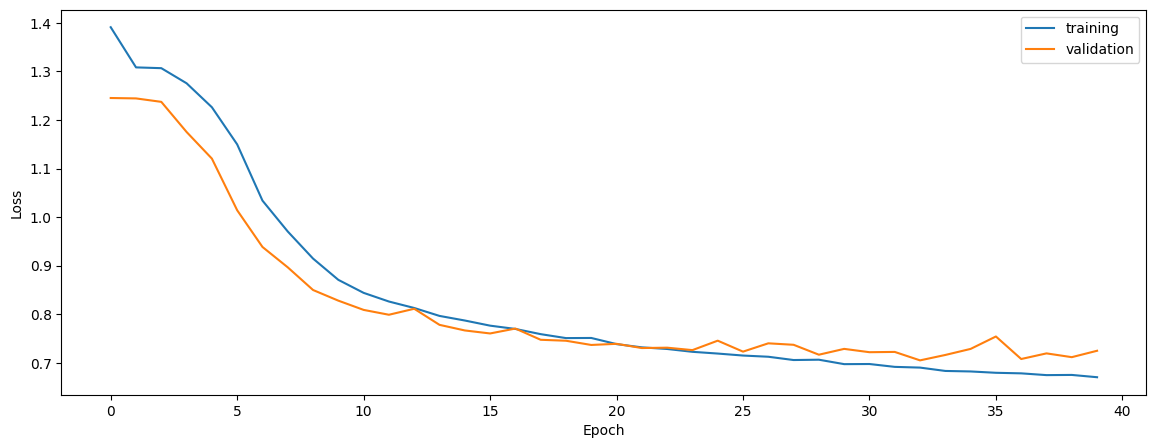

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


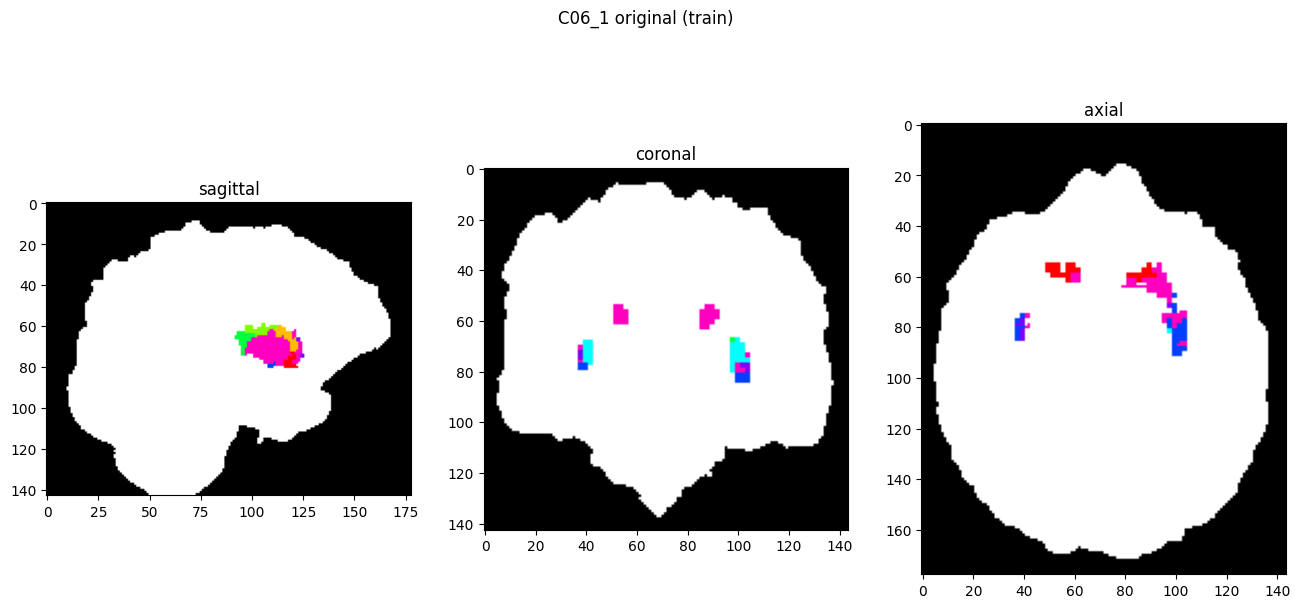

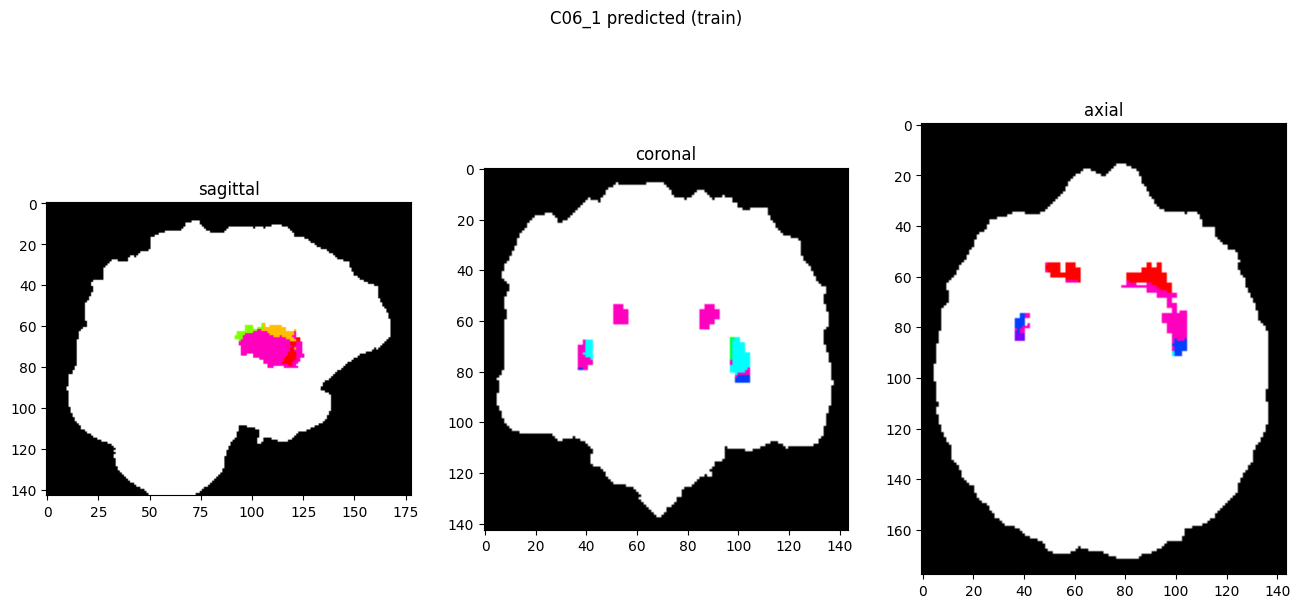

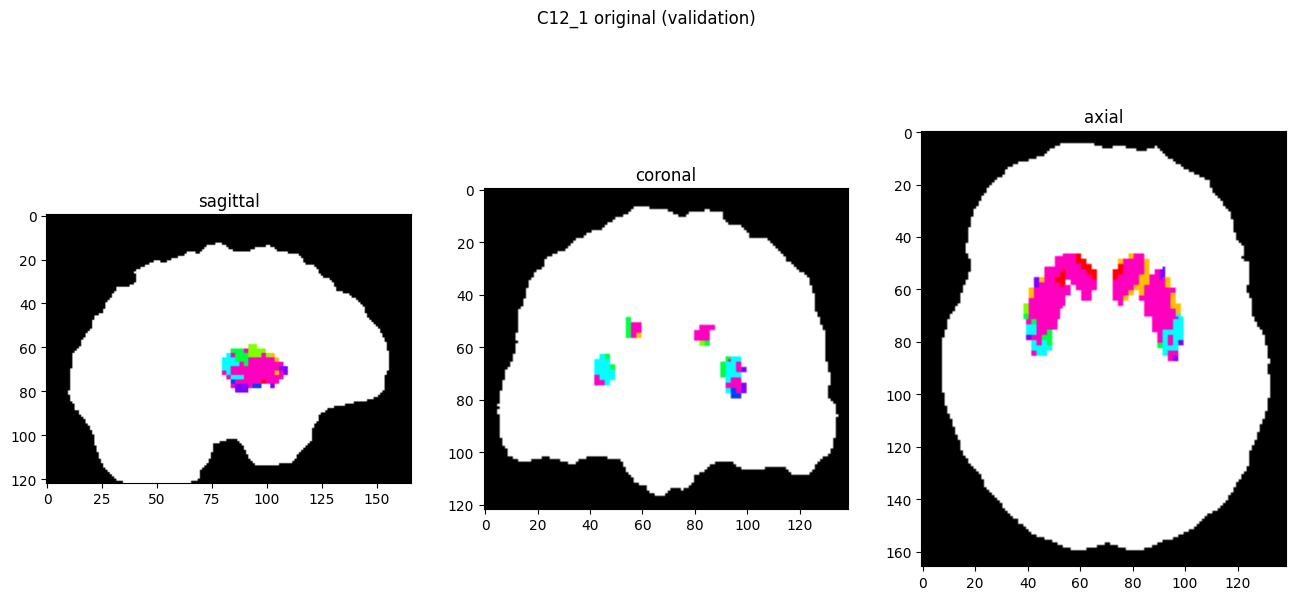

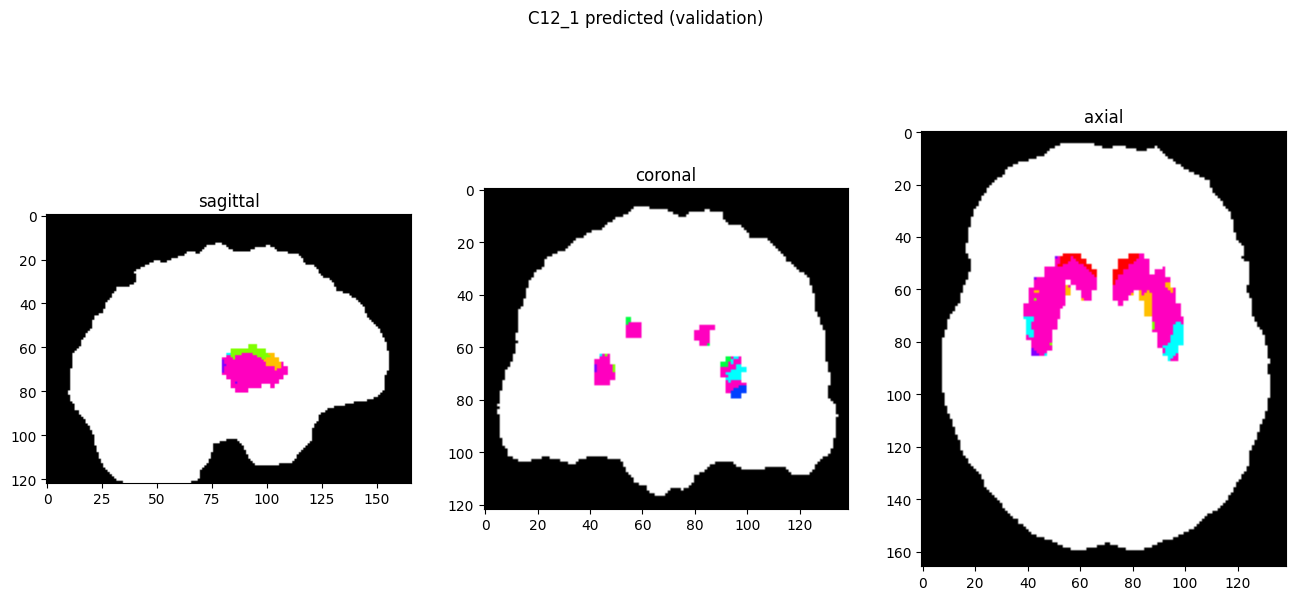

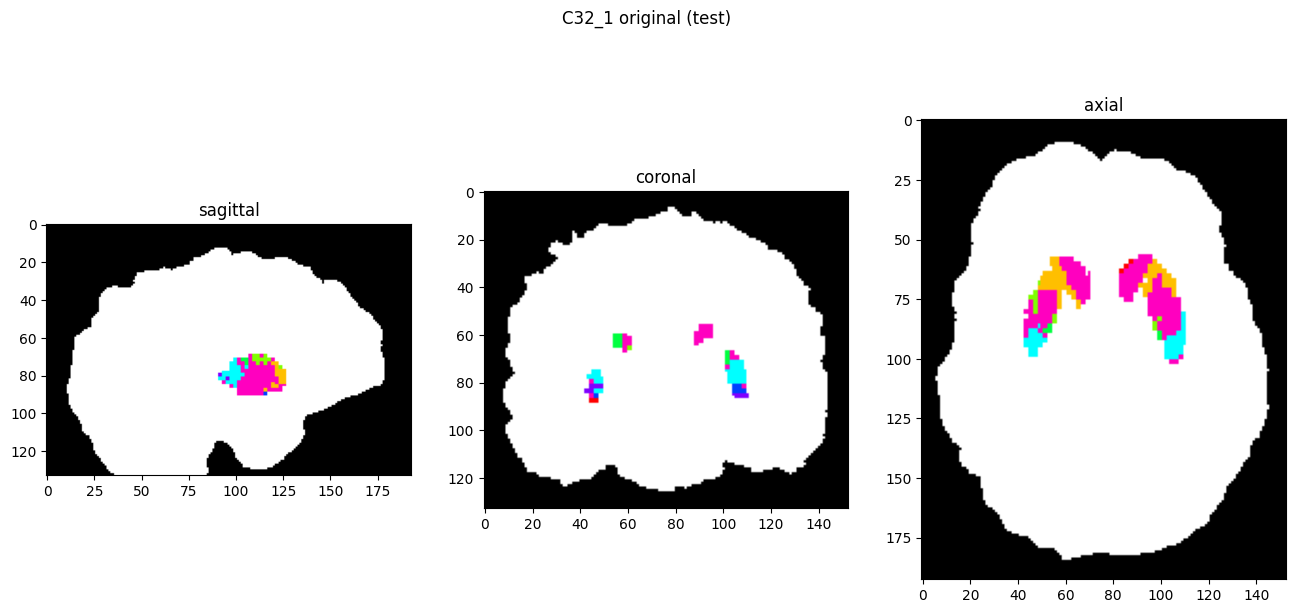

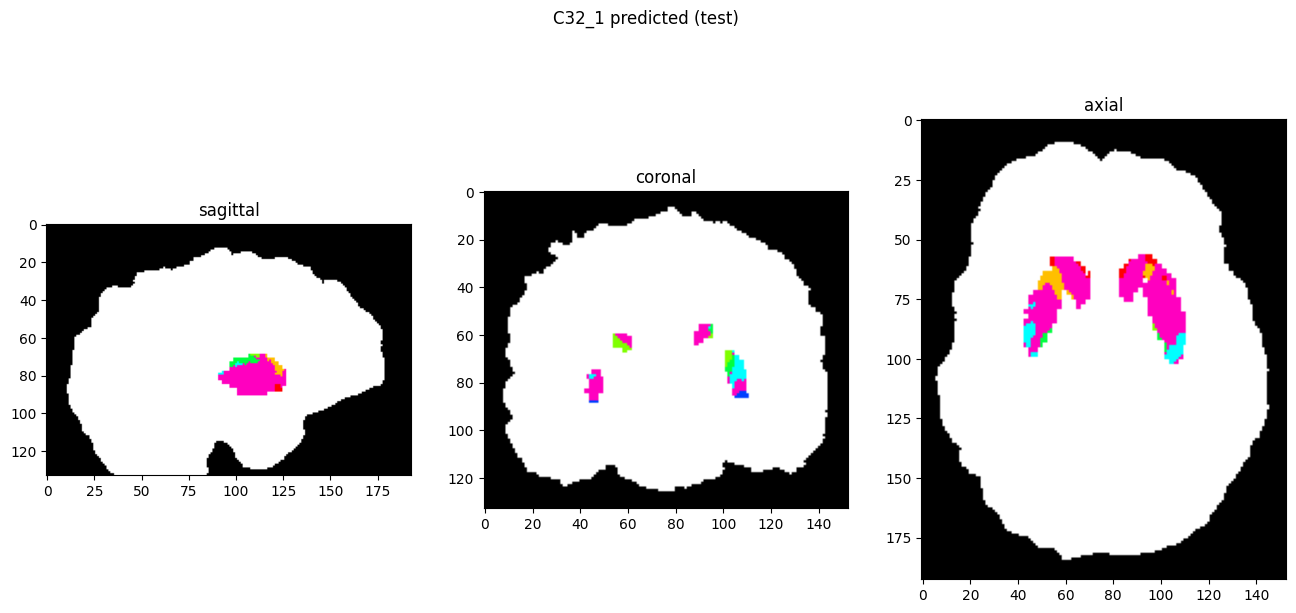

In [10]:
showResults(model, gen, threshold=0)